# Generative Models

## GANs & VAE

### HW4

**Full Name:** Esra Kashaninia

**SID:** 402210676

In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [2]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [3]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

In [4]:
num_threads = 2 # TODO
batch_size = 128 # TODO

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) # TODO

val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False) # TODO

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        # TODO
        # Define your variational encoder layers.
        ##########################################################
        self.fc_init = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):

        ##########################################################
        # TODO
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        ##########################################################
        x = self.fc_init(x)
        x = torch.relu(x)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_var(x)

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        ##############################
        # TODO
        # Define your decoder layers.
        ##############################

        # TODO
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        ########################################
        # TODO
        # Decode the latent vector `z` to images.
        ########################################
        x = self.fc1(z)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        ##########################################################
        # TODO
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the eeparameterization trick to ensure gradient flow.
        ##########################################################
        z_mean, z_log_var = self.encoder(x)
        std = torch.exp(0.5 * z_log_var)
        noise = torch.randn_like(std)
        image = self.decoder(z_mean + noise * std)

        return image, z_mean, z_log_var

In [7]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [8]:
def criterion_function(ypred, ytrue, z_mean, z_var):
    return F.binary_cross_entropy(ypred, ytrue, reduction='sum') \
            + 0.5 * torch.sum(torch.exp(z_var) + torch.pow(z_mean, 2) - 1 - z_var)

validation_losses_vae = []

def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=50):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model = VAE(input_dim, hidden_dim, latent_dim).to(DEVICE) # TODO
    criterion = criterion_function # TODO
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # TODO

    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:

                ###############################################
                # TODO
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.
                ###############################################
                data = data[0].to(DEVICE)
                # print("data shape", data.shape)
                optimizer.zero_grad()
                ypred, y_mean, y_var = model(data.view(-1, 784))
                loss = criterion(ypred, data.view(-1, 784), y_mean, y_var)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()


            print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))

        # We need to calculate the validation loss of each epoch so that we can plot them in the last cell
        model.eval()
        val_loss = 0
        with torch.no_grad():
                for i, data in enumerate(val_loader):
                    data = data[0].to(DEVICE)
                    ypred, y_mean, y_var = model(data.view(-1, 784))
                    loss = criterion(ypred, data.view(-1, 784), y_mean, y_var)
                    val_loss += loss.item()
        validation_losses_vae.append(val_loss)

        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        recon_image = reconstruct_images(model, sample_images.view(-1, 784))
        fig, axes = plt.subplots(1, 4, figsize=(8, 2))
        for i, ax in enumerate(axes.flatten()):
            # print(recon_image[i].shape)
            ax.imshow(recon_image[i].view(28, 28).cpu(), cmap='gray')
            ax.axis('off')
        plt.show()

    for img in recon_image:
        recon_images.append(img)

    return model

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 291.3810


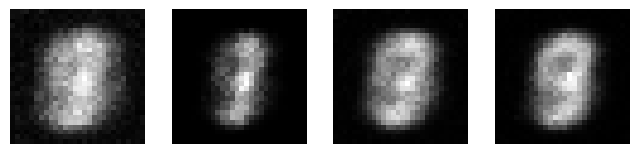

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 201.3347


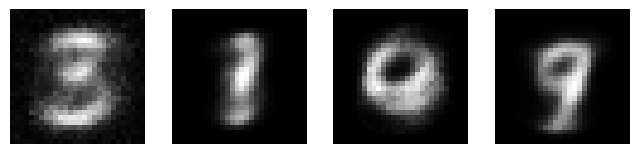

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 175.1636


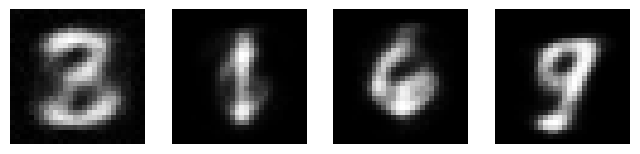

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 162.7232


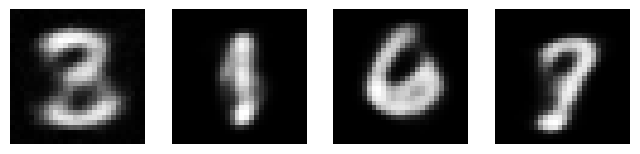

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 154.1118


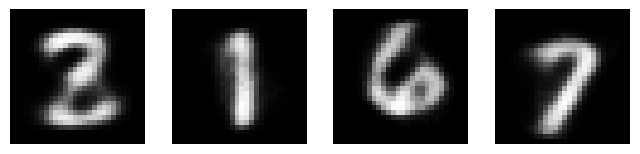

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 147.2850


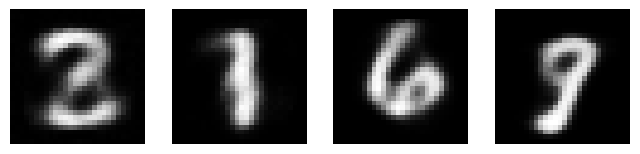

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 141.7999


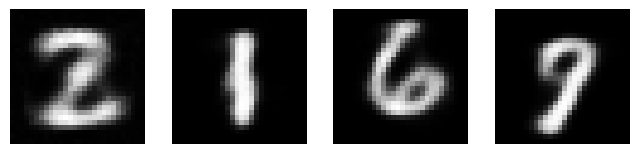

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 137.7759


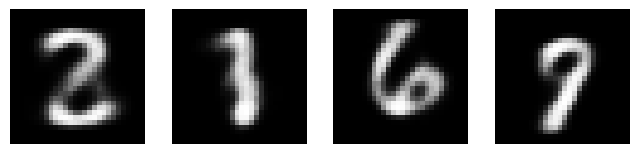

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 134.5951


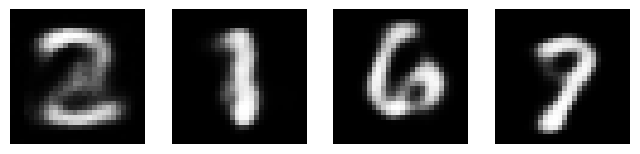

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 131.9798


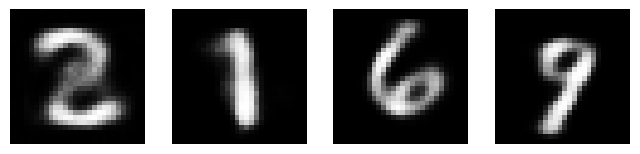

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 129.6957


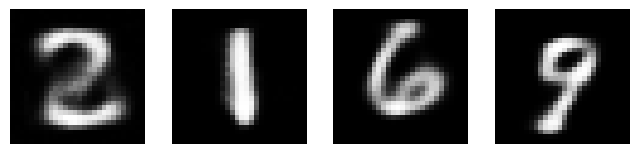

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 127.8294


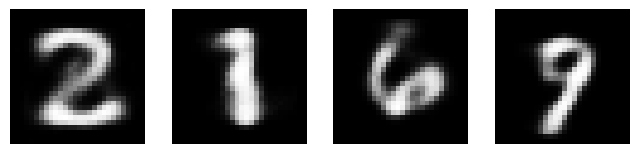

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 126.2446


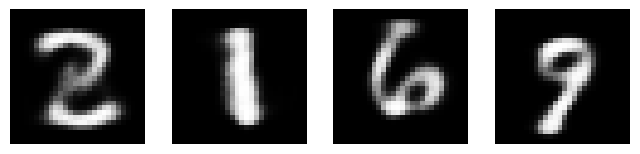

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 124.8309


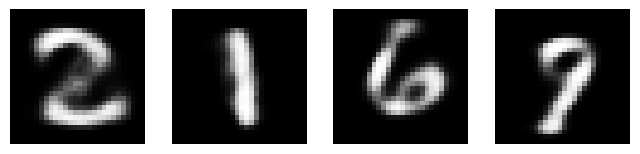

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 123.5691


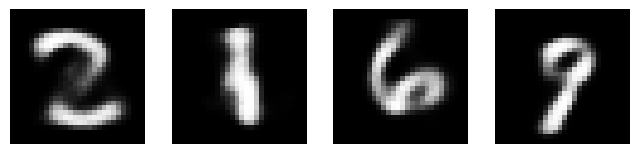

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 122.4004


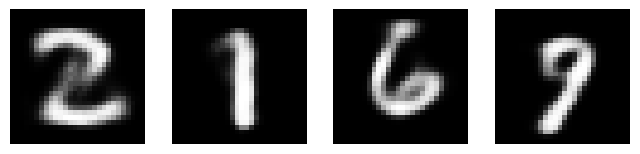

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 121.3048


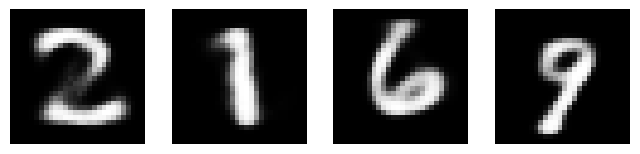

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 120.3743


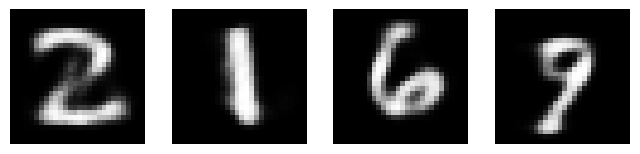

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 119.4643


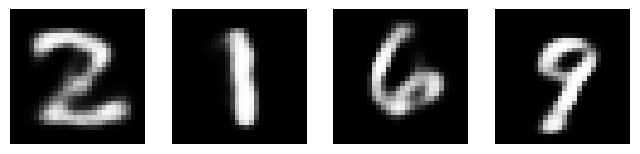

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 118.6703


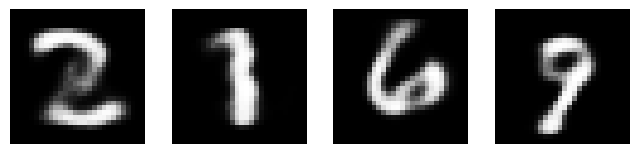

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 118.0445


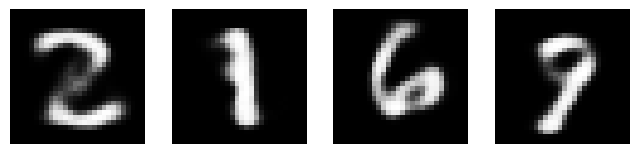

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 117.4019


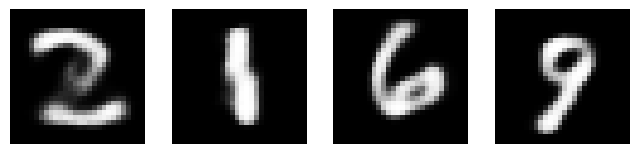

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 116.8256


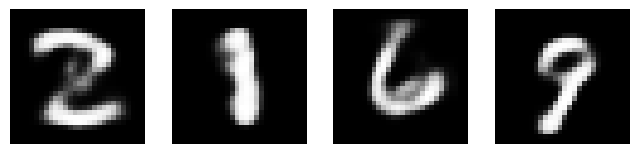

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 116.2885


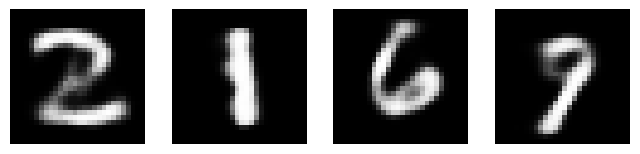

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 115.8491


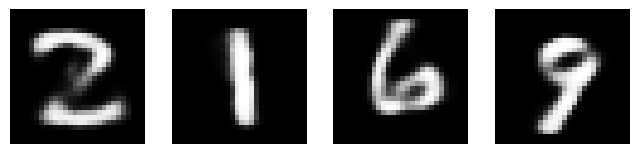

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 115.4015


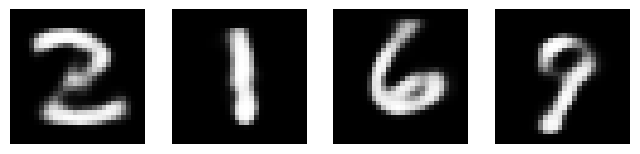

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 114.9957


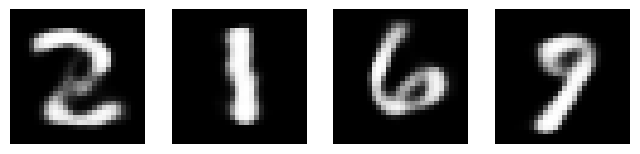

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 114.5776


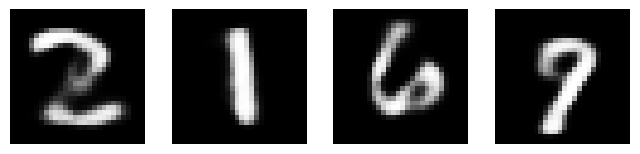

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 114.2235


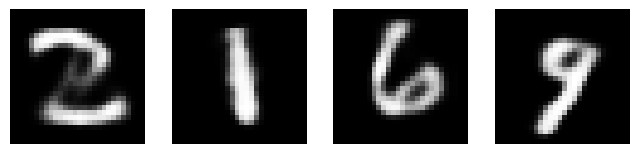

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 113.9177


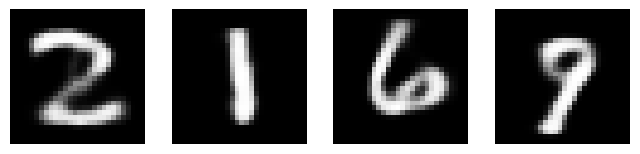

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 113.6192


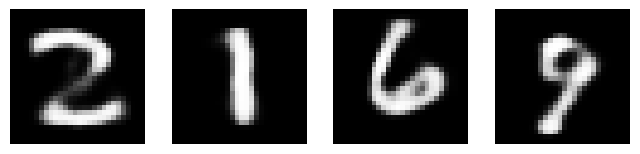

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 113.3010


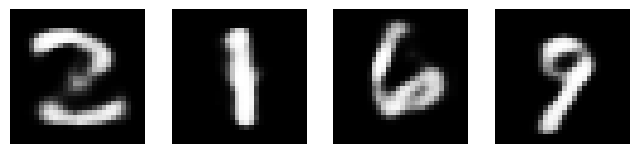

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 113.0336


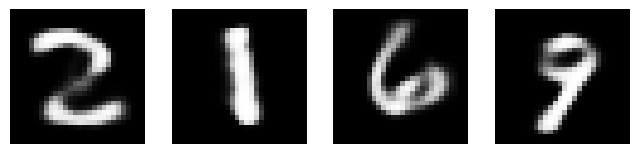

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 112.7361


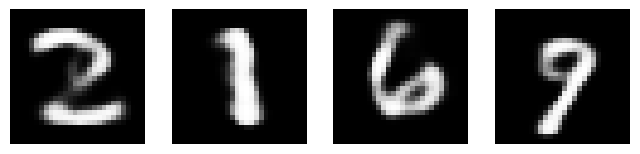

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 112.5217


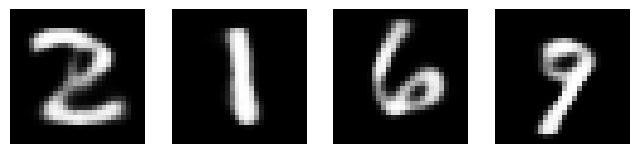

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 112.2338


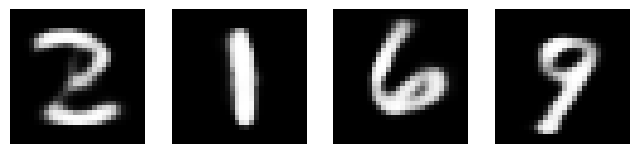

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 112.0811


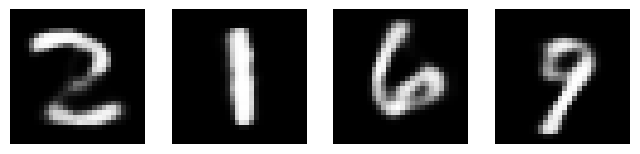

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 111.8416


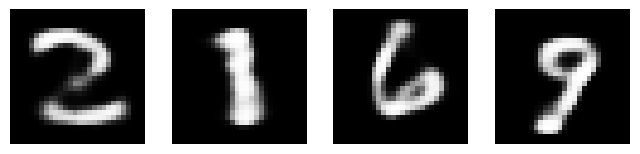

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 111.6079


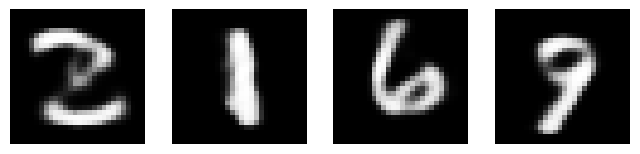

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 111.4163


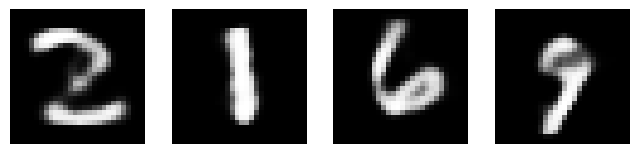

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 111.2303


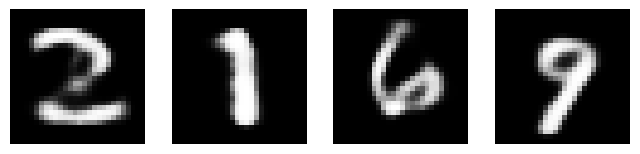

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 111.0820


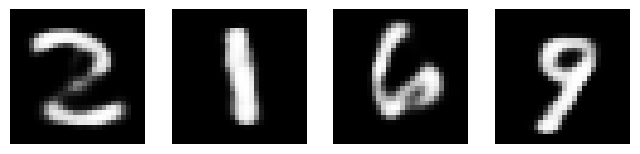

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 110.8784


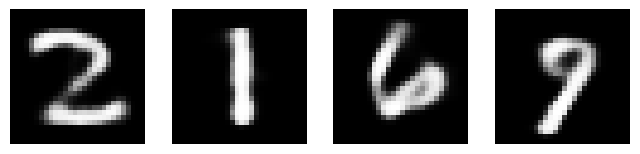

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 110.7100


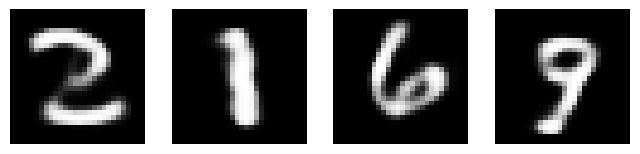

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 110.5558


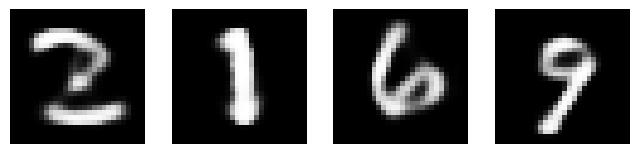

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 110.4351


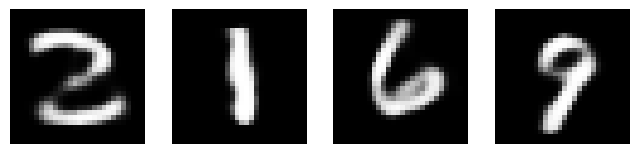

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 110.2657


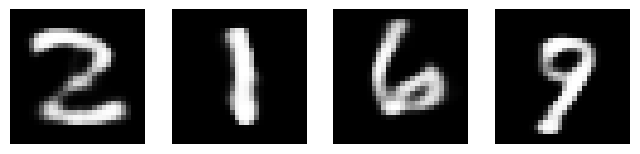

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 110.0876


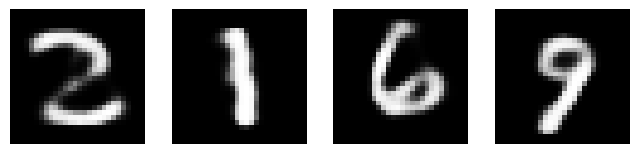

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 109.9944


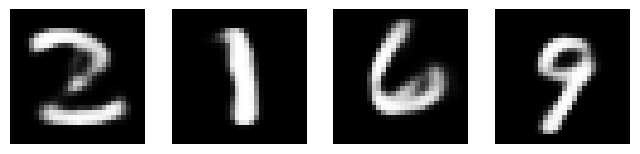

  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 109.8486


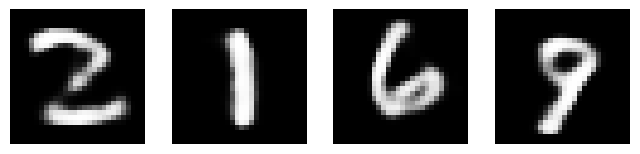

In [9]:
input_dim = 784
hidden_dim = 256
latent_dim = 20

model = train_vae(train_loader, latent_dim, hidden_dim, input_dim)

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [10]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################

        self.img_shape = img_shape

        self.model = nn.Sequential(
            # TODO

            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.02),
            nn.Linear(256, img_shape),
            nn.Tanh()
        )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################

        self.model = nn.Sequential(
            # TODO

            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.02),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        x = self.model(img)
        return x

In [11]:
validation_losses_gan = []

def train_gan(dataloader, latent_dim, img_shape=1 * 28 * 28, learning_rate=3e-4, num_epochs=100):
    global batch_size
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = Generator(latent_dim, img_shape).to(DEVICE) # TODO
    discriminator = Discriminator(img_shape).to(DEVICE) # TODO
    adversarial_loss = nn.BCELoss() # TODO
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate) # TODO
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate) # TODO

    for epoch in range(num_epochs):
        # I added plot_imgs
        plot_real = []
        plot_fake = []
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                ##########################################################
                # TODO
                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################
                imgs = imgs.view(-1, 784).to(DEVICE)
                noise = torch.randn(batch_size, latent_dim).to(DEVICE)
                false_imgs = generator(noise)


                # TODO
                # Calculate and fill discriminator and generator losses
                disc_true = discriminator(imgs).view(-1)
                loss_true = adversarial_loss(disc_true, torch.ones_like(disc_true))
                disc_false = discriminator(false_imgs).view(-1)
                loss_false = adversarial_loss(disc_false, torch.zeros_like(disc_false))

                loss_d = (loss_true + loss_false) / 2
                discriminator.zero_grad()
                loss_d.backward(retain_graph=True)
                optimizer_D.step()

                output = discriminator(false_imgs).view(-1)
                loss_g = adversarial_loss(output, torch.ones_like(output))
                generator.zero_grad()
                loss_g.backward()
                optimizer_G.step()

                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch, num_epochs, loss_d.item(), loss_d.item()))

                fixed_noise = torch.randn((batch_size, latent_dim)).to(DEVICE)
                with torch.no_grad():
                    if i < 16:
                        fake = generator(fixed_noise).reshape(-1, 1, 28, 28)
                        data = imgs.reshape(-1, 1, 28, 28)
                        plot_fake.append(fake[0])
                        plot_real.append(imgs[0])

        # We need to calculate the validation loss of each epoch so that we can plot them in the last cell
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i, (imgs, _) in enumerate(val_loader):
                imgs = imgs.view(-1, 784).to(DEVICE)
                noise = torch.randn(batch_size, latent_dim).to(DEVICE)
                false_imgs = generator(noise)

                disc_true = discriminator(imgs).view(-1)
                loss_true = adversarial_loss(disc_true, torch.ones_like(disc_true))
                disc_false = discriminator(false_imgs).view(-1)
                loss_false = adversarial_loss(disc_false, torch.zeros_like(disc_false))

                loss_d = (loss_true + loss_false) / 2
                # discriminator.zero_grad()
                # loss_d.backward(retain_graph=True)
                # optimizer_D.step()

                output = discriminator(false_imgs).view(-1)
                loss_g = adversarial_loss(output, torch.ones_like(output))
                # generator.zero_grad()
                # loss_d.backward()
                # optimizer_G.step()
                val_loss += loss_d.item() / 2
                val_loss += loss_g.item() / 2
        validation_losses_gan.append(val_loss)
        # TODO
        # Plot generated images after each epoch

        # fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        # fig.suptitle("Epoch " + str(epoch) + " Real Images", fontsize=16)
        # for j, ax in enumerate(axes.flatten()):
        #     # print(recon_image[i].shape)
        #     ax.imshow(plot_real[j].view(28, 28).cpu(), cmap='gray')
        #     ax.axis('off')
        # plt.show()

        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        fig.suptitle("Epoch " + str(epoch) + " Fake Images", fontsize=16)
        for j, ax in enumerate(axes.flatten()):
            # print(recon_image[i].shape)
            ax.imshow(plot_fake[j].view(28, 28).cpu(), cmap='gray')
            ax.axis('off')
        plt.show()

    return generator, discriminator

  0%|          | 0/391 [00:00<?, ?it/s]

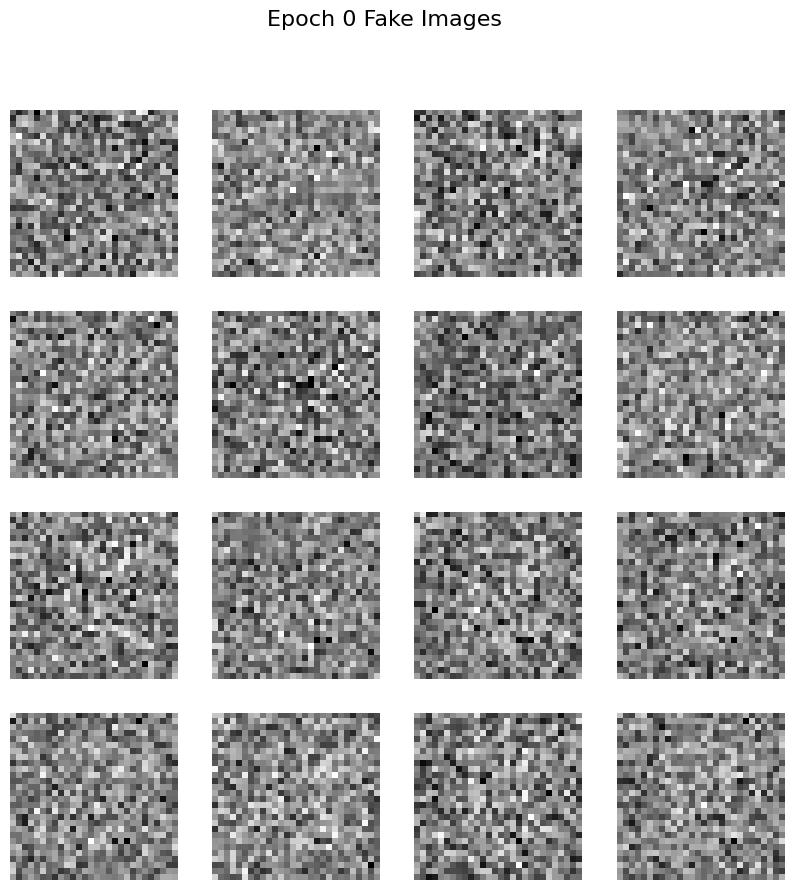

  0%|          | 0/391 [00:00<?, ?it/s]

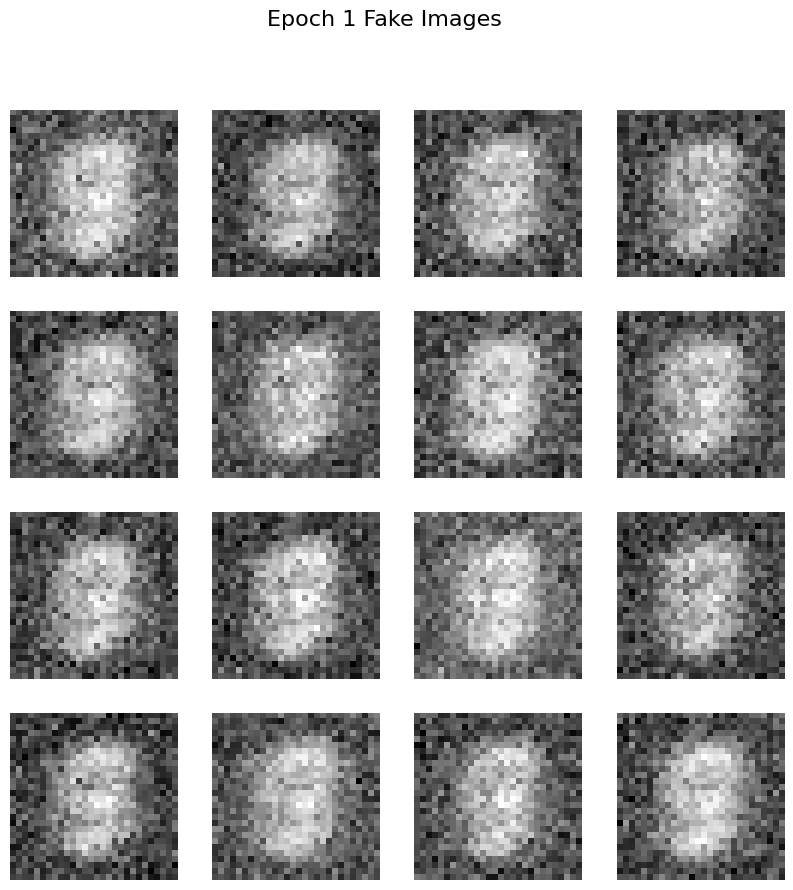

  0%|          | 0/391 [00:00<?, ?it/s]

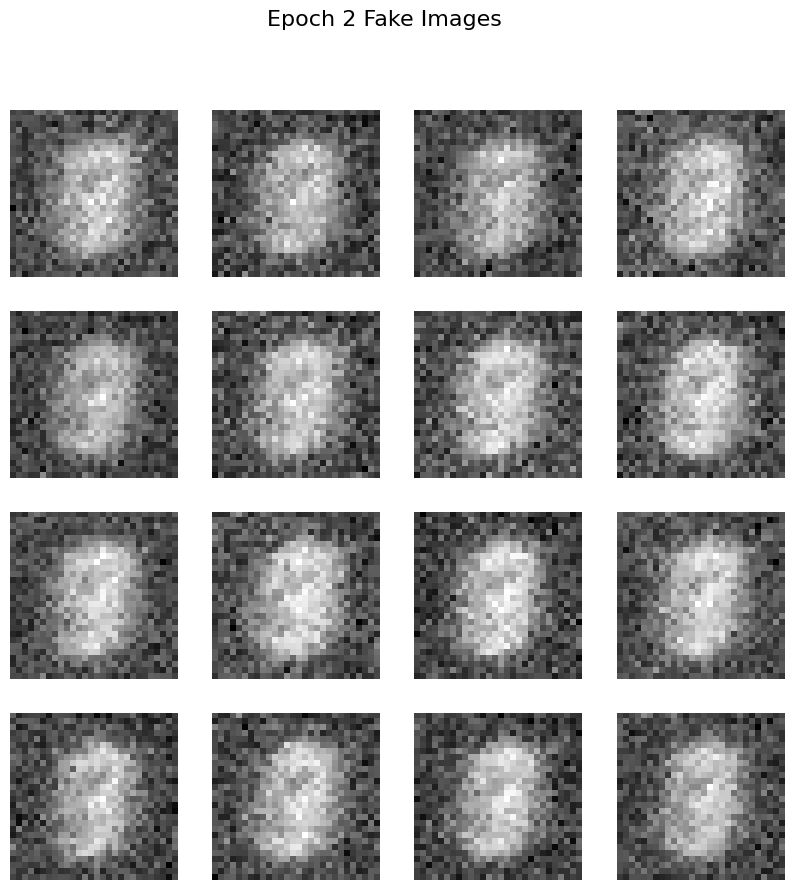

  0%|          | 0/391 [00:00<?, ?it/s]

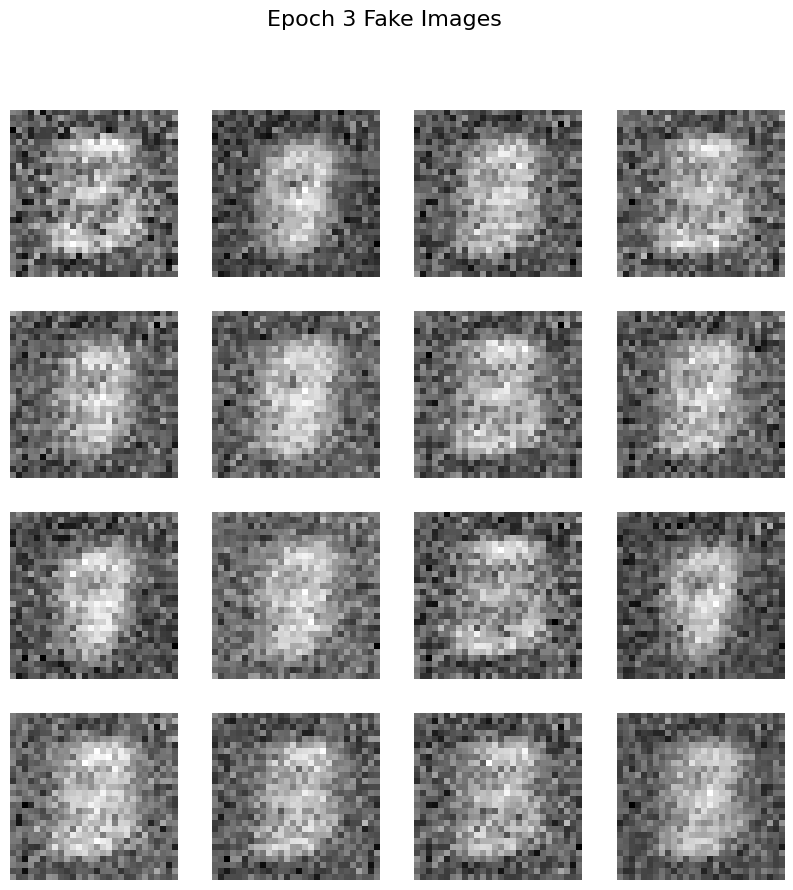

  0%|          | 0/391 [00:00<?, ?it/s]

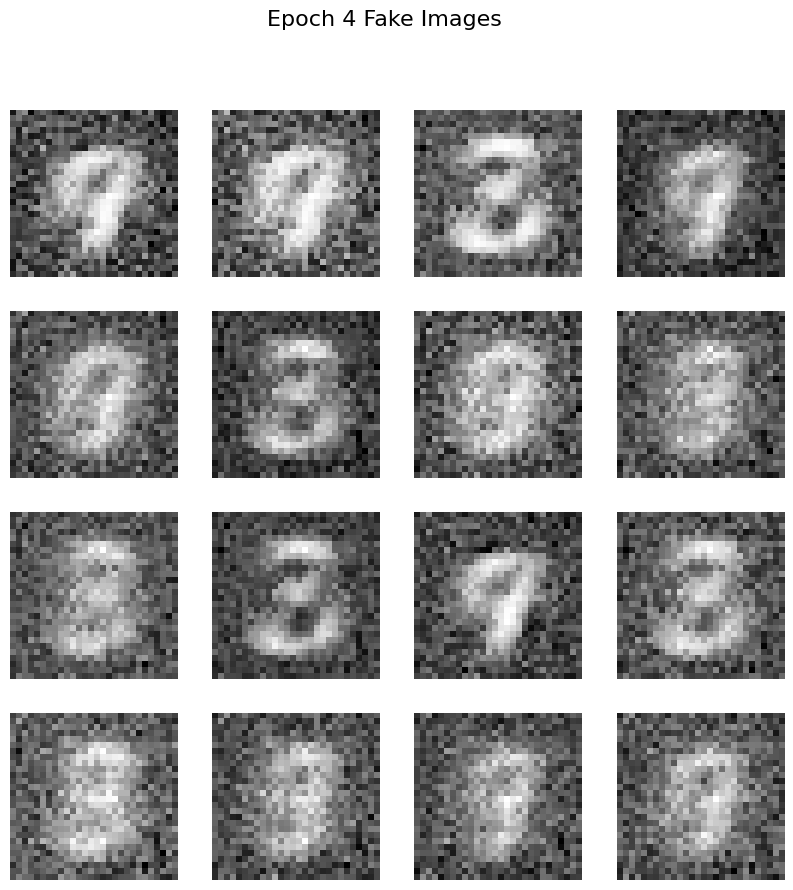

  0%|          | 0/391 [00:00<?, ?it/s]

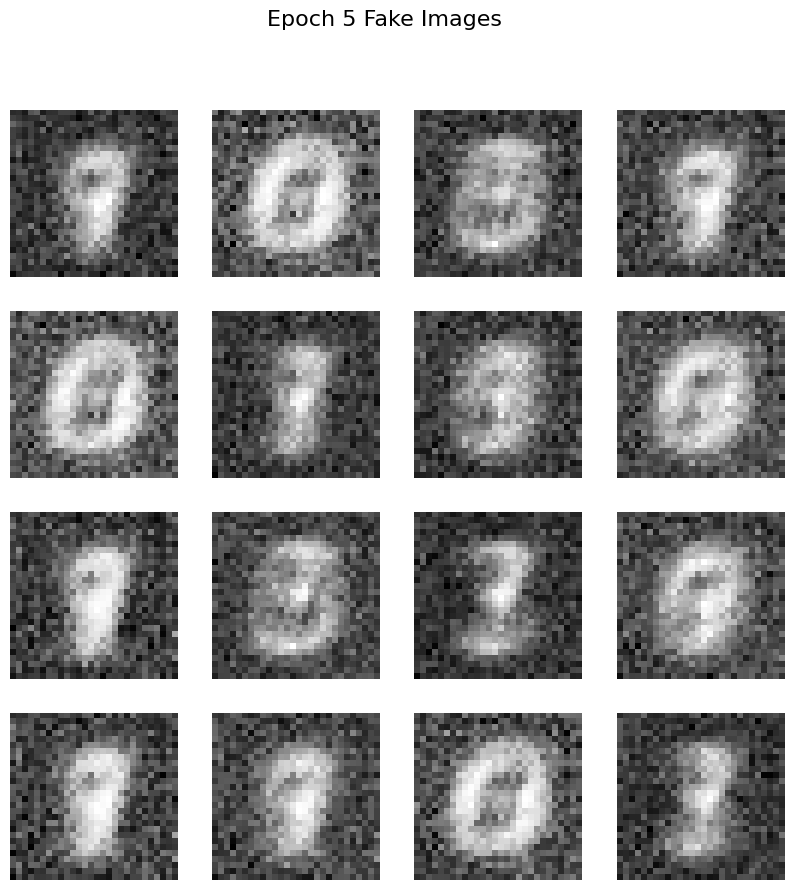

  0%|          | 0/391 [00:00<?, ?it/s]

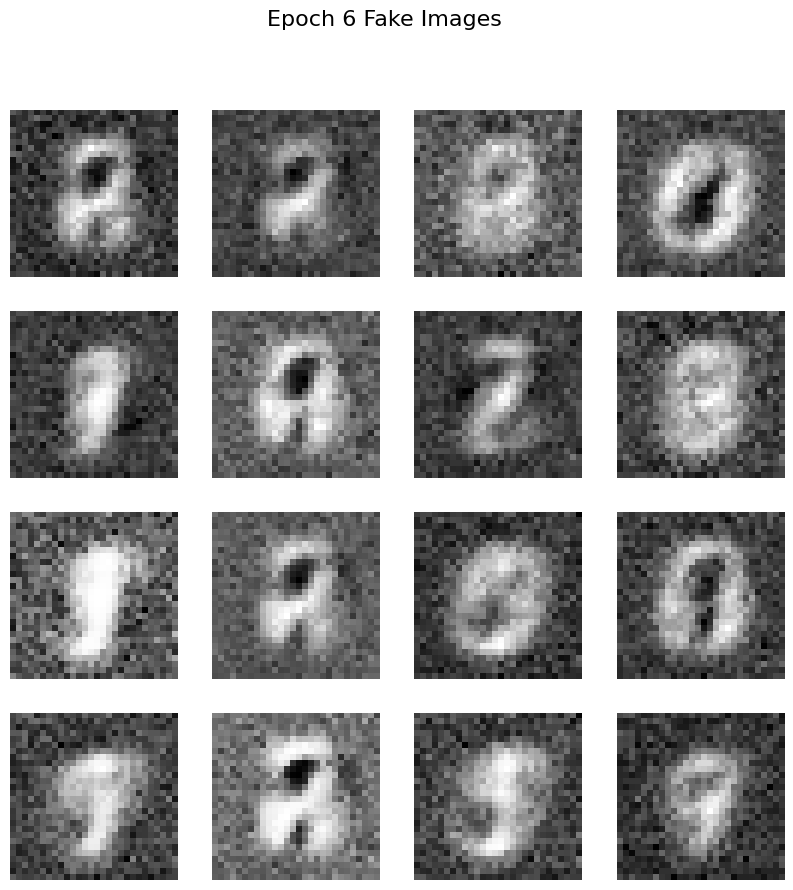

  0%|          | 0/391 [00:00<?, ?it/s]

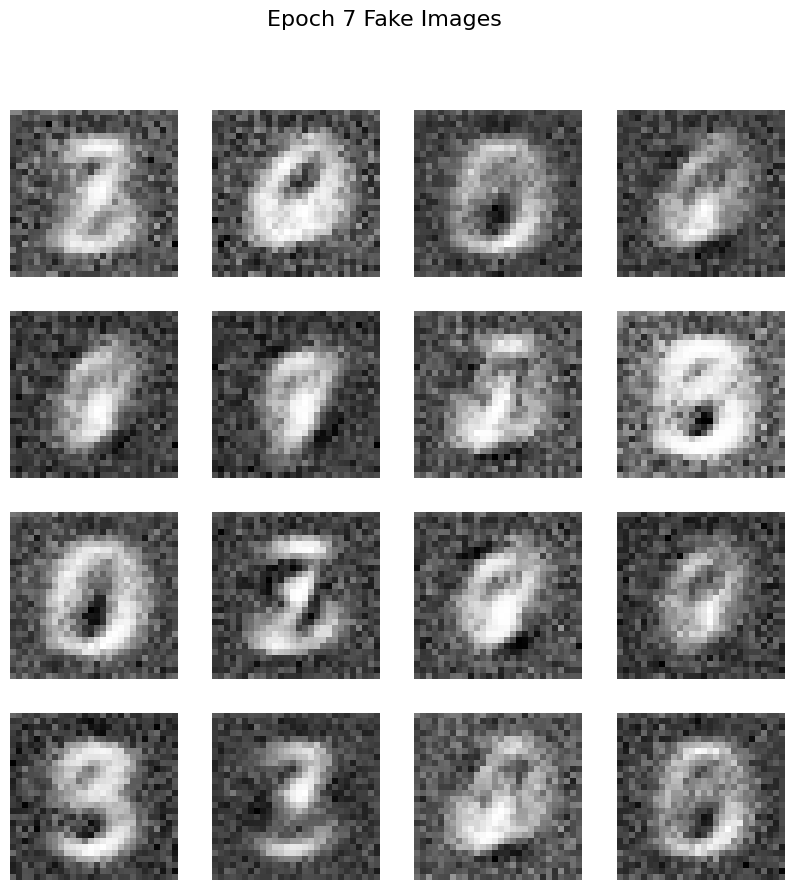

  0%|          | 0/391 [00:00<?, ?it/s]

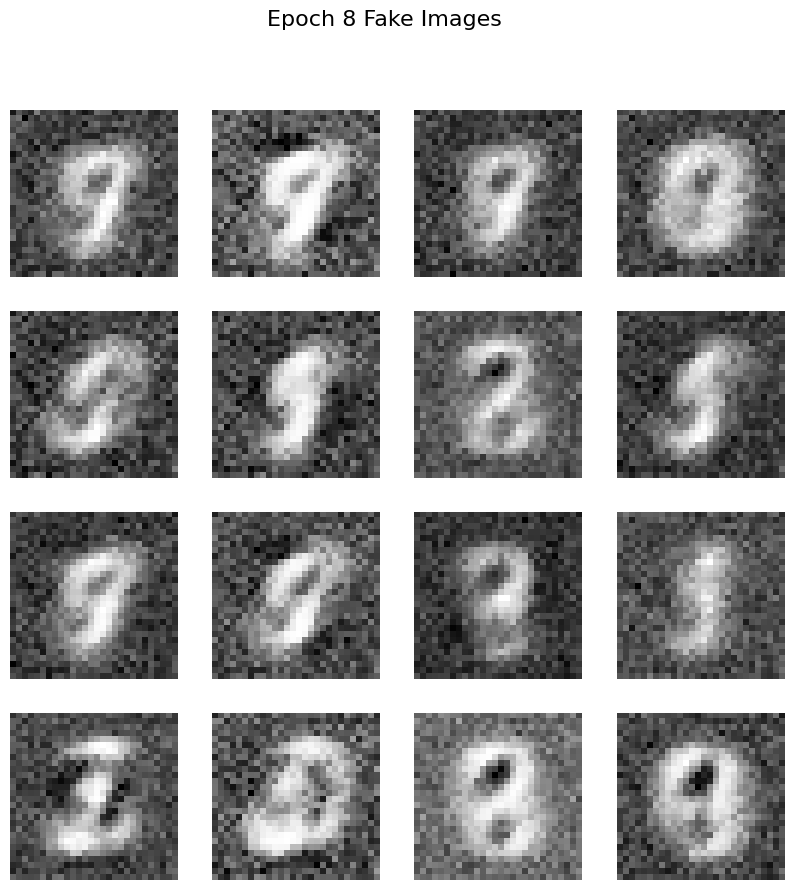

  0%|          | 0/391 [00:00<?, ?it/s]

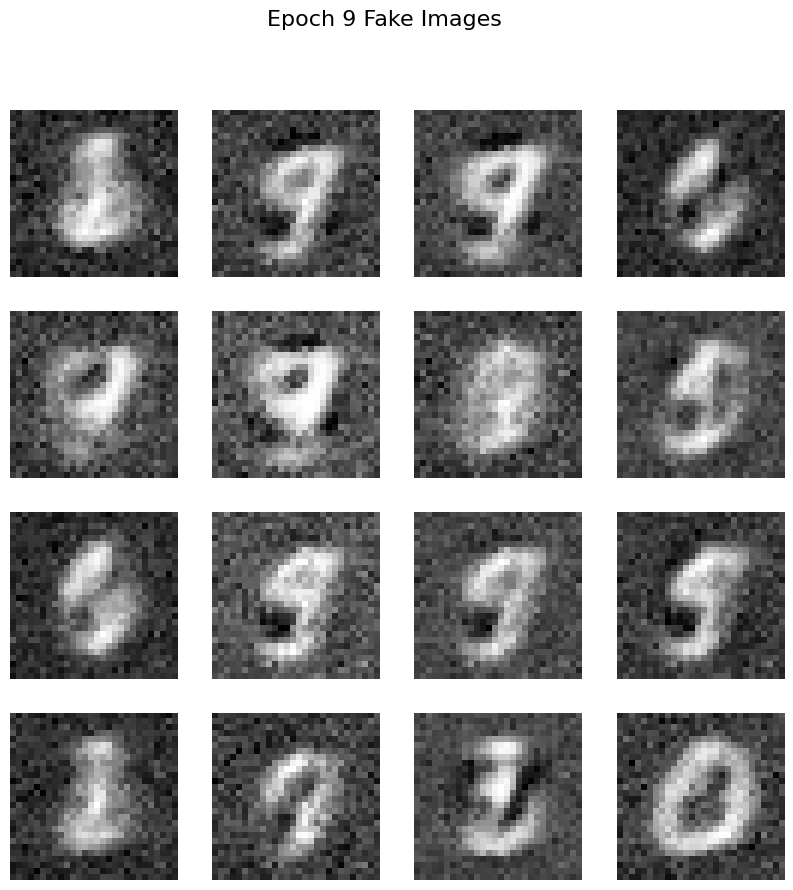

  0%|          | 0/391 [00:00<?, ?it/s]

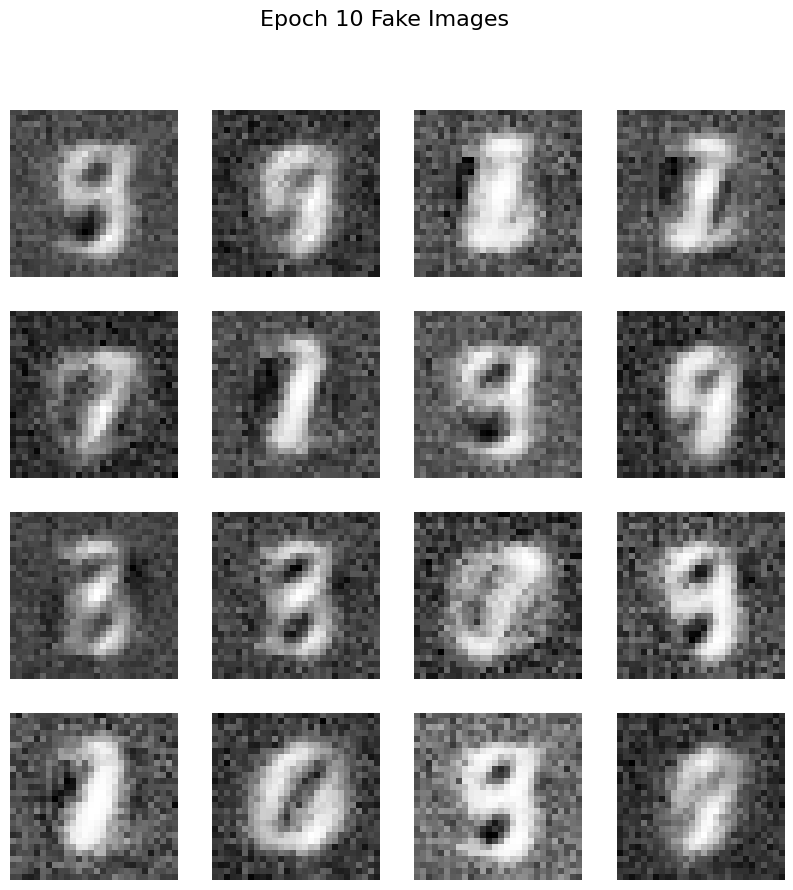

  0%|          | 0/391 [00:00<?, ?it/s]

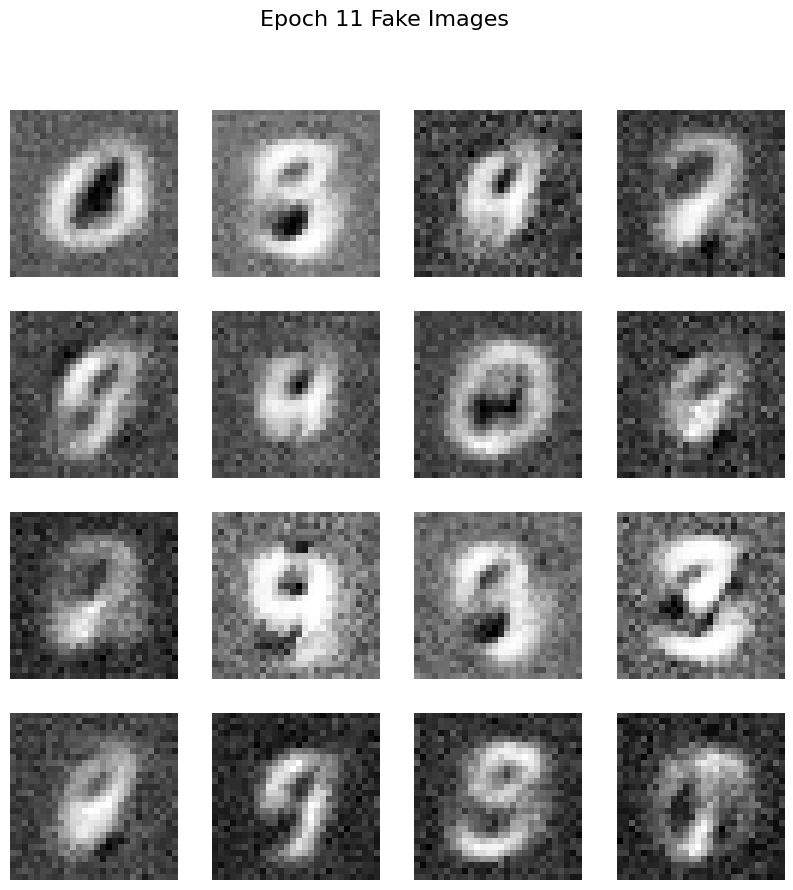

  0%|          | 0/391 [00:00<?, ?it/s]

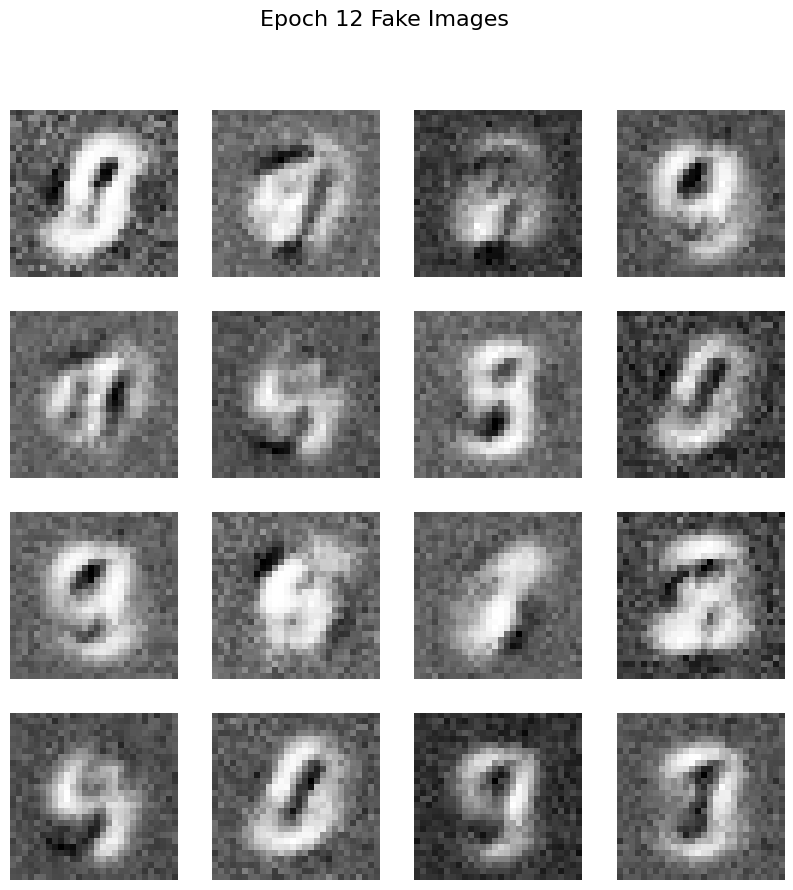

  0%|          | 0/391 [00:00<?, ?it/s]

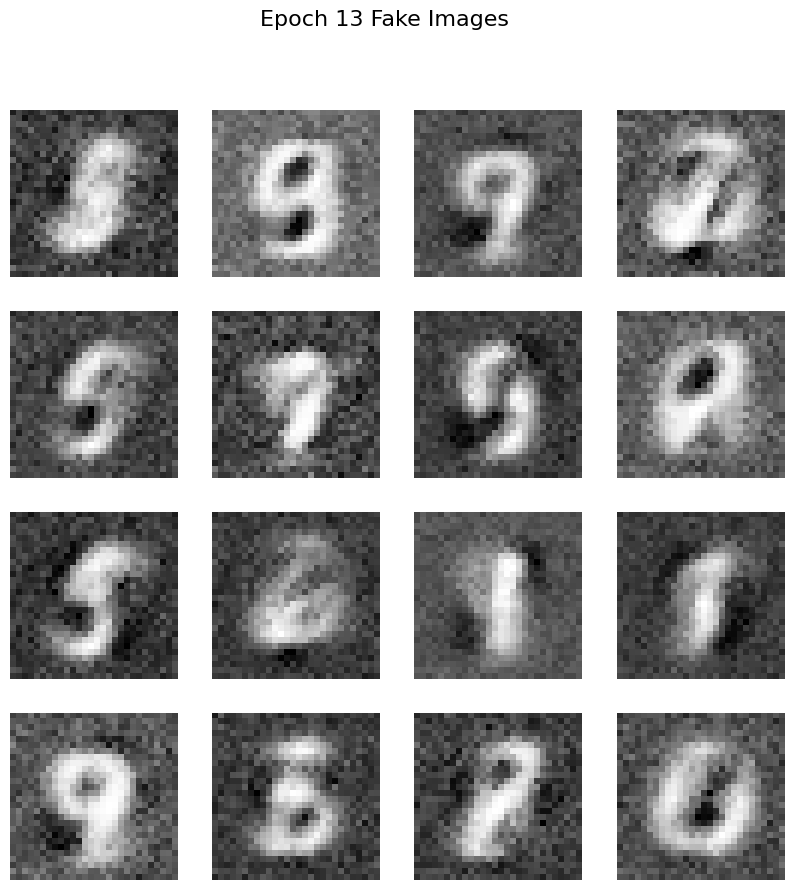

  0%|          | 0/391 [00:00<?, ?it/s]

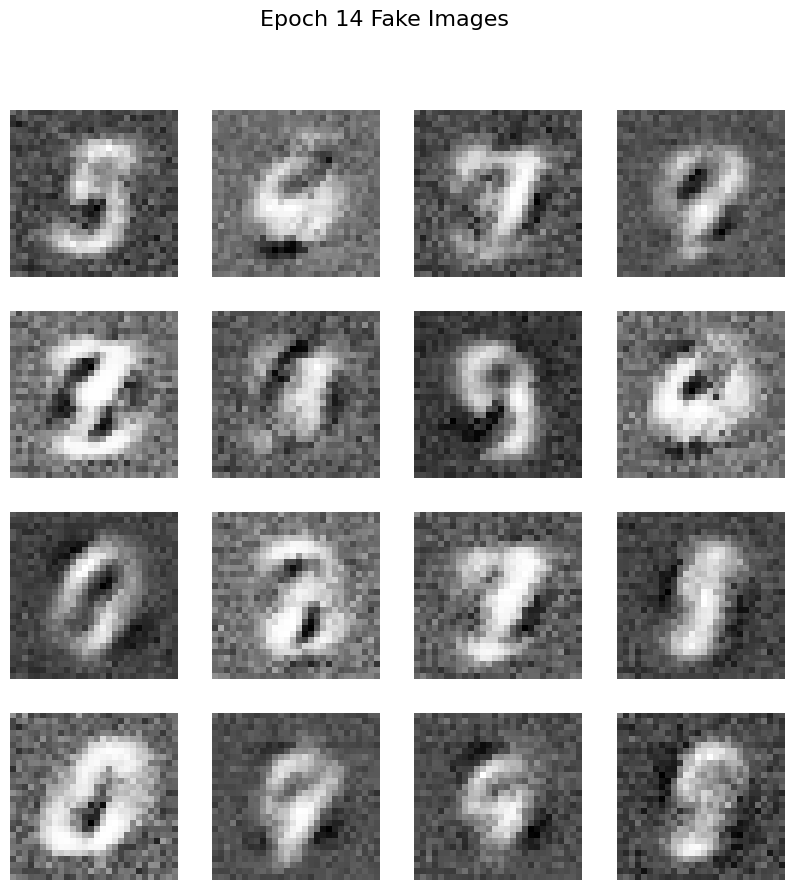

  0%|          | 0/391 [00:00<?, ?it/s]

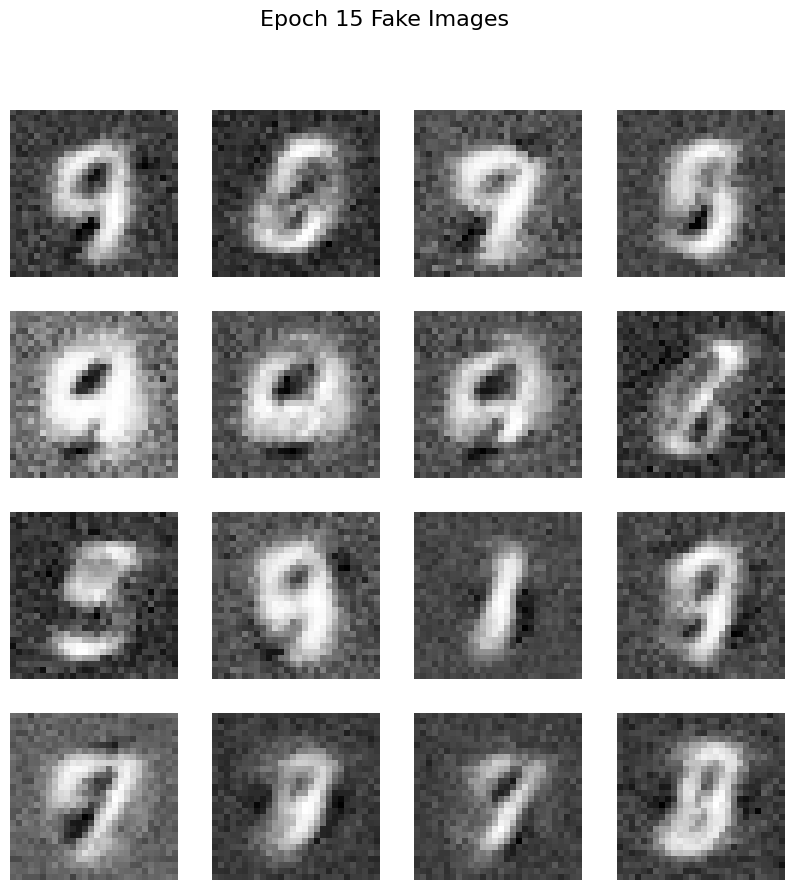

  0%|          | 0/391 [00:00<?, ?it/s]

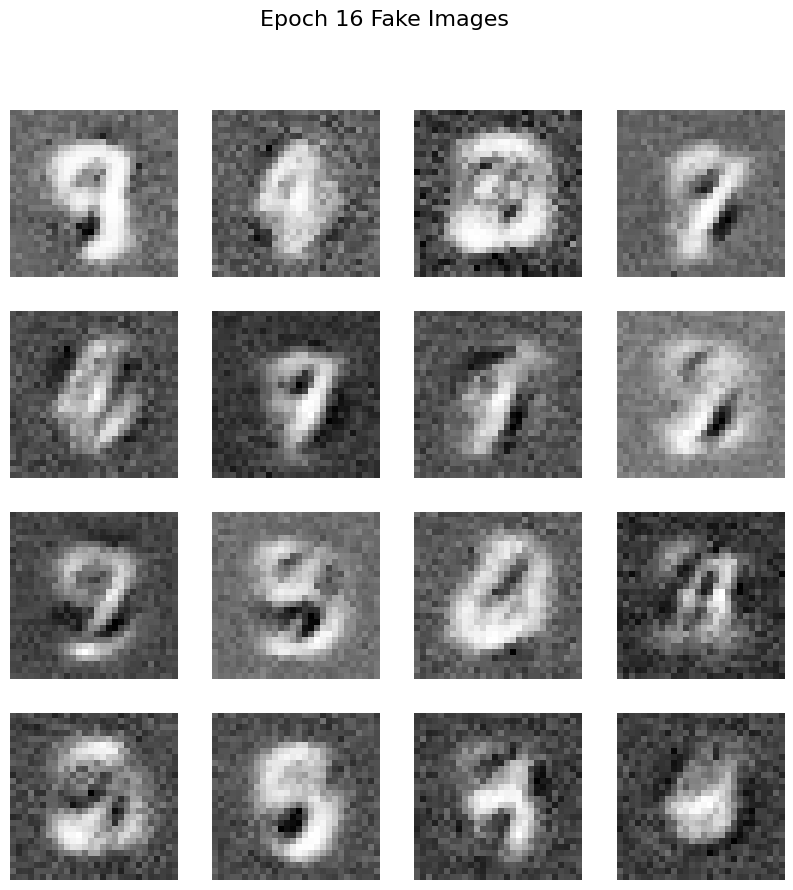

  0%|          | 0/391 [00:00<?, ?it/s]

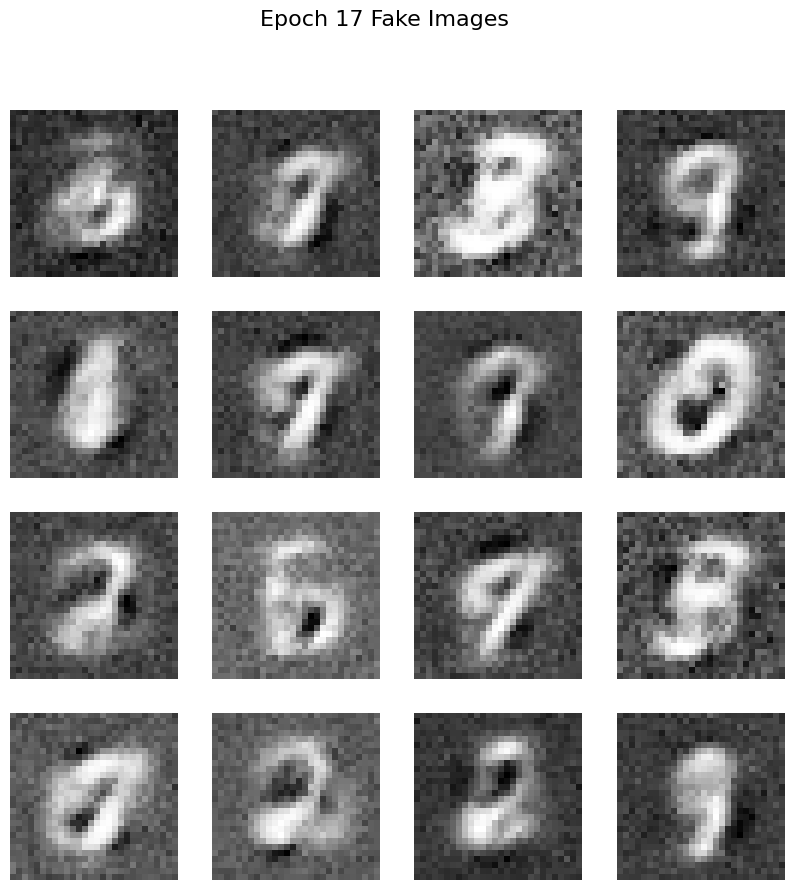

  0%|          | 0/391 [00:00<?, ?it/s]

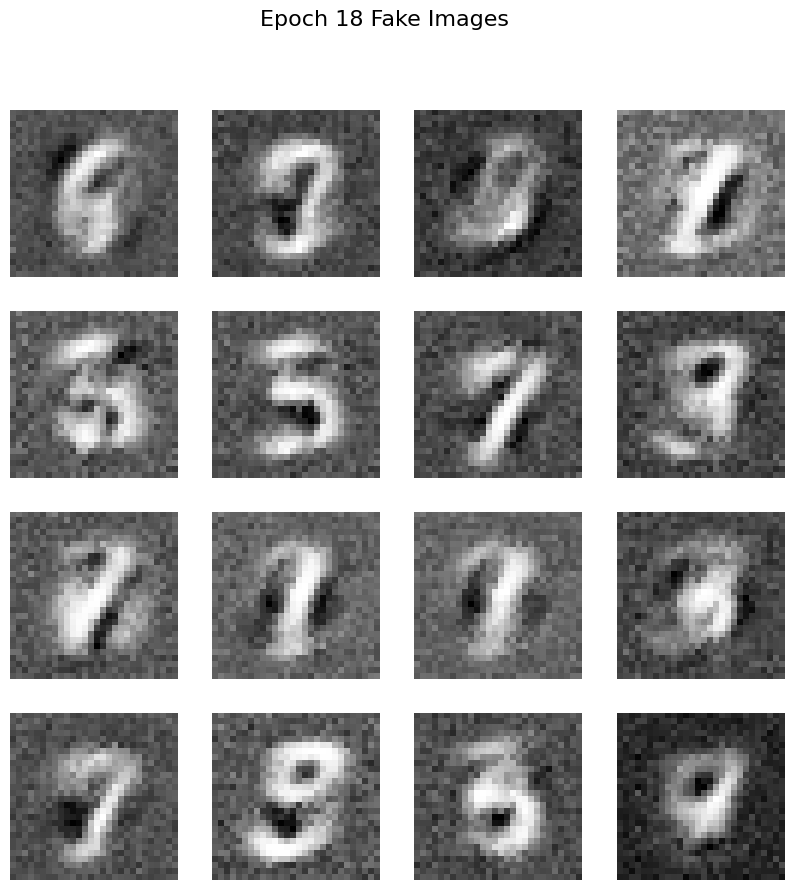

  0%|          | 0/391 [00:00<?, ?it/s]

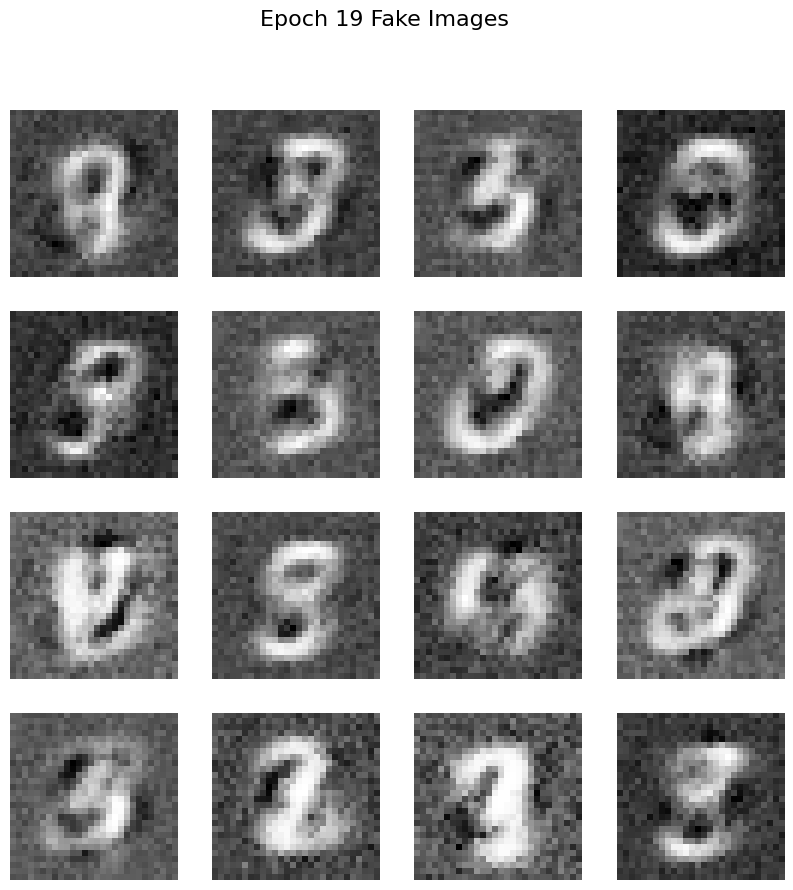

  0%|          | 0/391 [00:00<?, ?it/s]

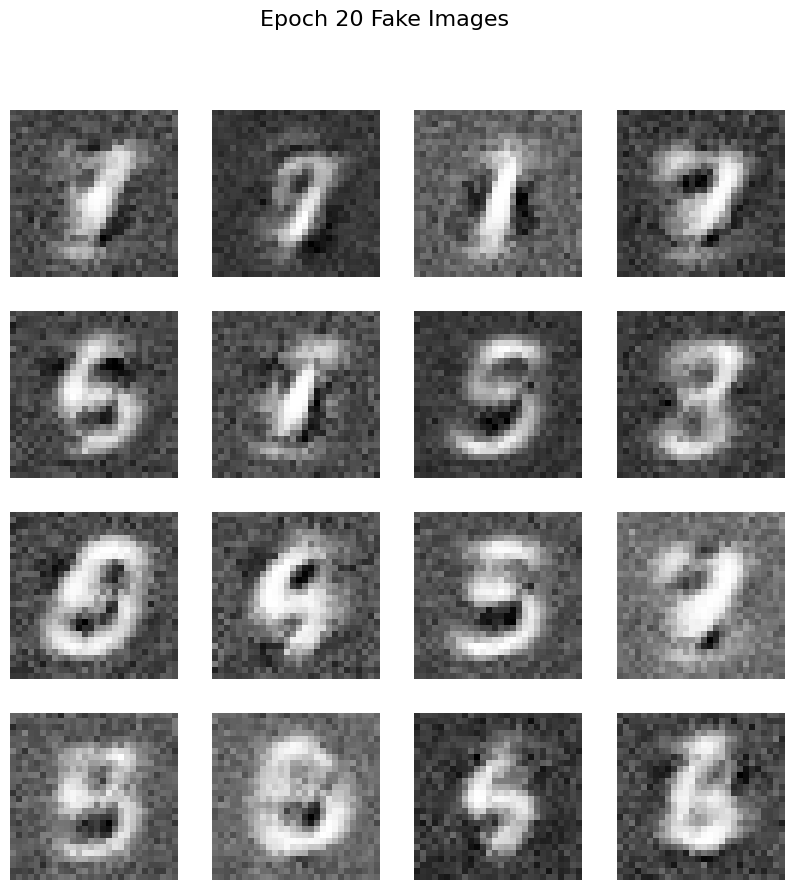

  0%|          | 0/391 [00:00<?, ?it/s]

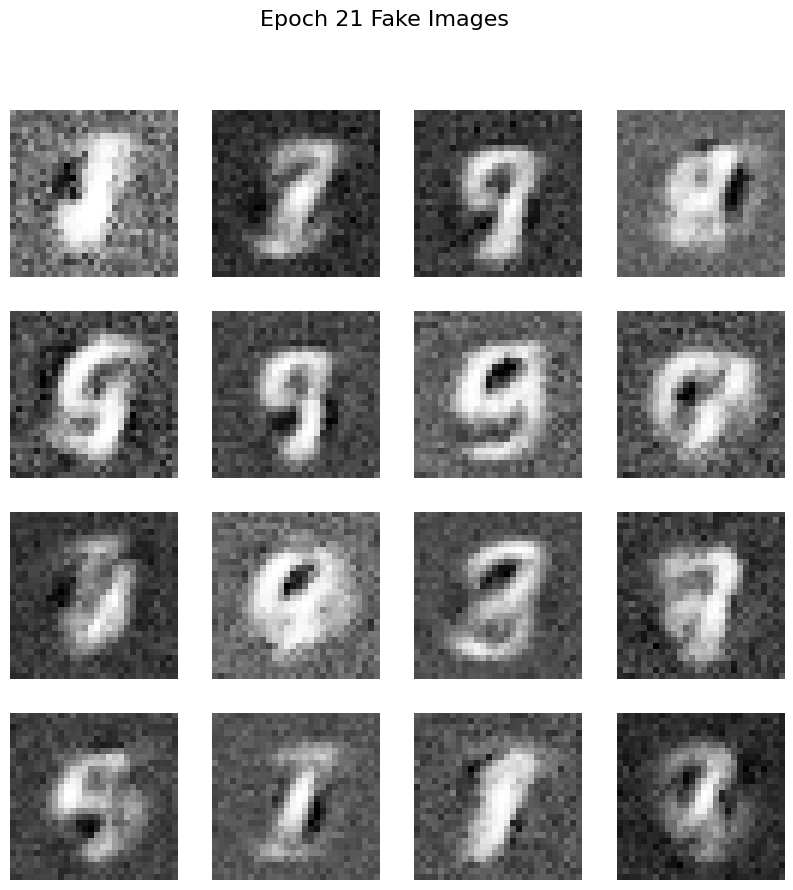

  0%|          | 0/391 [00:00<?, ?it/s]

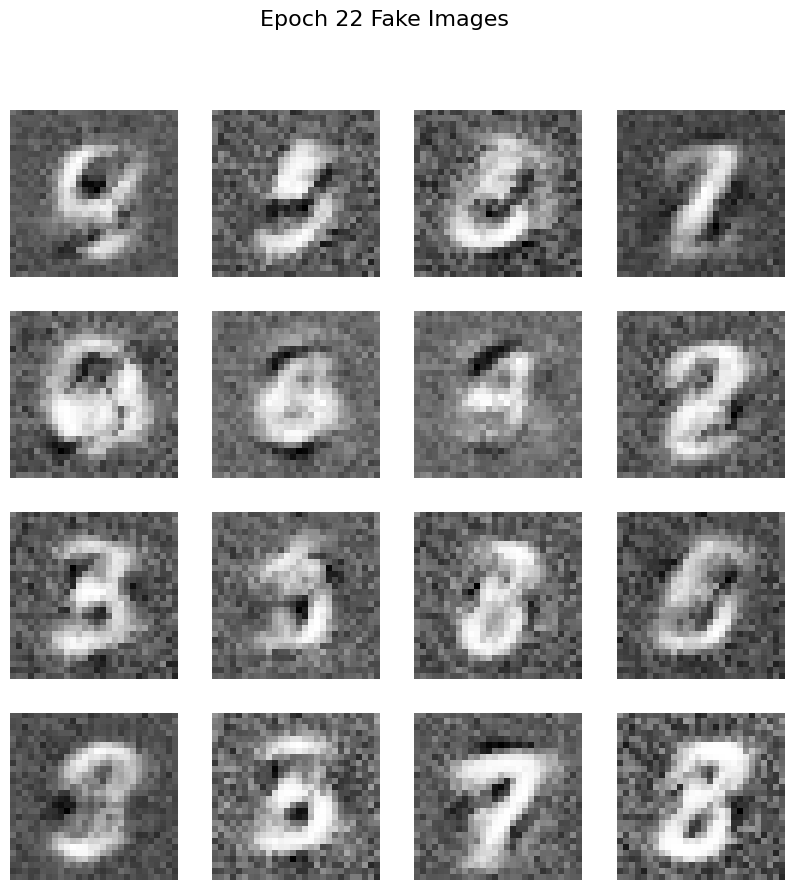

  0%|          | 0/391 [00:00<?, ?it/s]

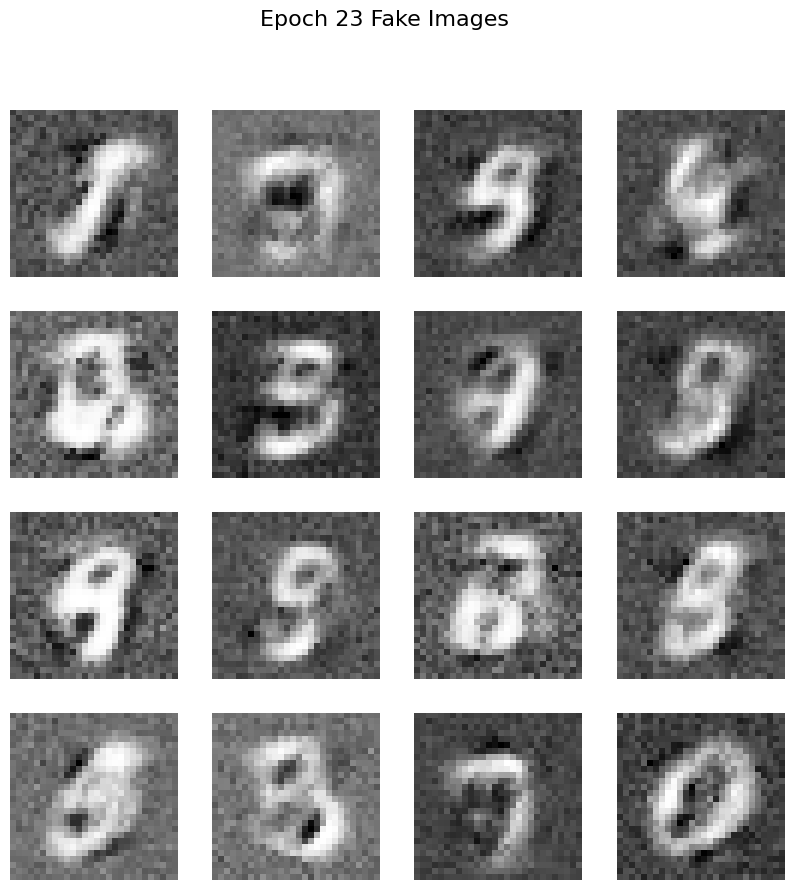

  0%|          | 0/391 [00:00<?, ?it/s]

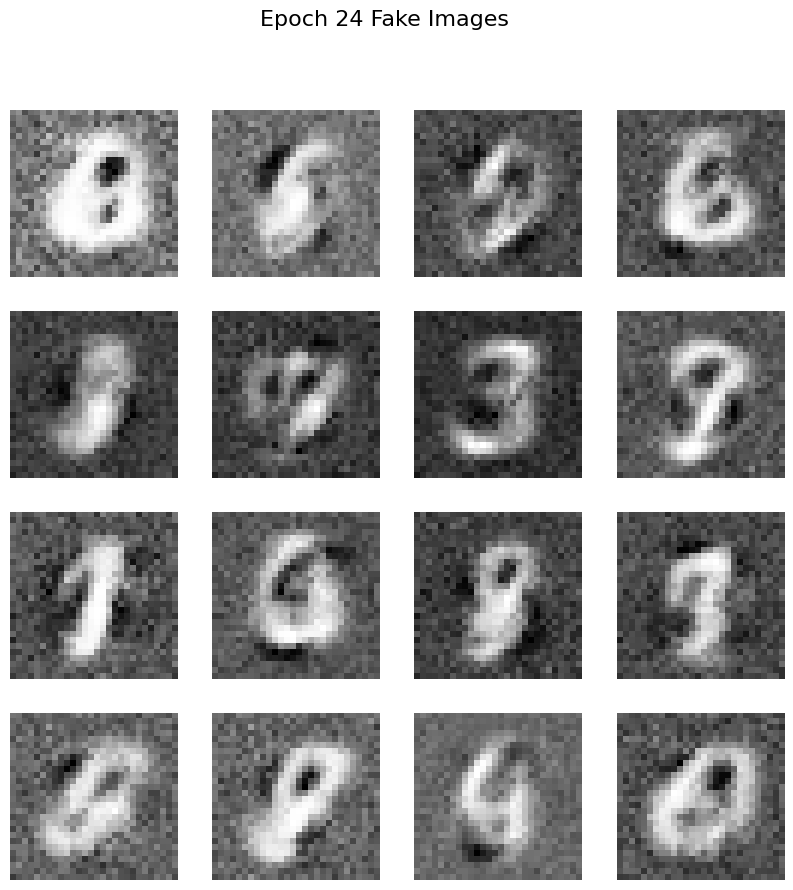

  0%|          | 0/391 [00:00<?, ?it/s]

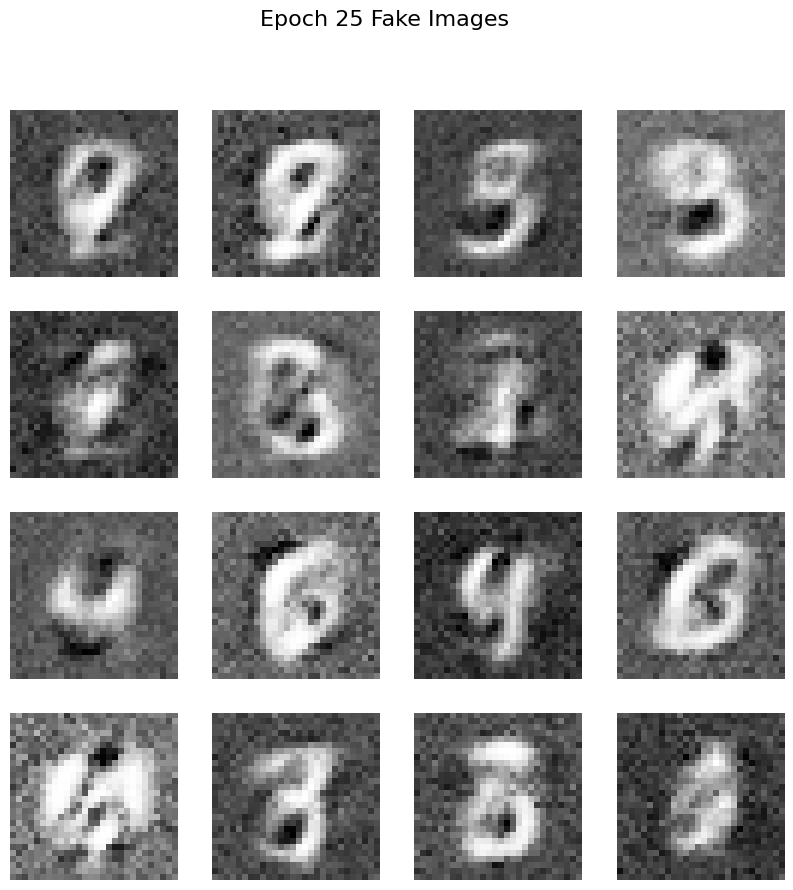

  0%|          | 0/391 [00:00<?, ?it/s]

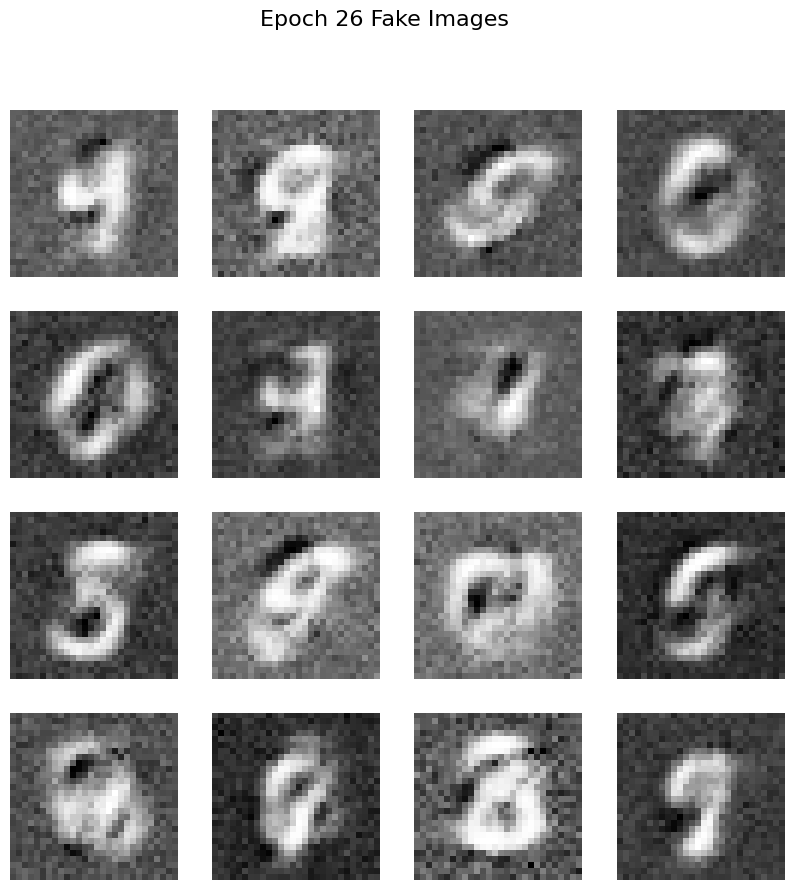

  0%|          | 0/391 [00:00<?, ?it/s]

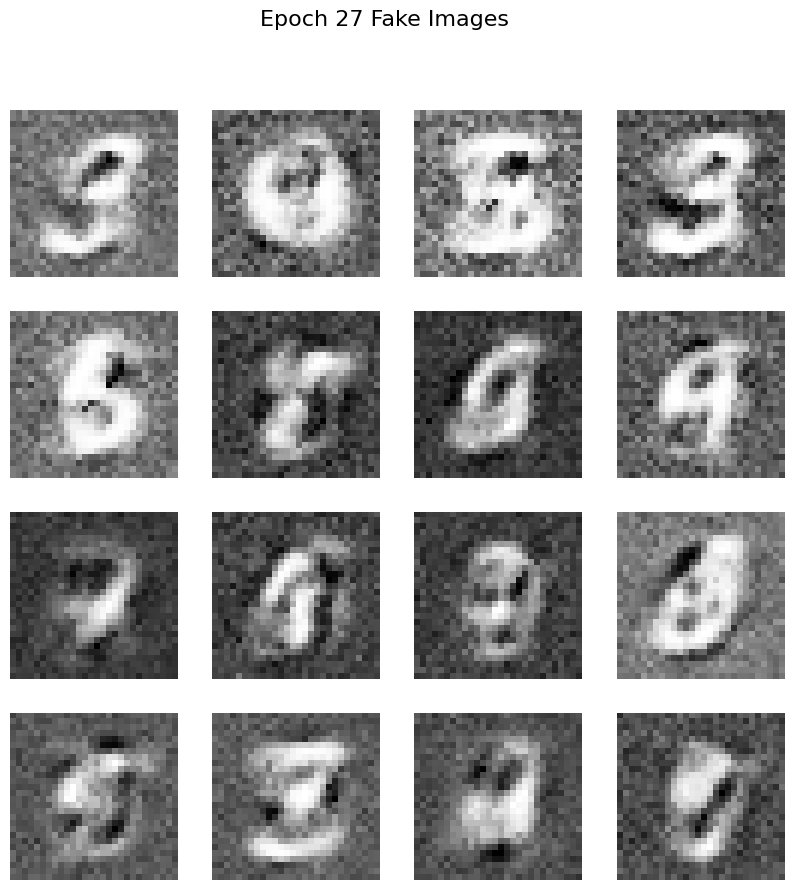

  0%|          | 0/391 [00:00<?, ?it/s]

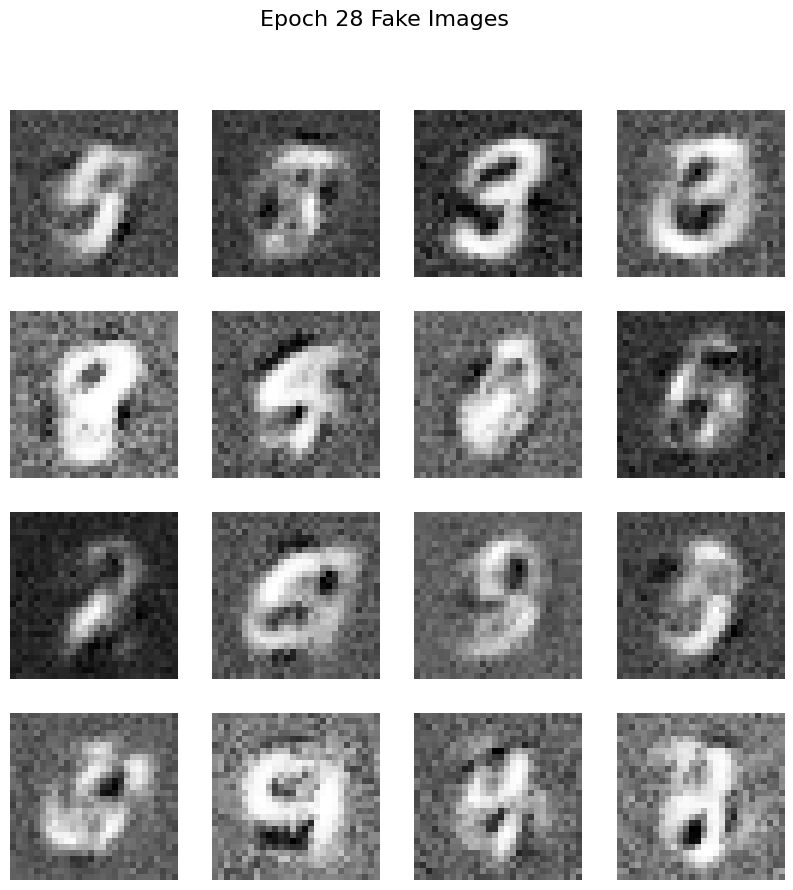

  0%|          | 0/391 [00:00<?, ?it/s]

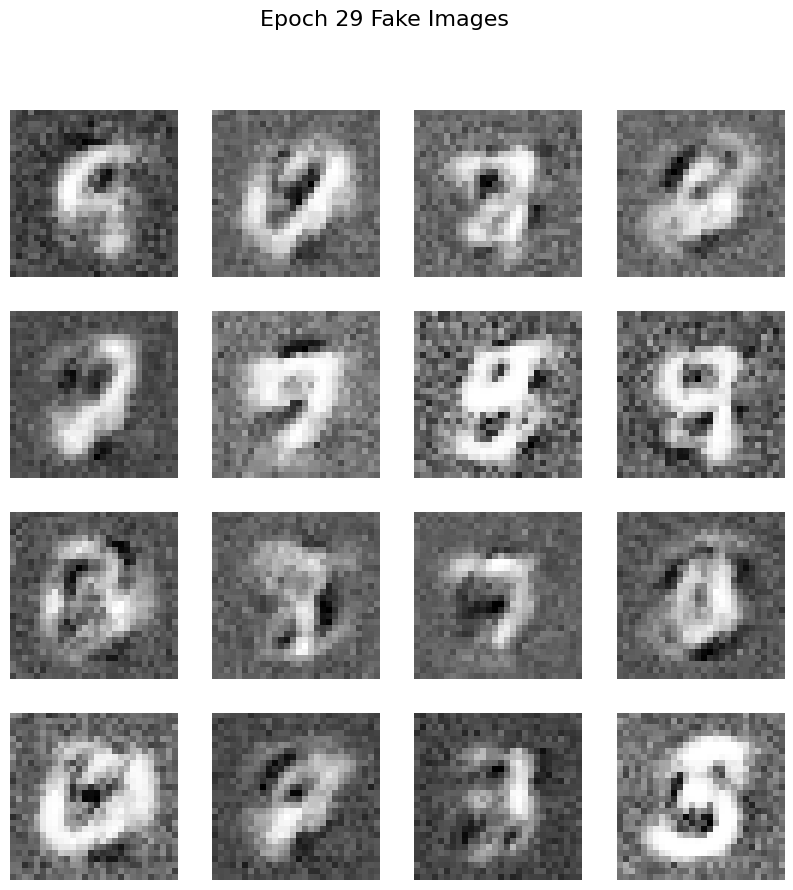

  0%|          | 0/391 [00:00<?, ?it/s]

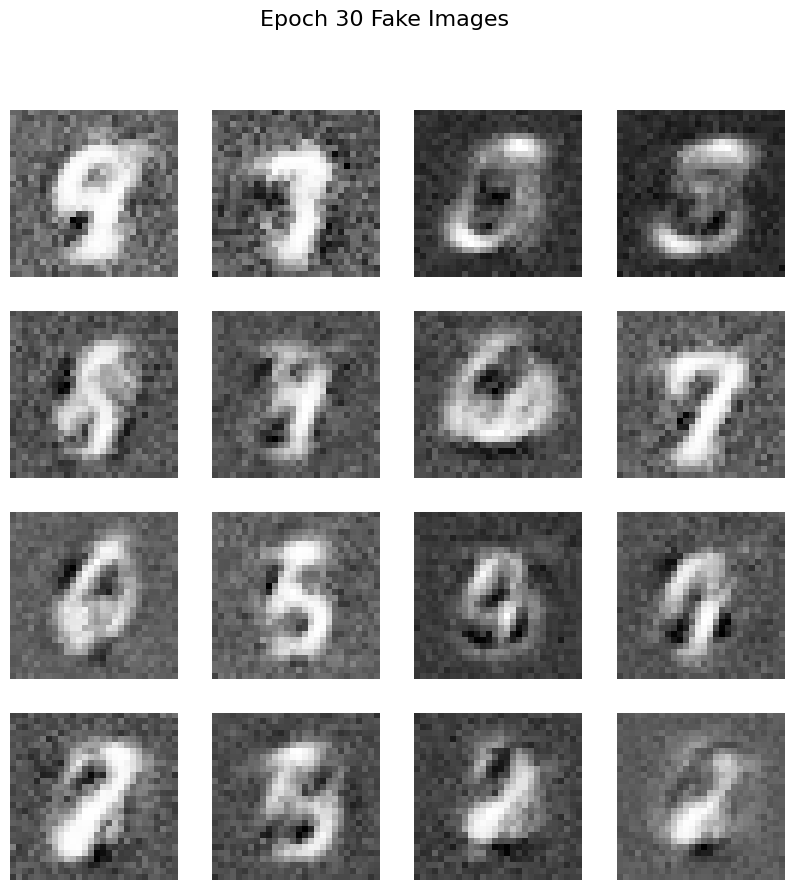

  0%|          | 0/391 [00:00<?, ?it/s]

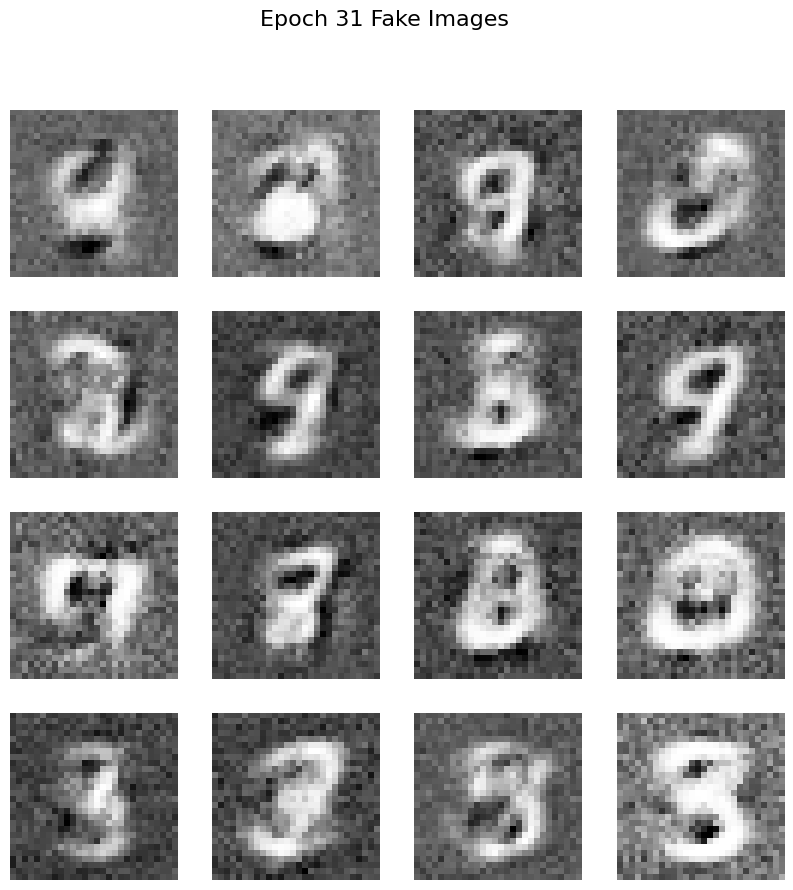

  0%|          | 0/391 [00:00<?, ?it/s]

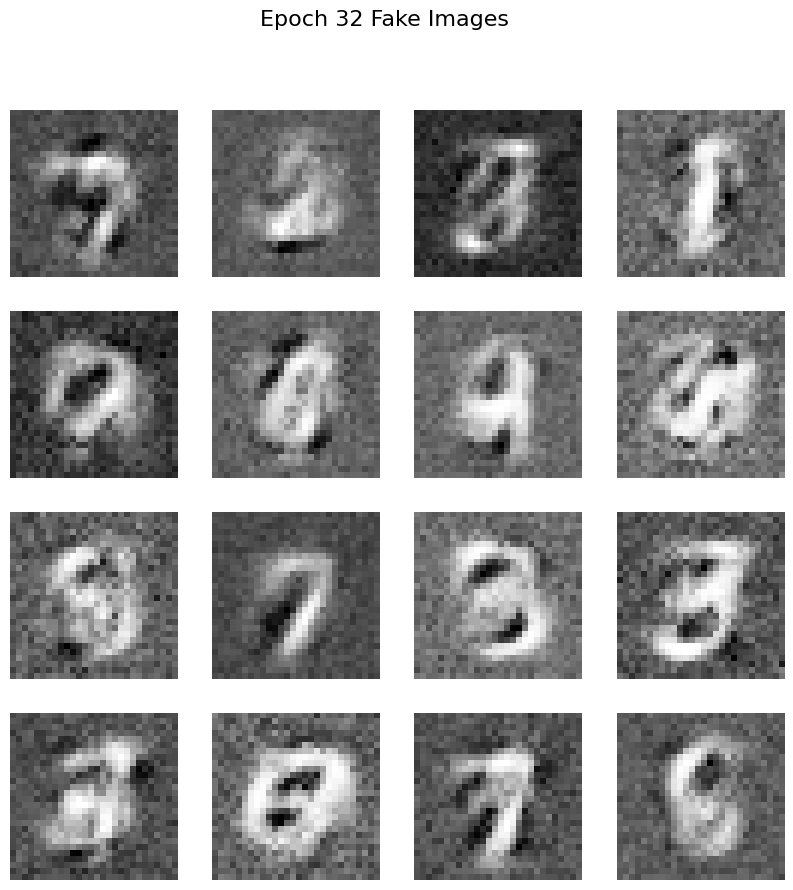

  0%|          | 0/391 [00:00<?, ?it/s]

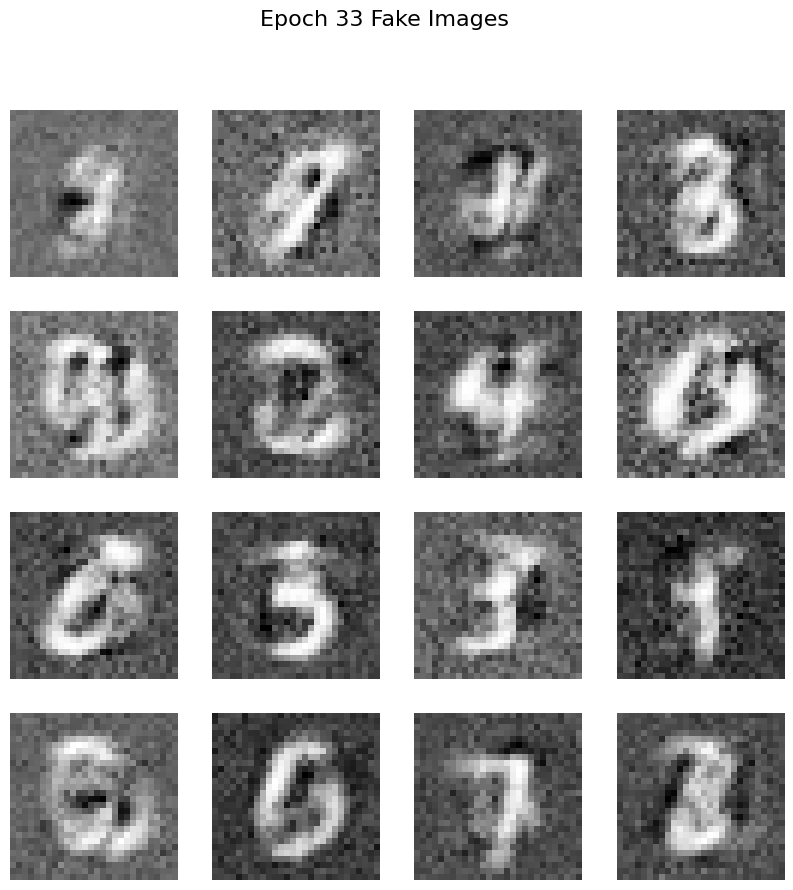

  0%|          | 0/391 [00:00<?, ?it/s]

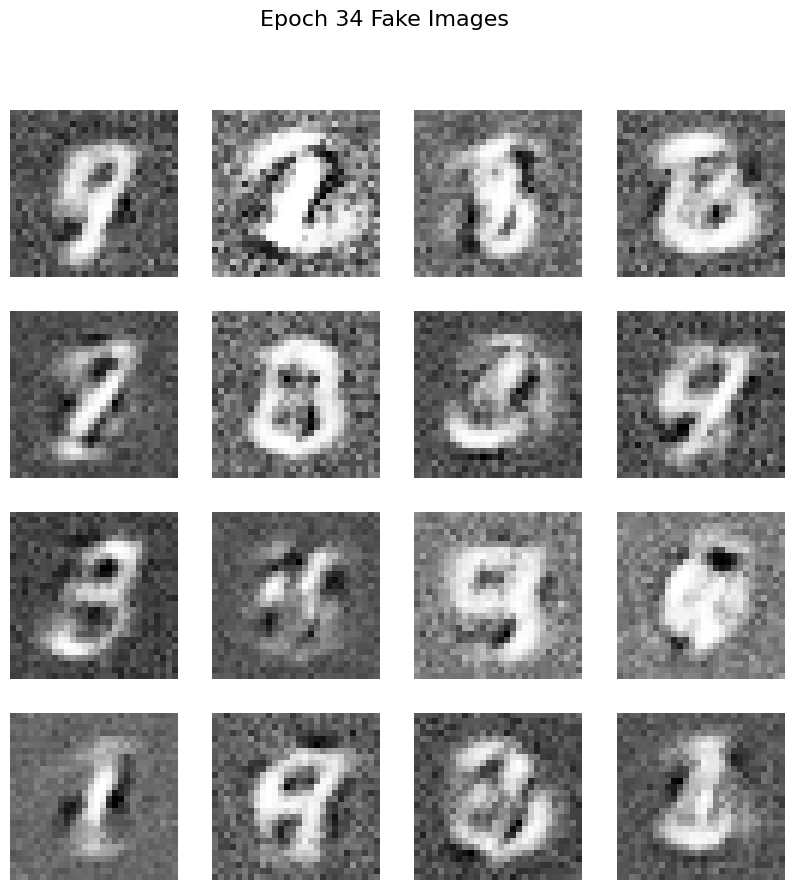

  0%|          | 0/391 [00:00<?, ?it/s]

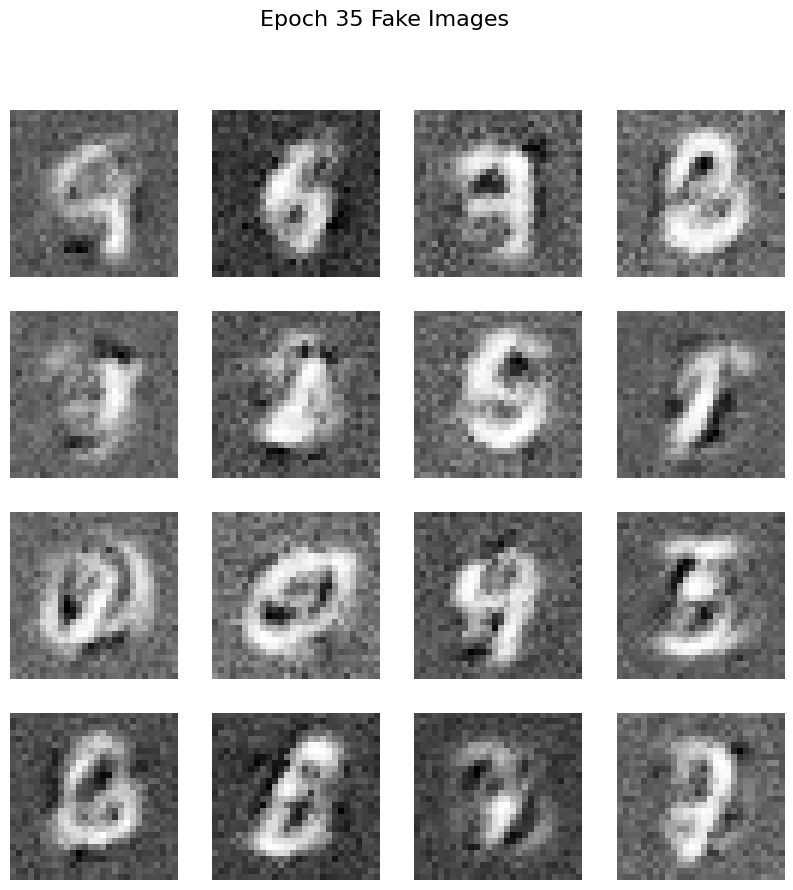

  0%|          | 0/391 [00:00<?, ?it/s]

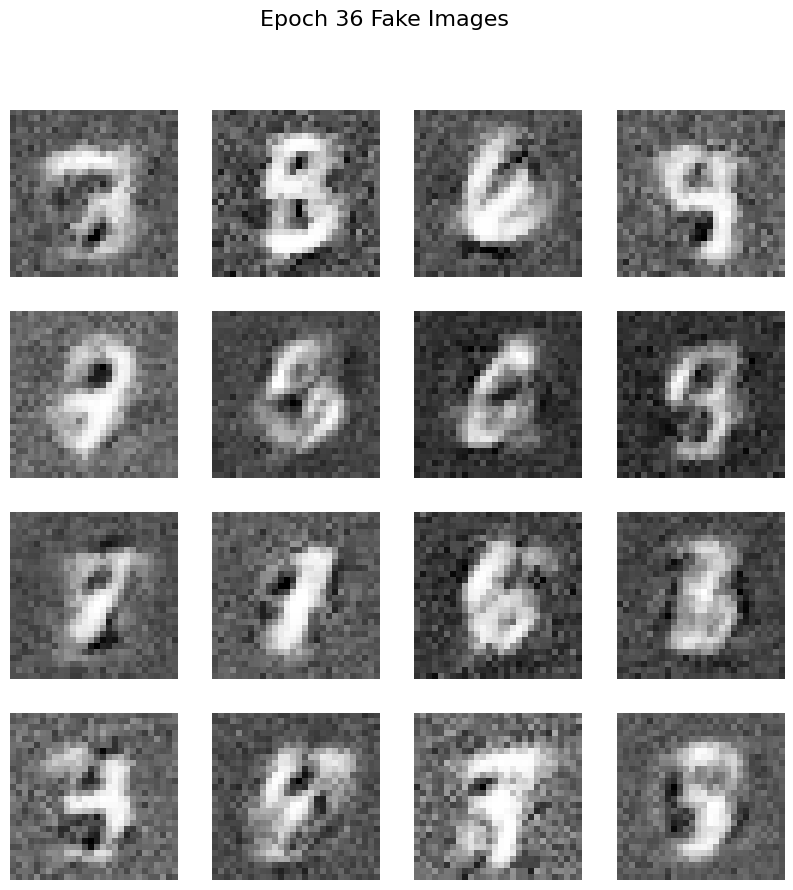

  0%|          | 0/391 [00:00<?, ?it/s]

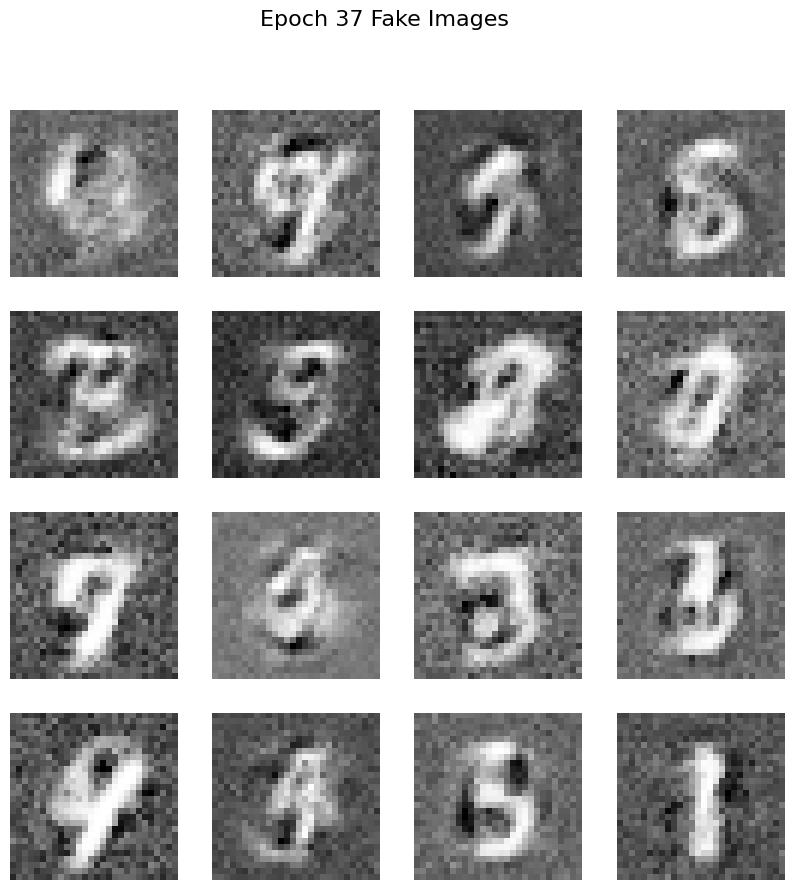

  0%|          | 0/391 [00:00<?, ?it/s]

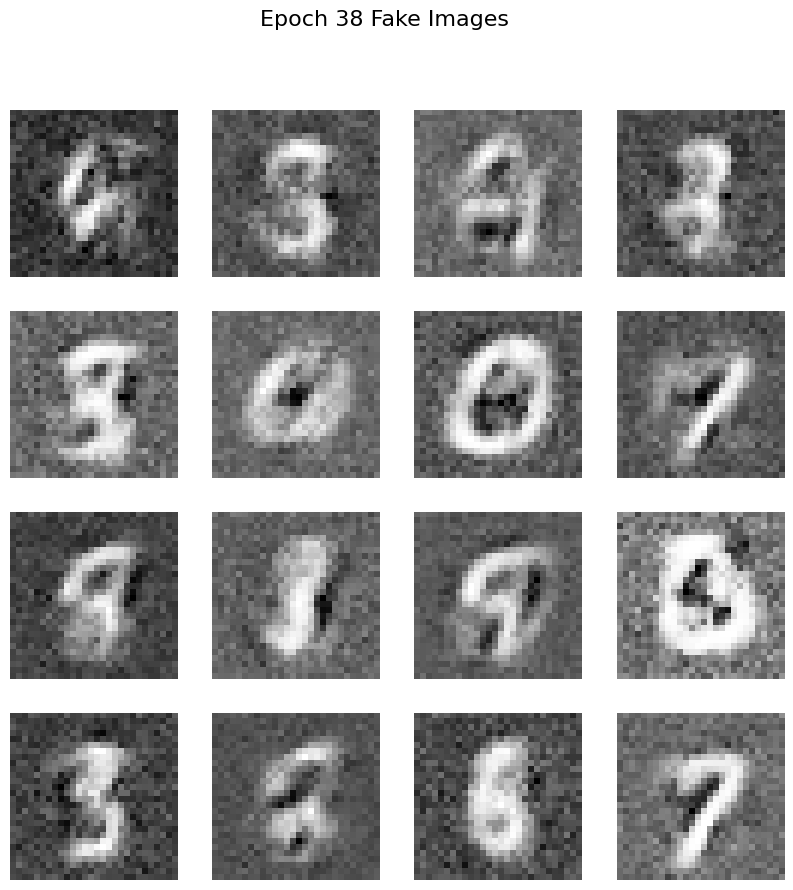

  0%|          | 0/391 [00:00<?, ?it/s]

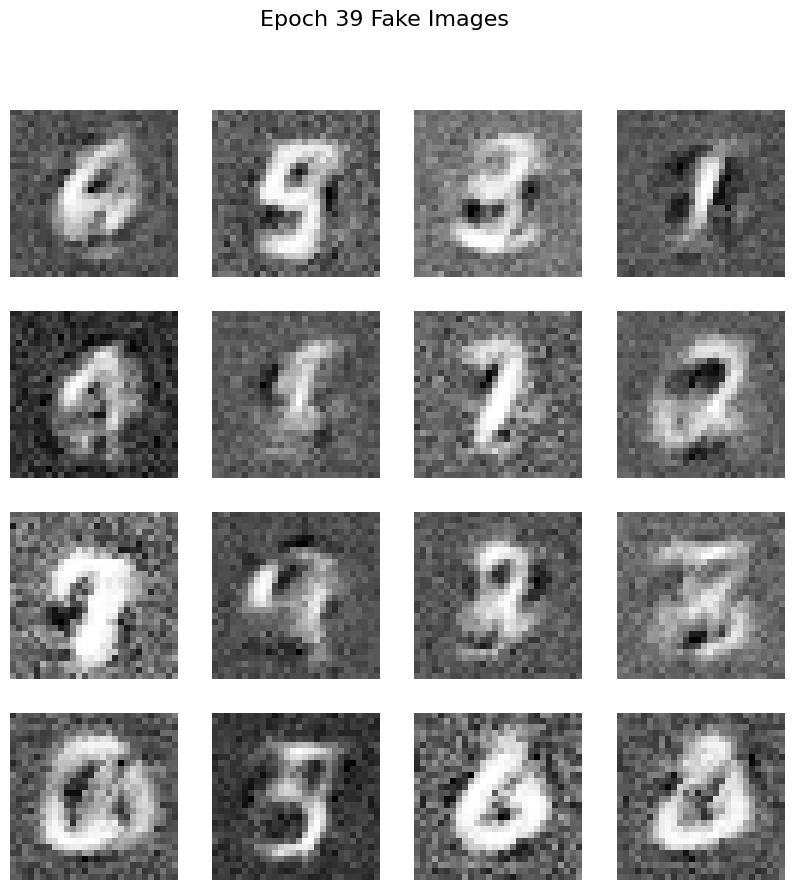

  0%|          | 0/391 [00:00<?, ?it/s]

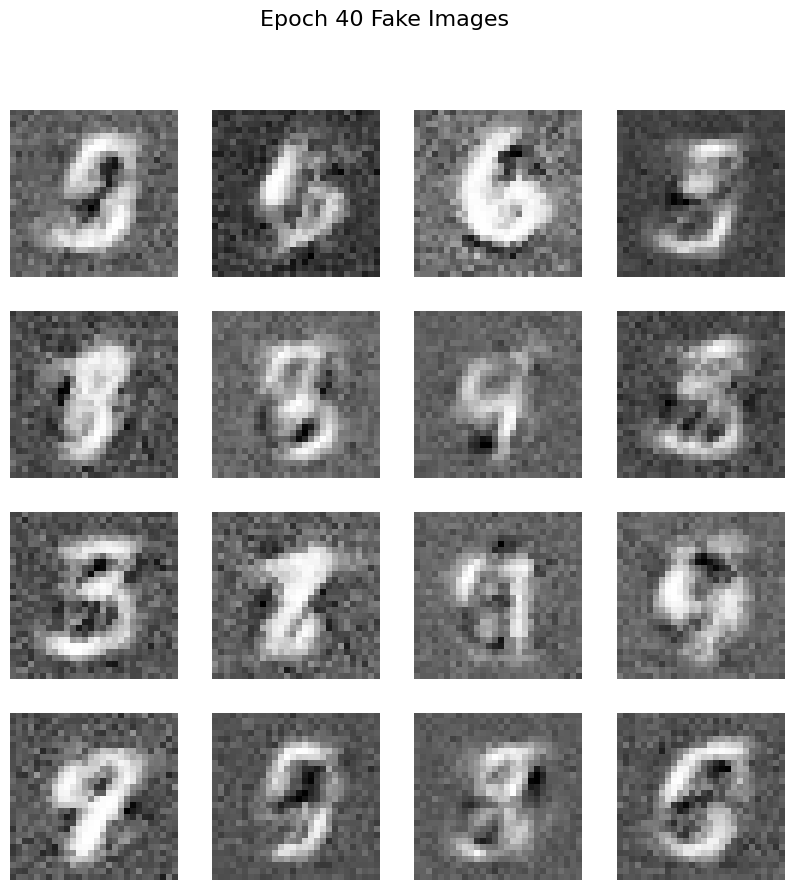

  0%|          | 0/391 [00:00<?, ?it/s]

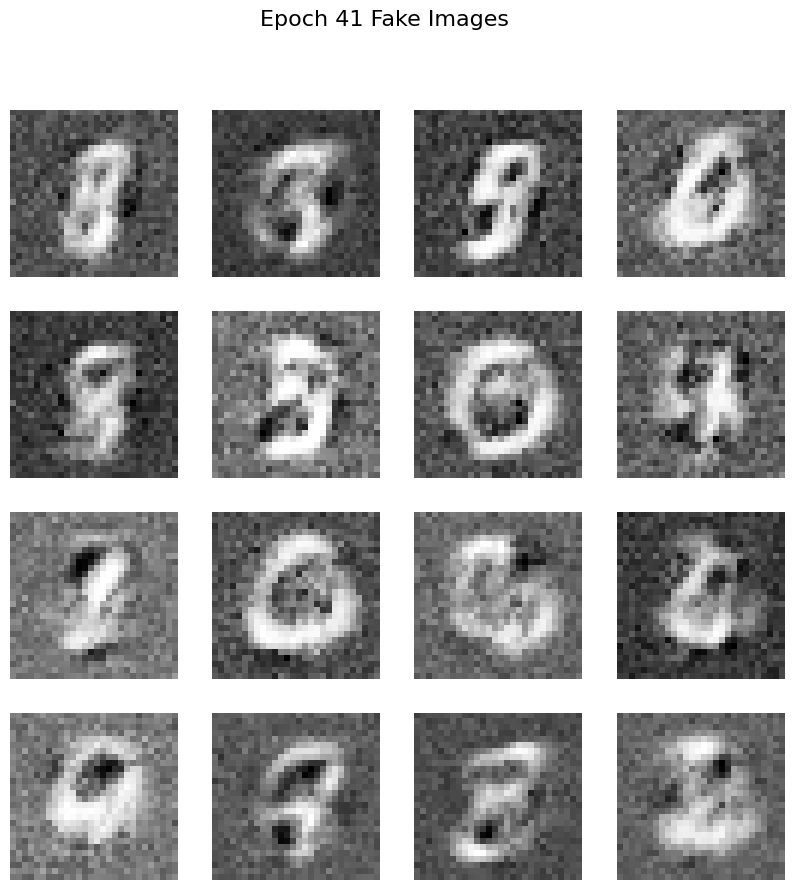

  0%|          | 0/391 [00:00<?, ?it/s]

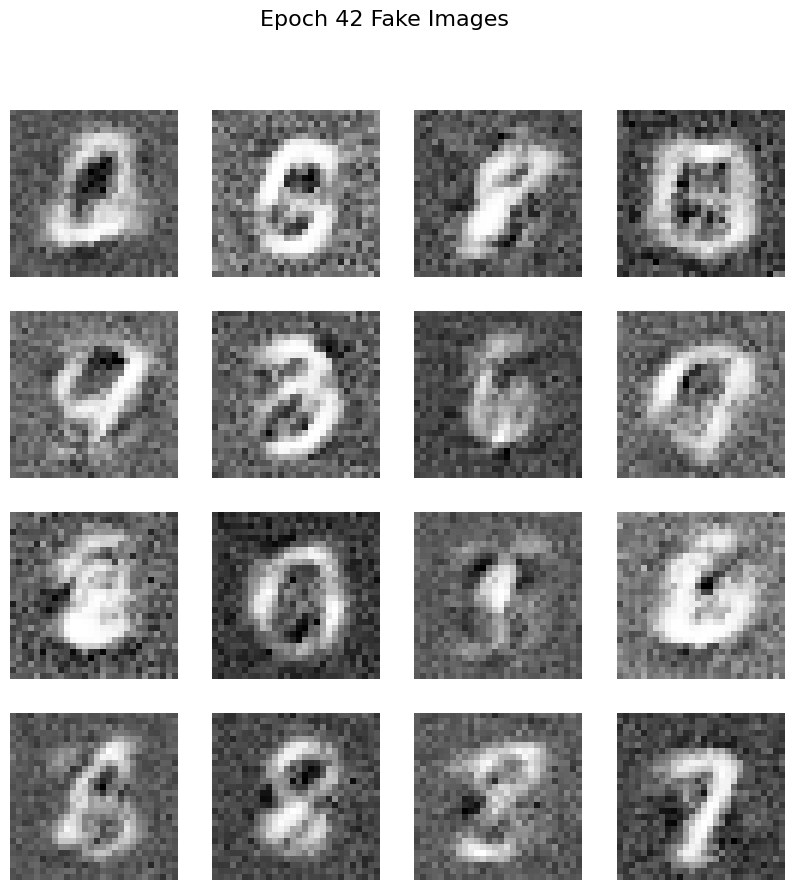

  0%|          | 0/391 [00:00<?, ?it/s]

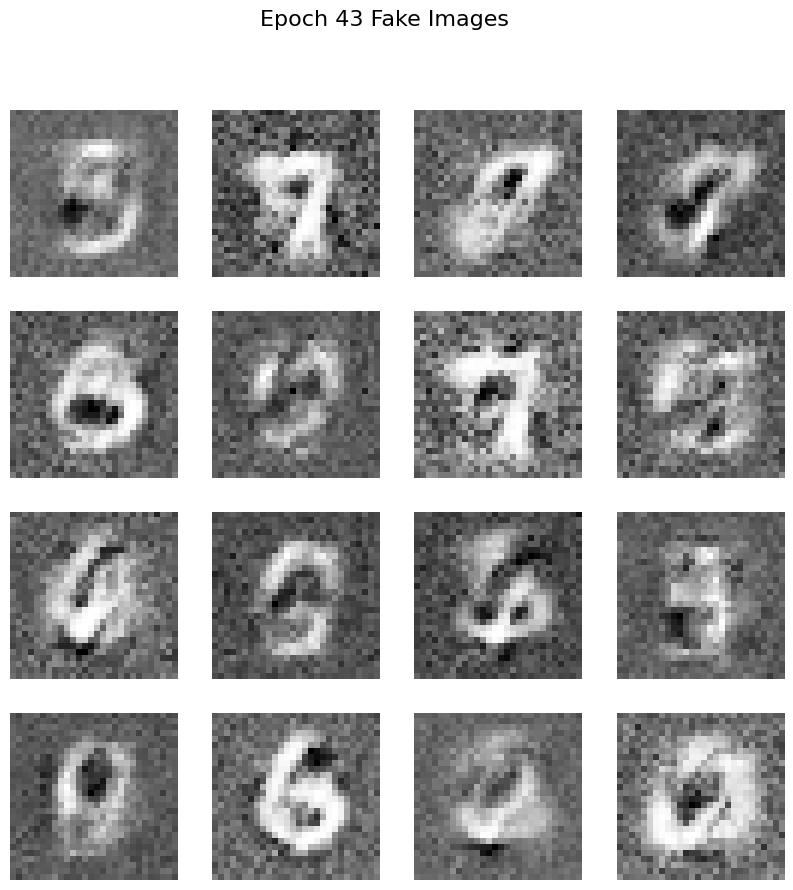

  0%|          | 0/391 [00:00<?, ?it/s]

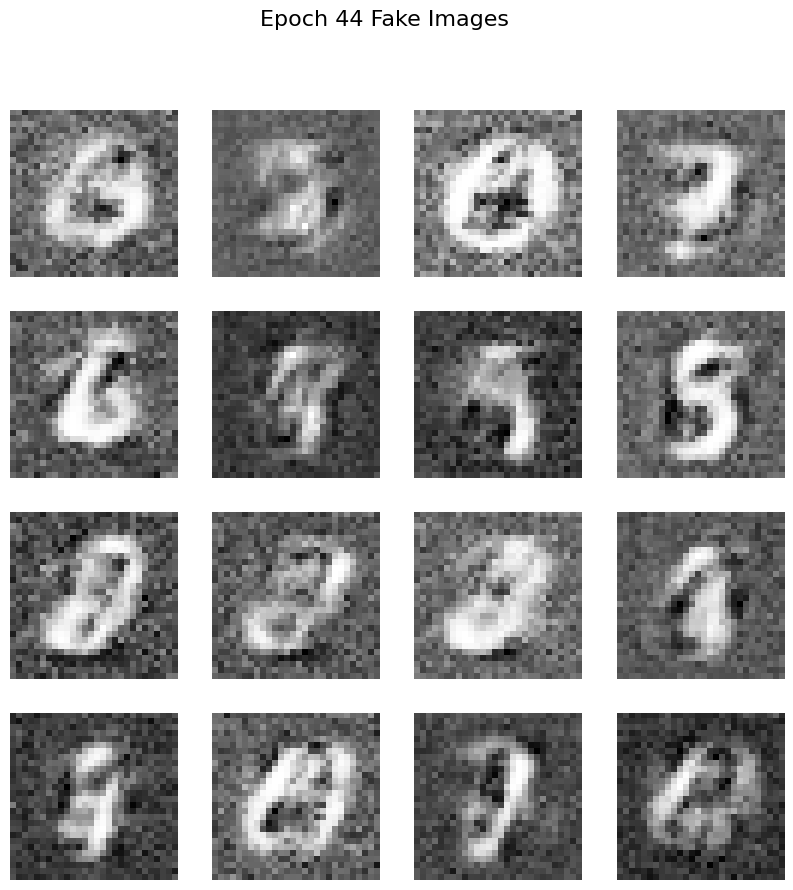

  0%|          | 0/391 [00:00<?, ?it/s]

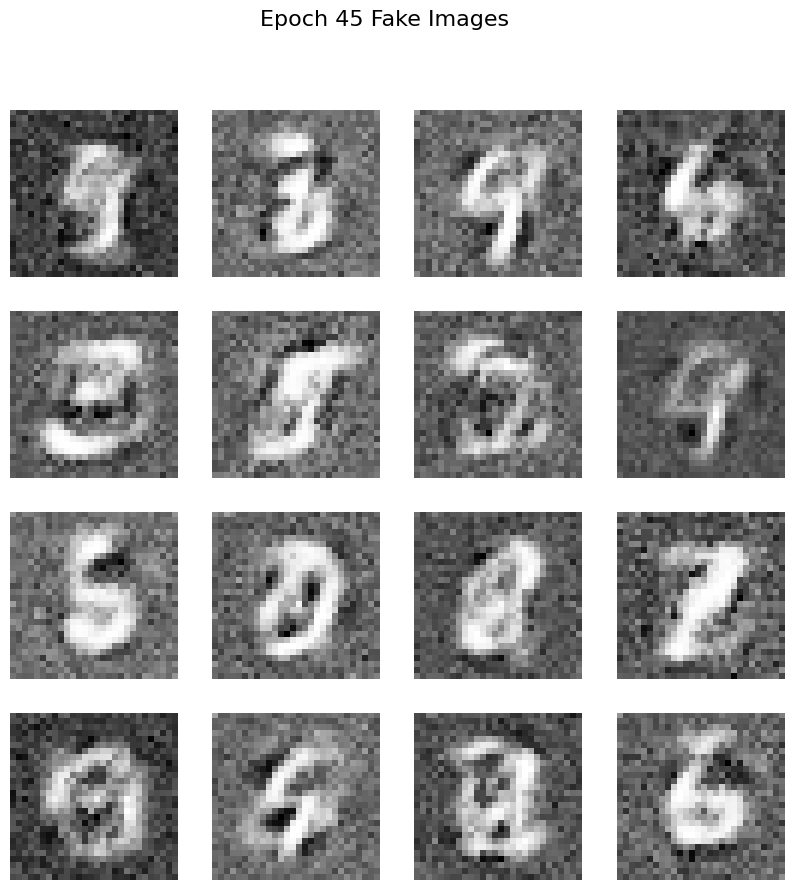

  0%|          | 0/391 [00:00<?, ?it/s]

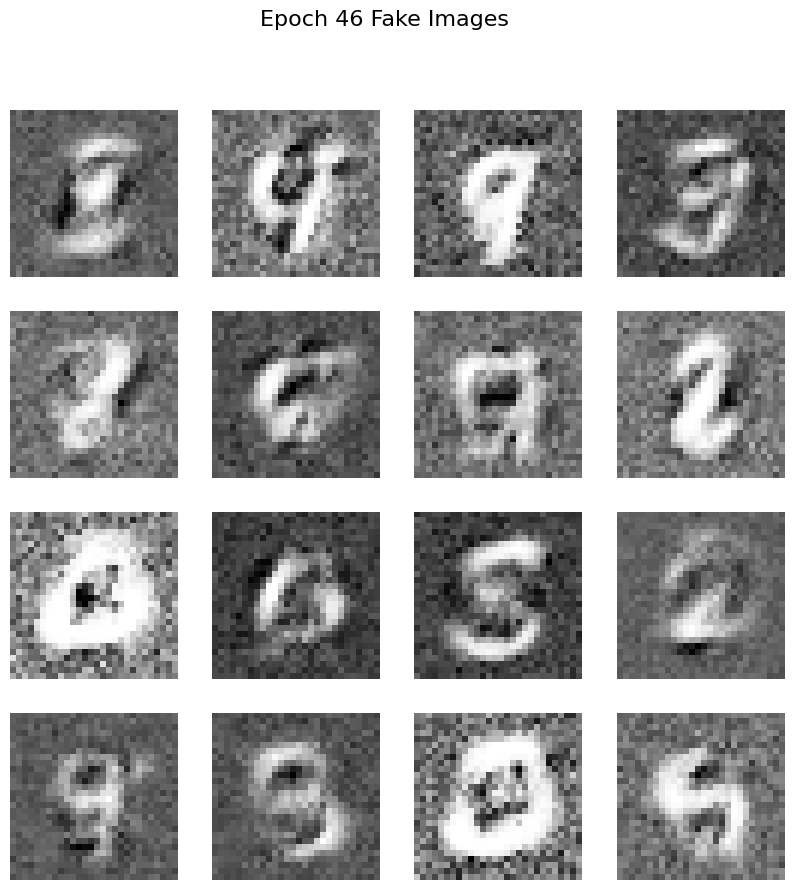

  0%|          | 0/391 [00:00<?, ?it/s]

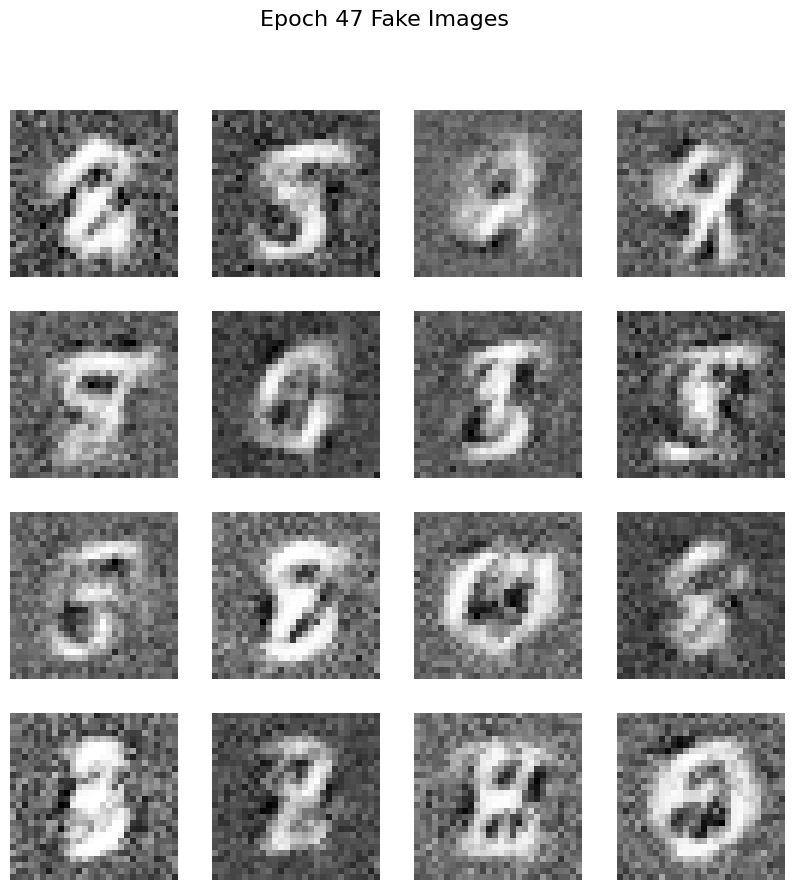

  0%|          | 0/391 [00:00<?, ?it/s]

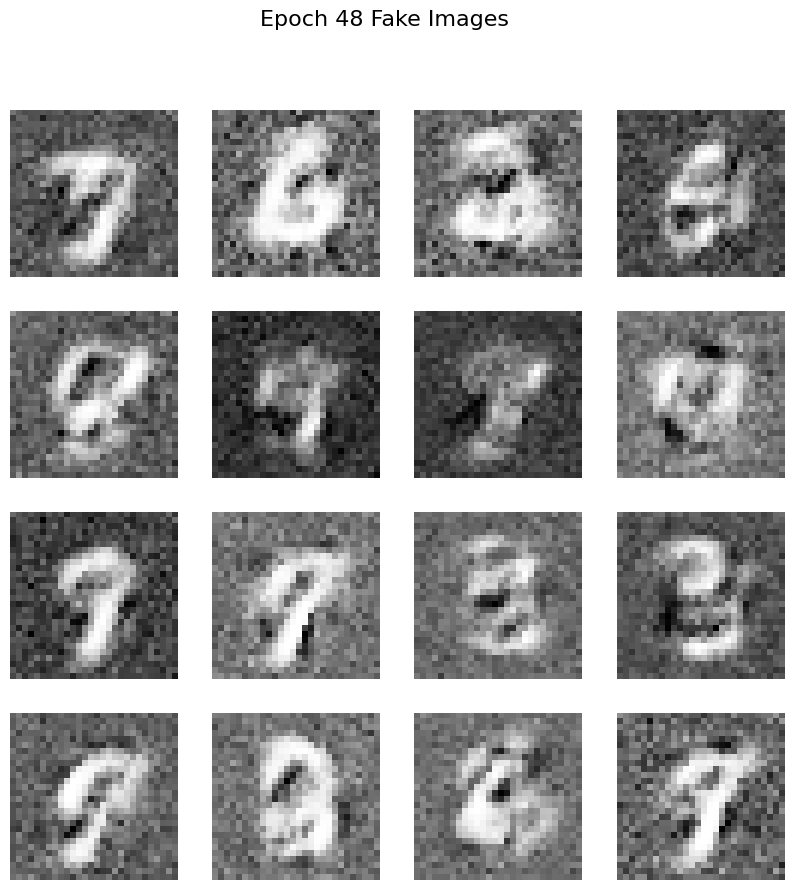

  0%|          | 0/391 [00:00<?, ?it/s]

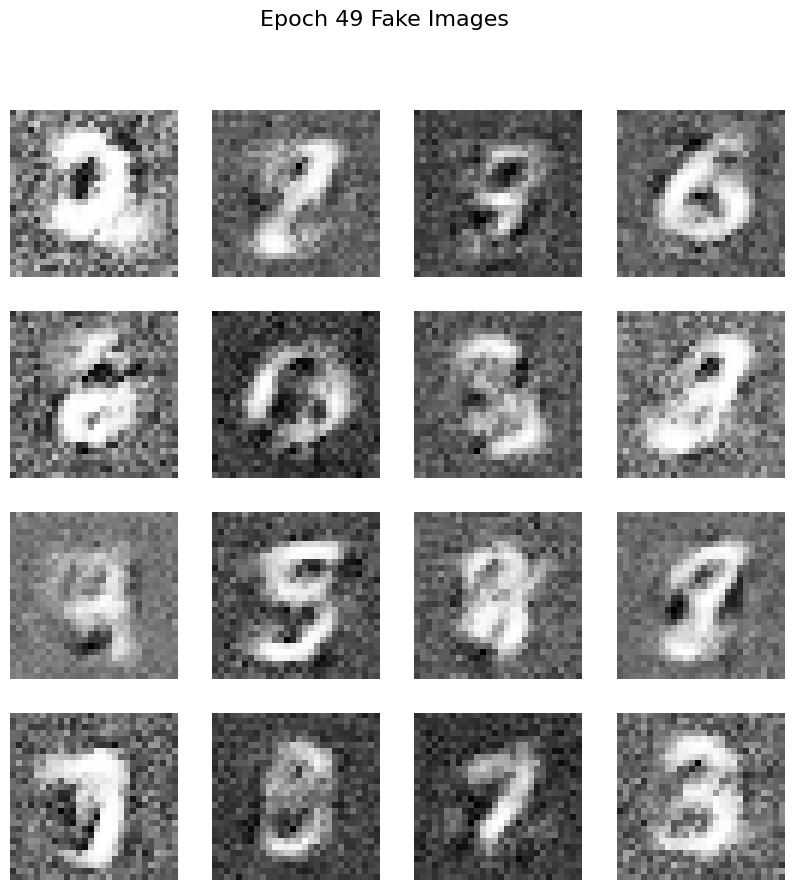

  0%|          | 0/391 [00:00<?, ?it/s]

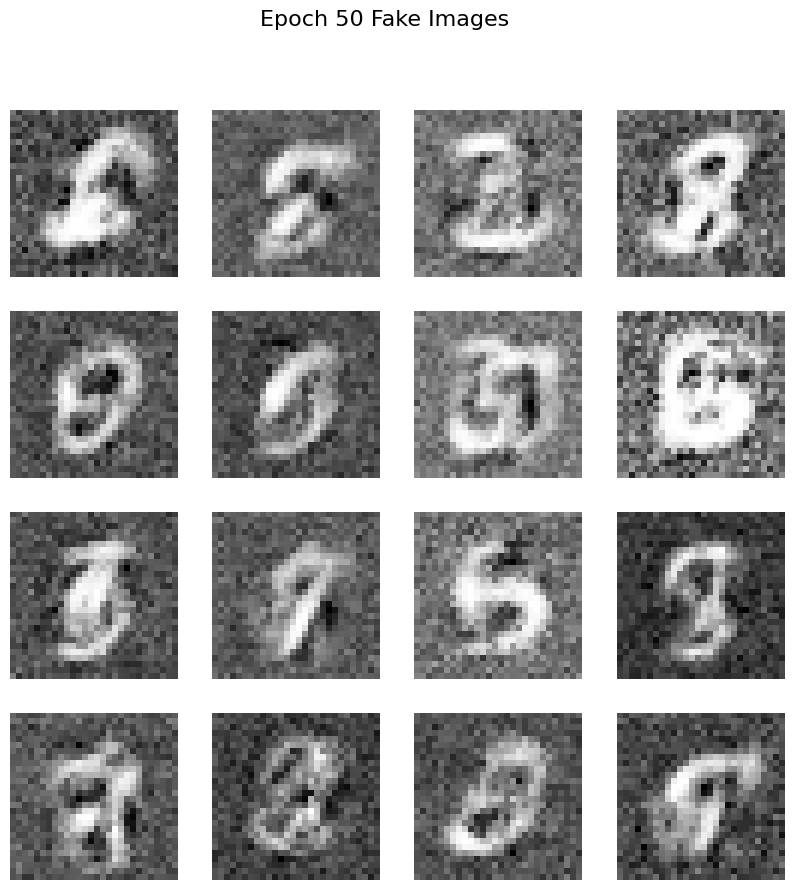

  0%|          | 0/391 [00:00<?, ?it/s]

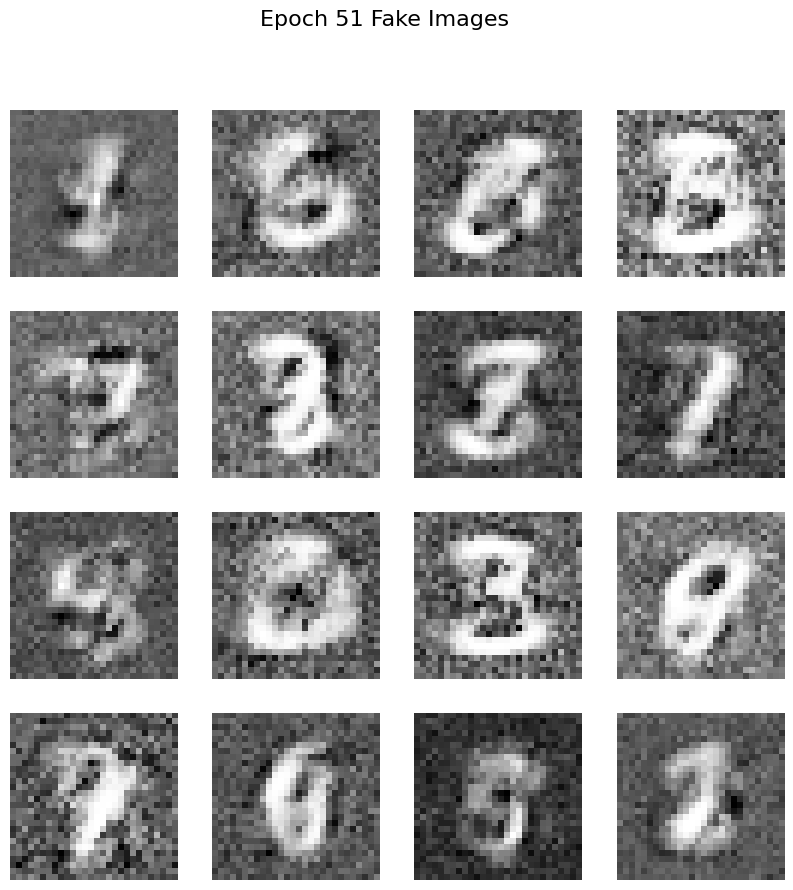

  0%|          | 0/391 [00:00<?, ?it/s]

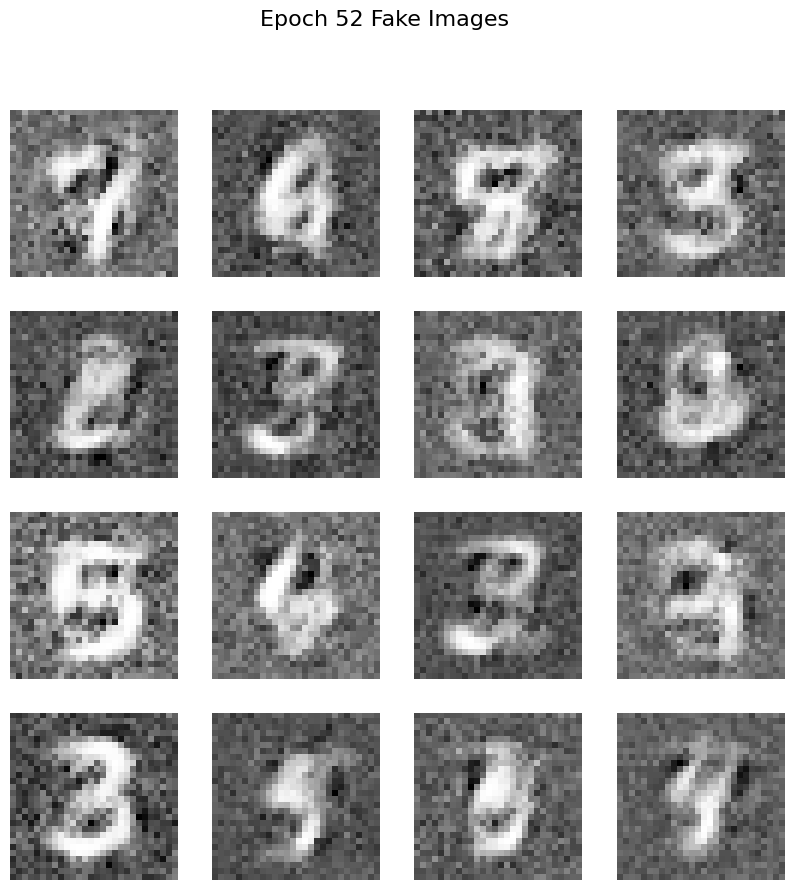

  0%|          | 0/391 [00:00<?, ?it/s]

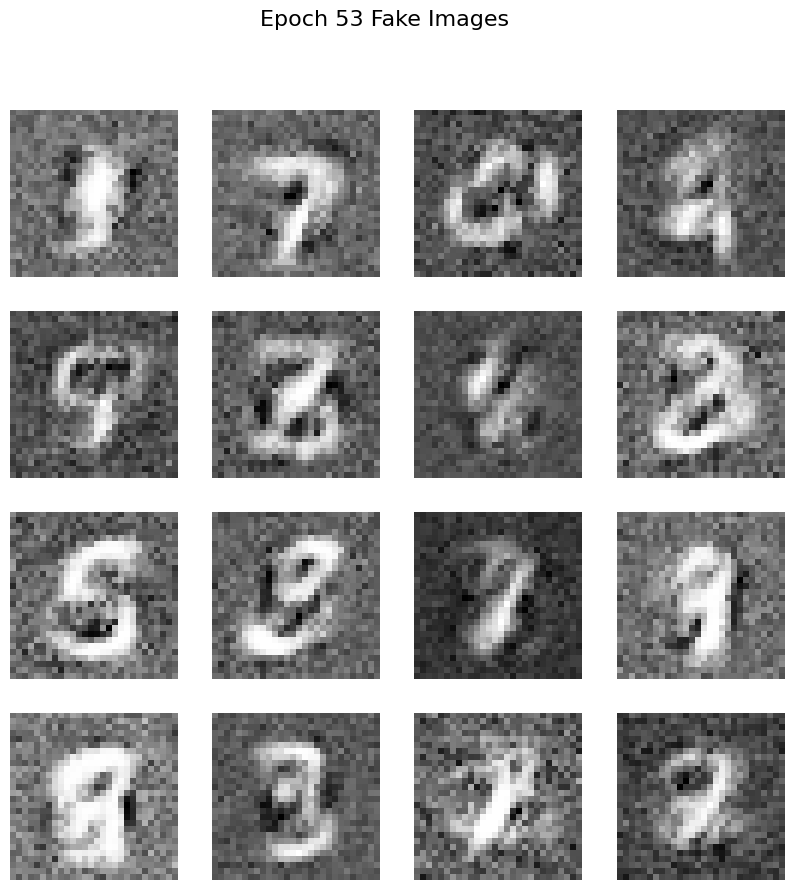

  0%|          | 0/391 [00:00<?, ?it/s]

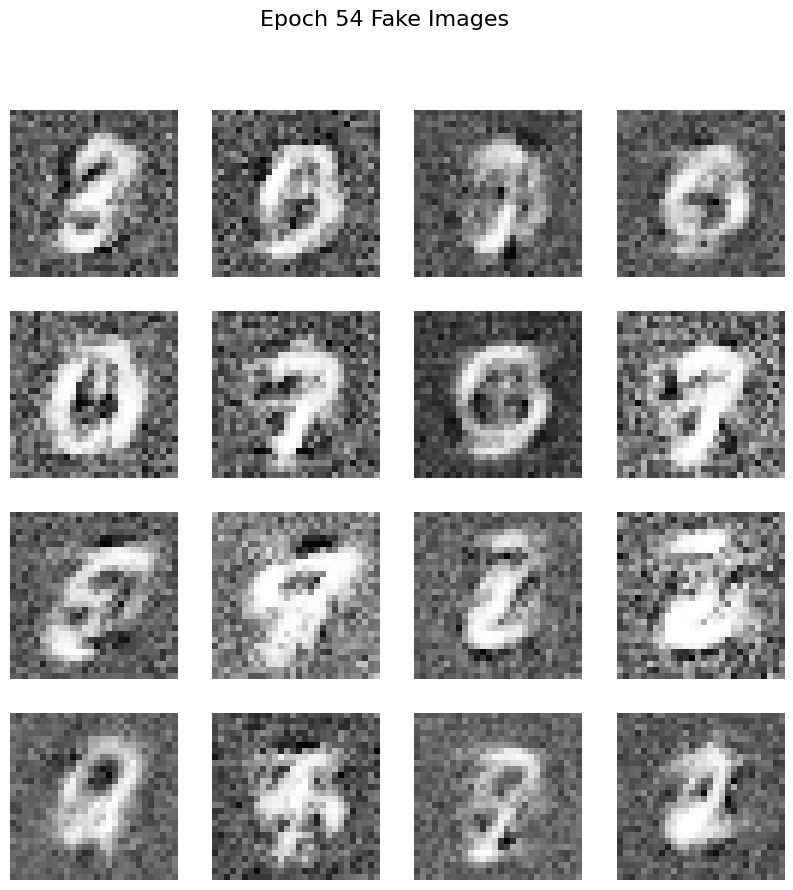

  0%|          | 0/391 [00:00<?, ?it/s]

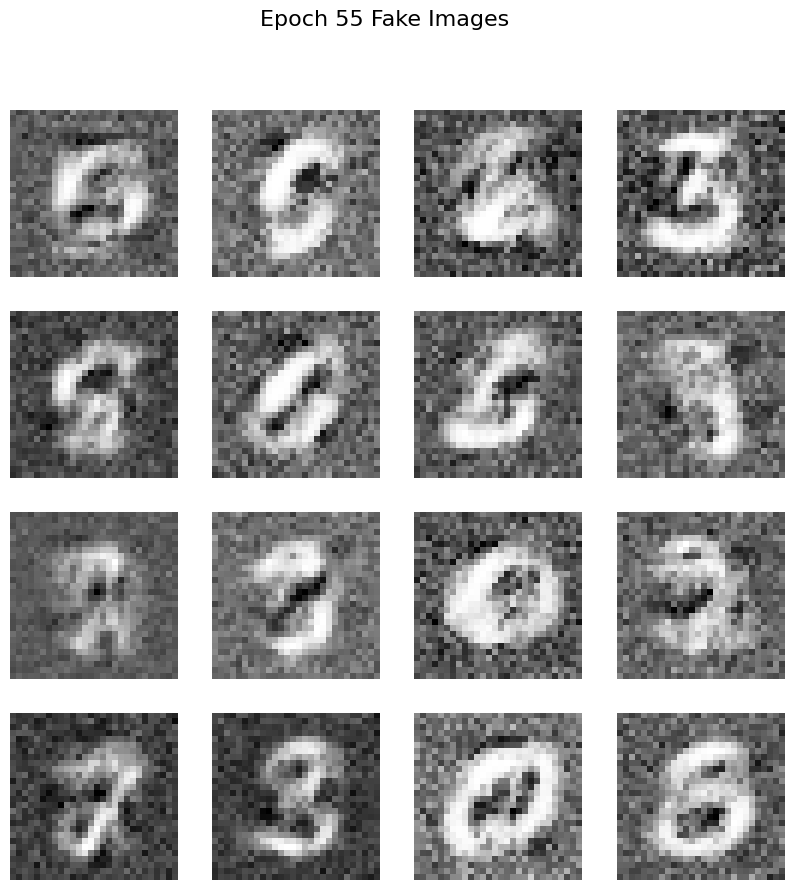

  0%|          | 0/391 [00:00<?, ?it/s]

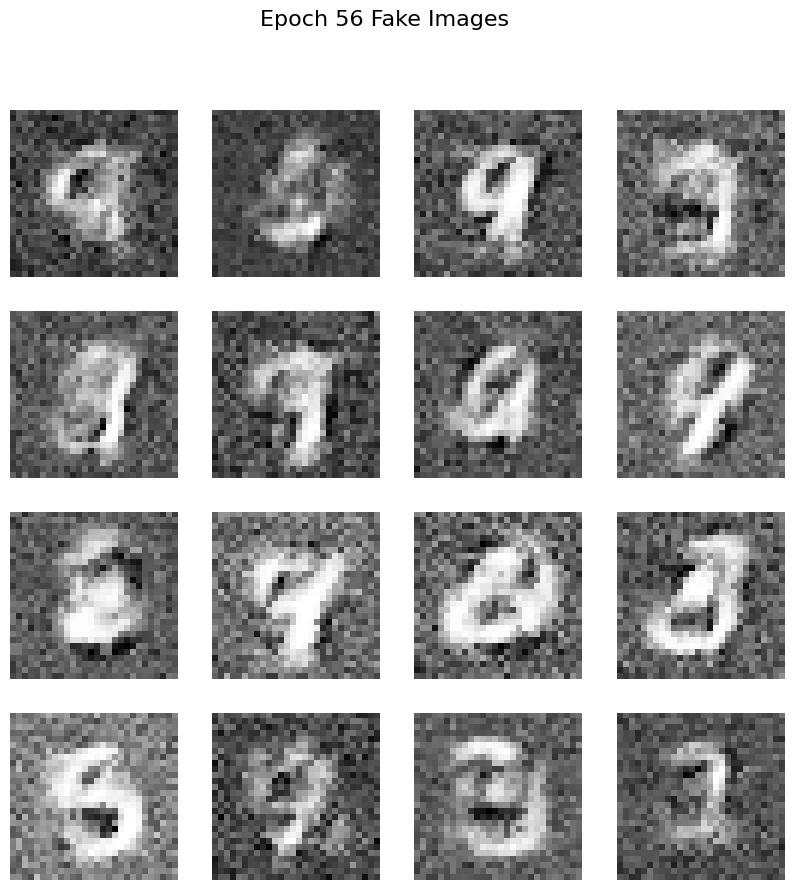

  0%|          | 0/391 [00:00<?, ?it/s]

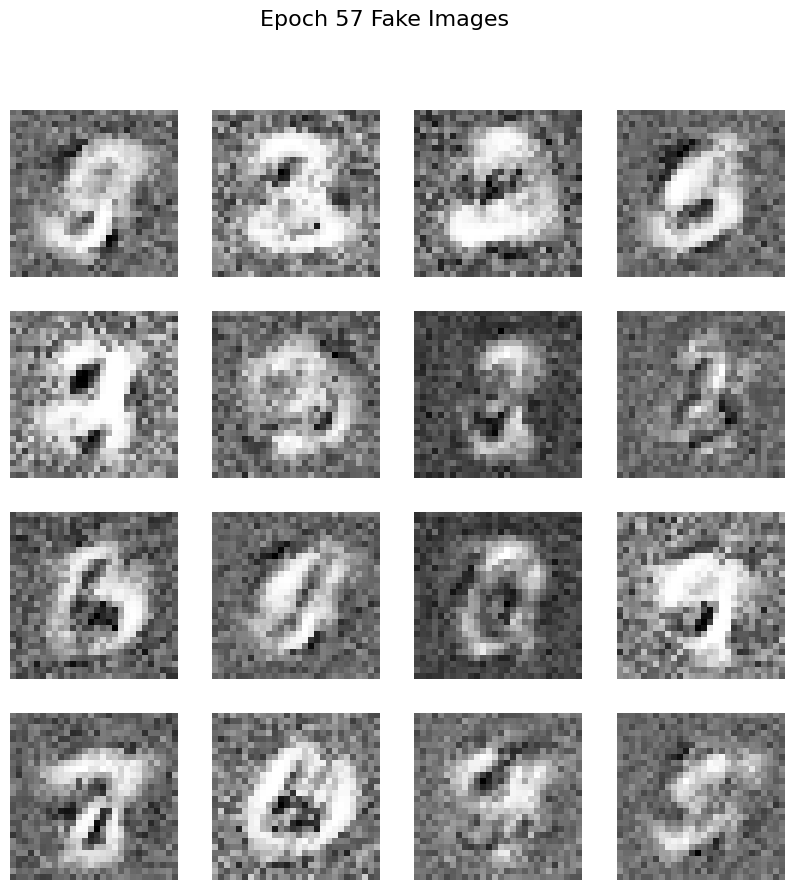

  0%|          | 0/391 [00:00<?, ?it/s]

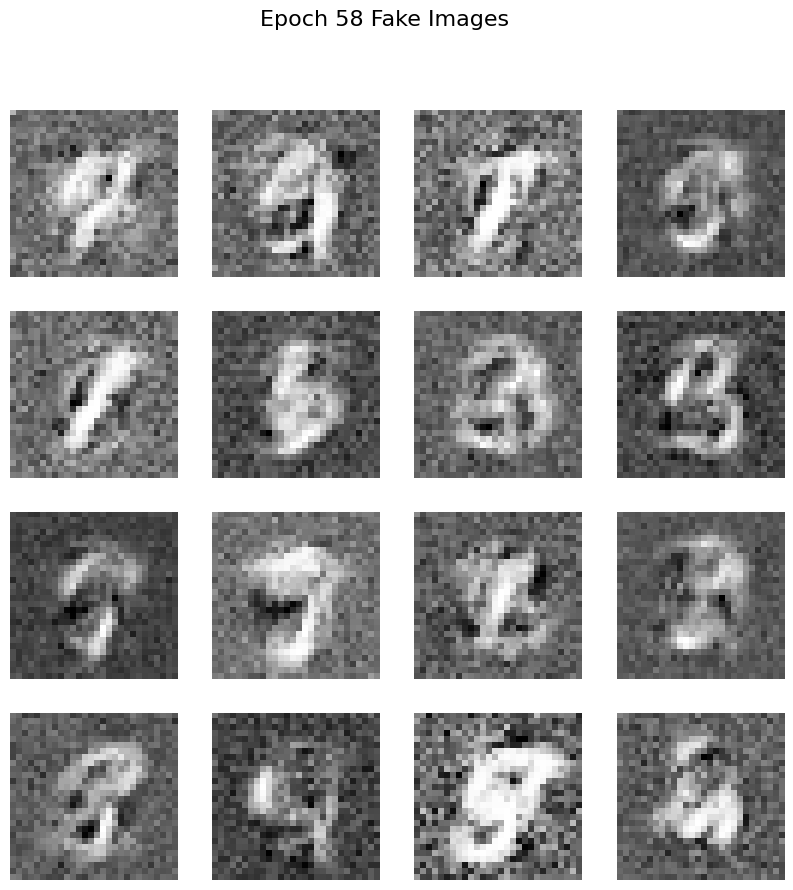

  0%|          | 0/391 [00:00<?, ?it/s]

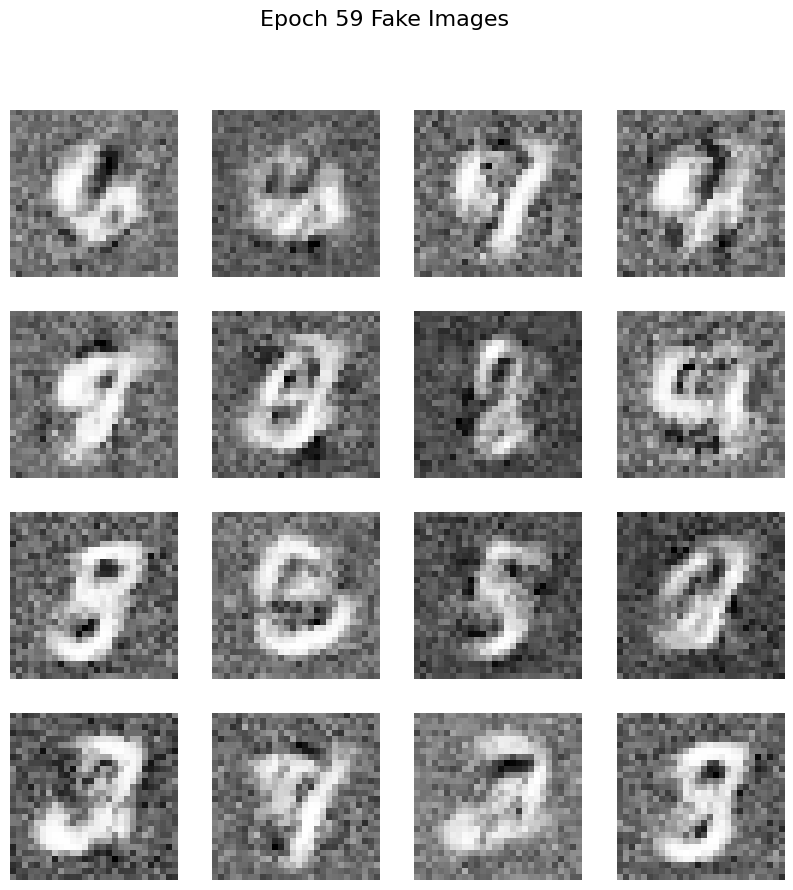

  0%|          | 0/391 [00:00<?, ?it/s]

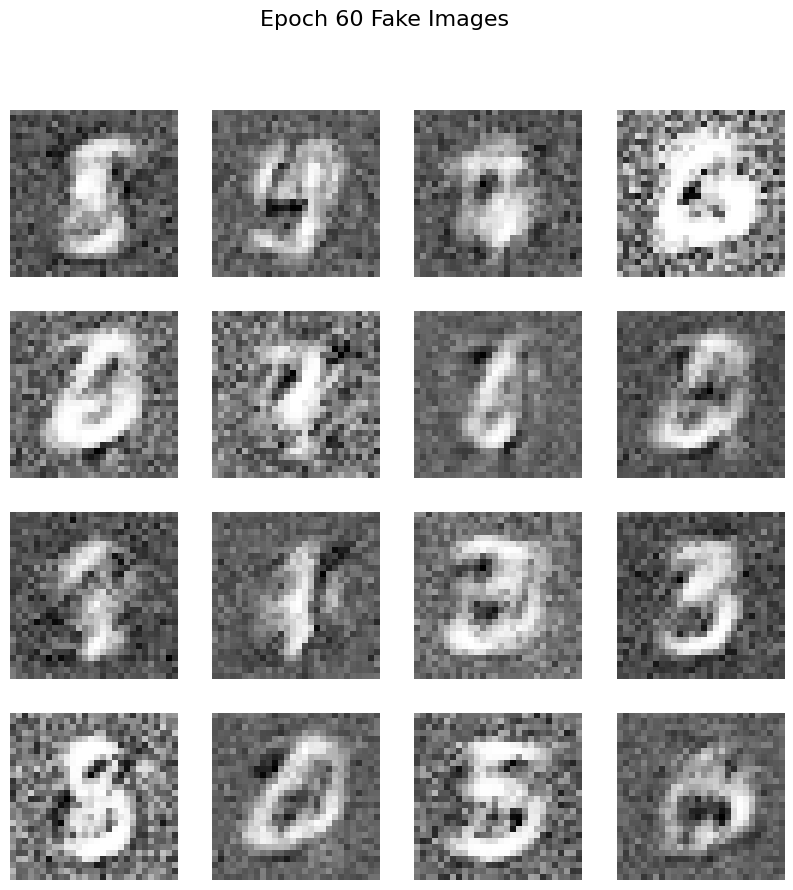

  0%|          | 0/391 [00:00<?, ?it/s]

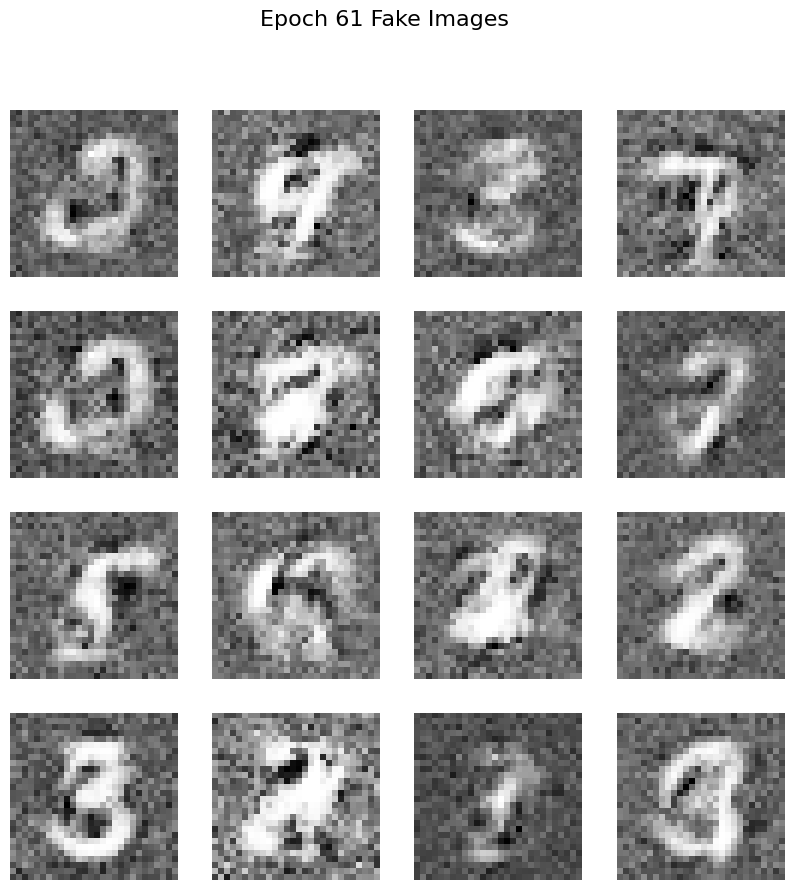

  0%|          | 0/391 [00:00<?, ?it/s]

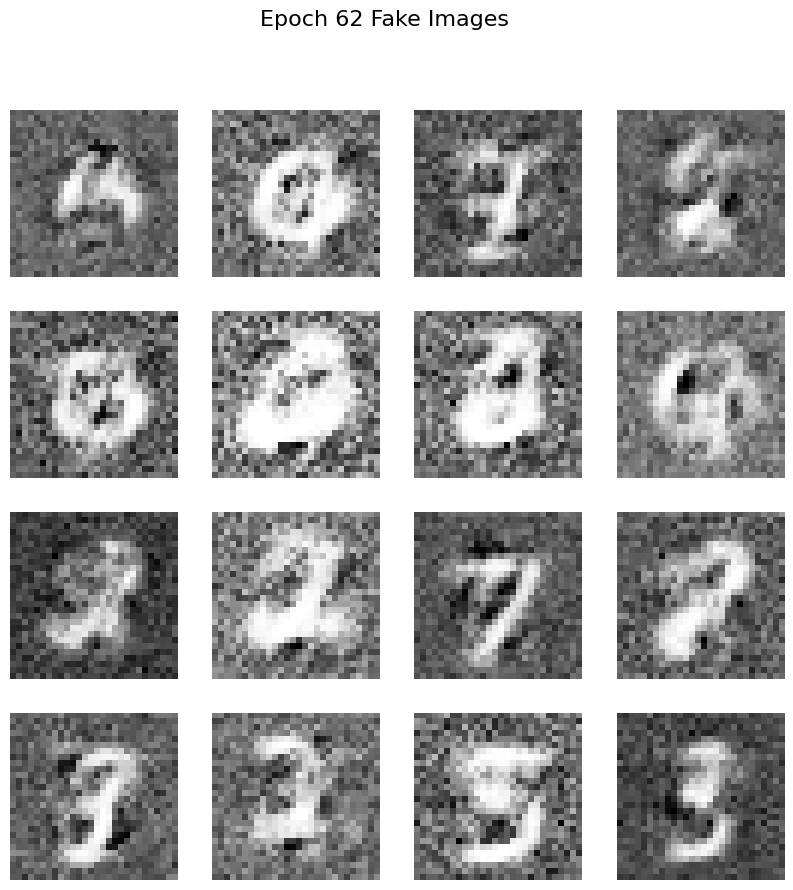

  0%|          | 0/391 [00:00<?, ?it/s]

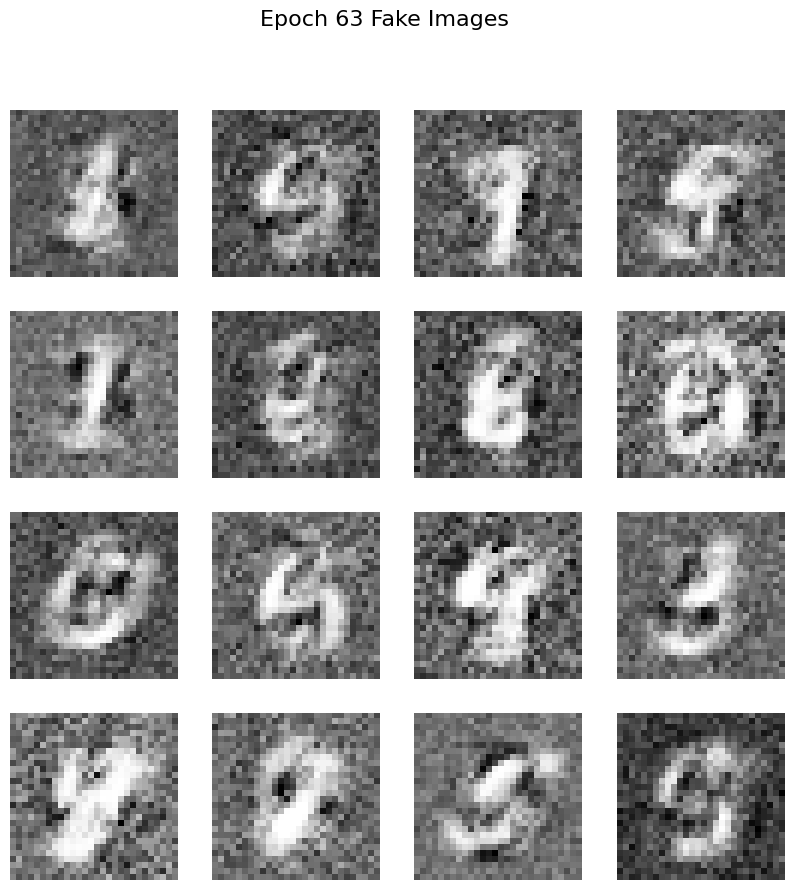

  0%|          | 0/391 [00:00<?, ?it/s]

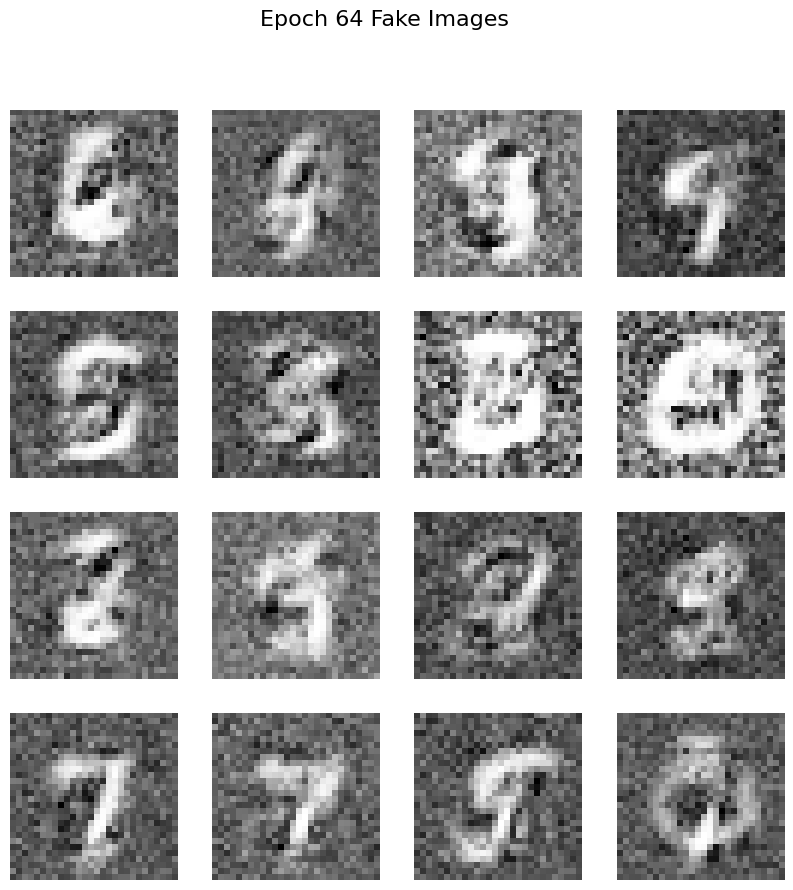

  0%|          | 0/391 [00:00<?, ?it/s]

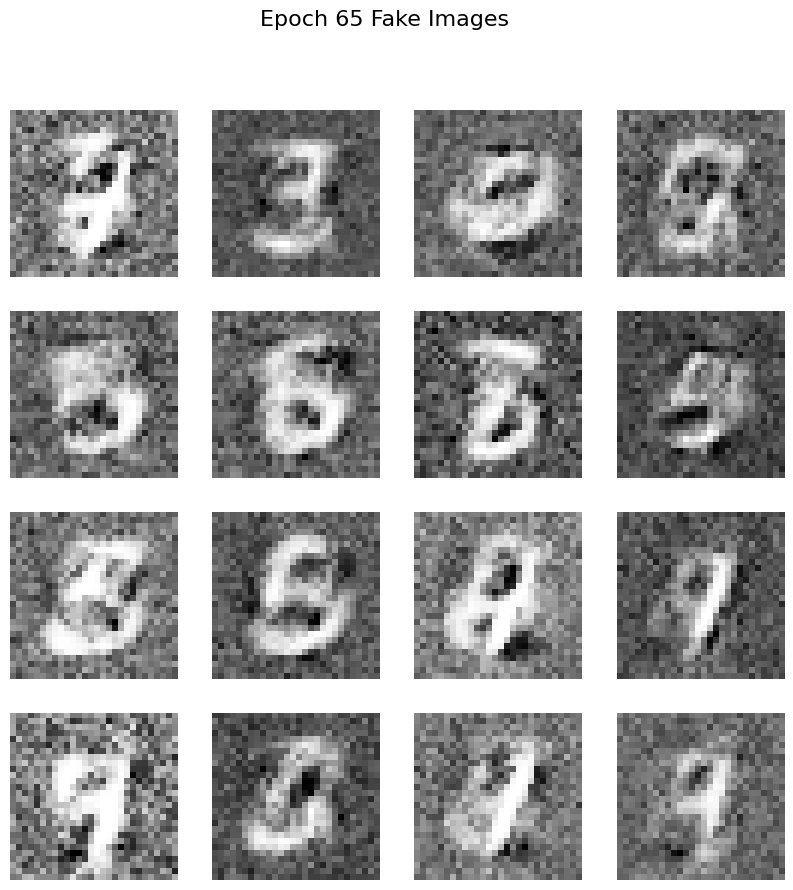

  0%|          | 0/391 [00:00<?, ?it/s]

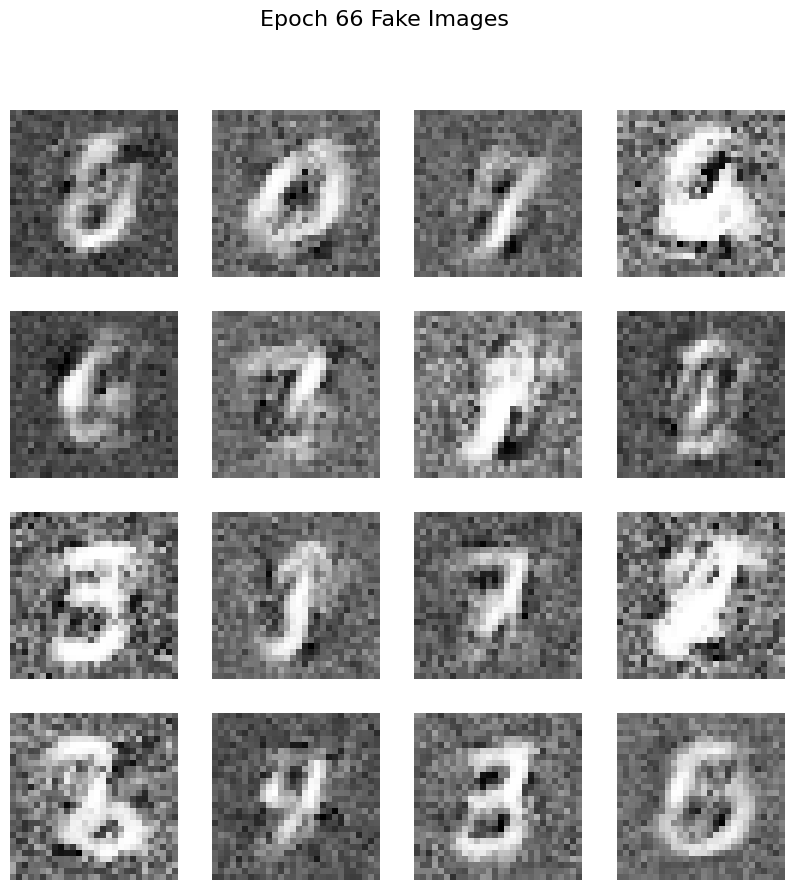

  0%|          | 0/391 [00:00<?, ?it/s]

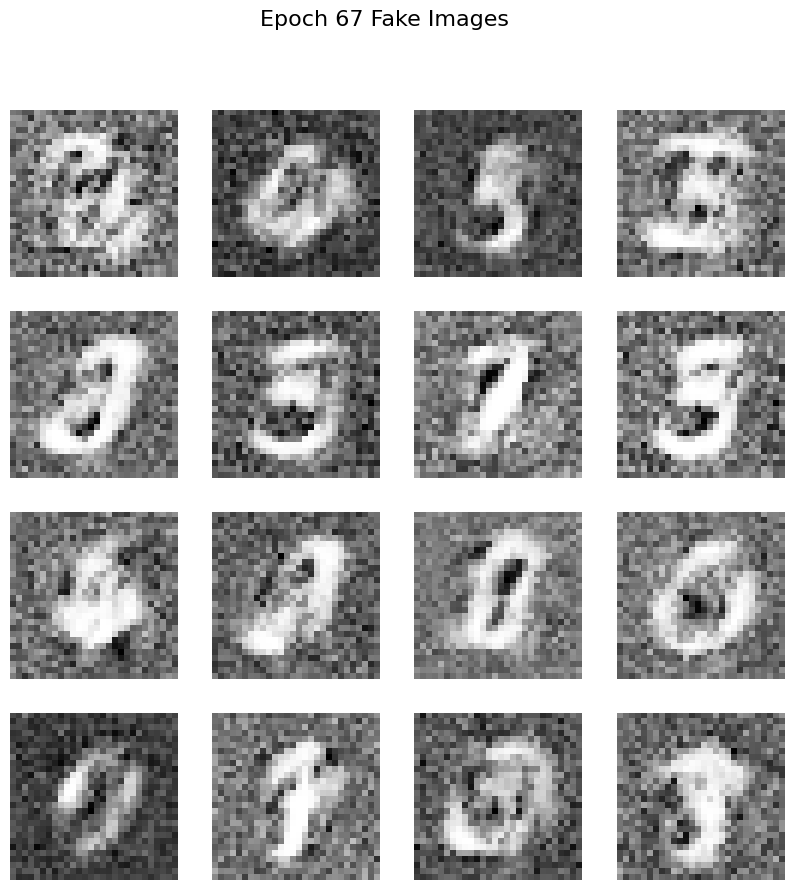

  0%|          | 0/391 [00:00<?, ?it/s]

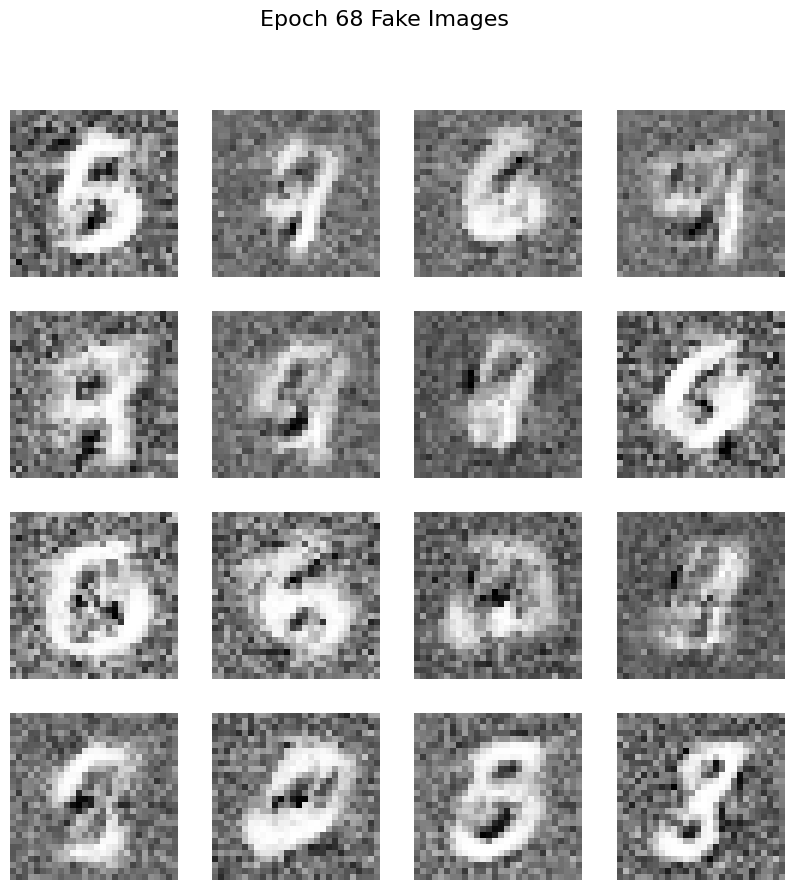

  0%|          | 0/391 [00:00<?, ?it/s]

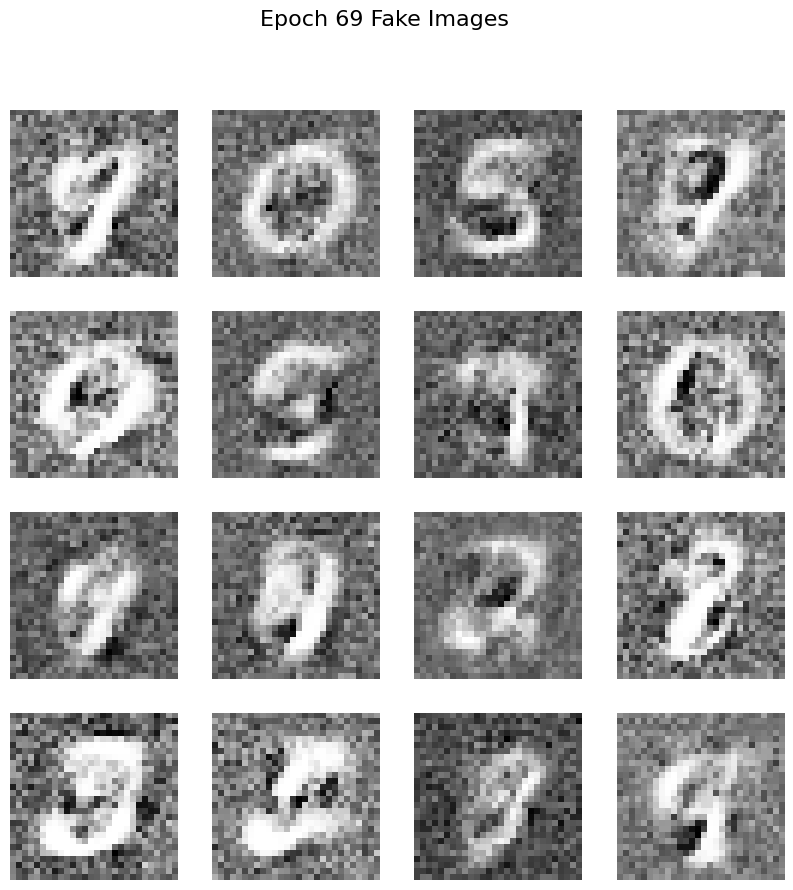

  0%|          | 0/391 [00:00<?, ?it/s]

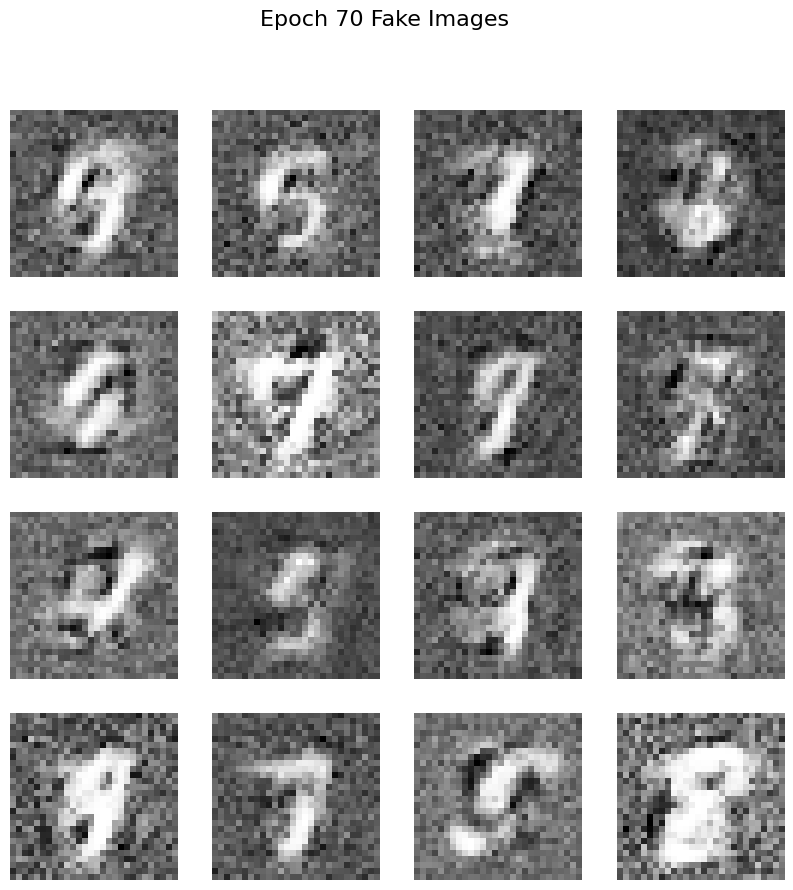

  0%|          | 0/391 [00:00<?, ?it/s]

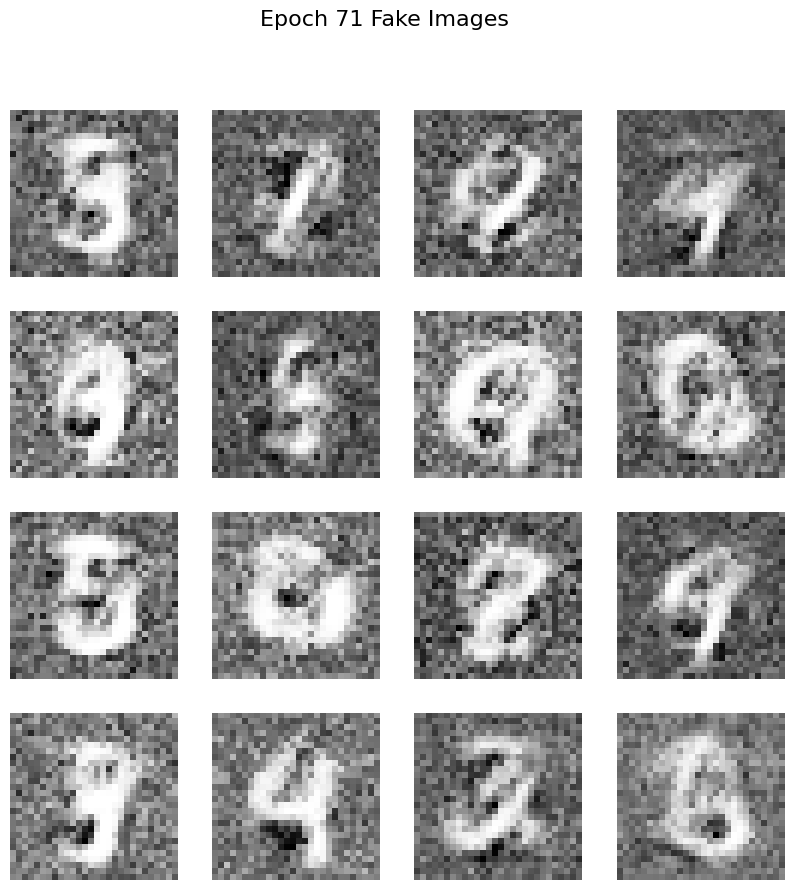

  0%|          | 0/391 [00:00<?, ?it/s]

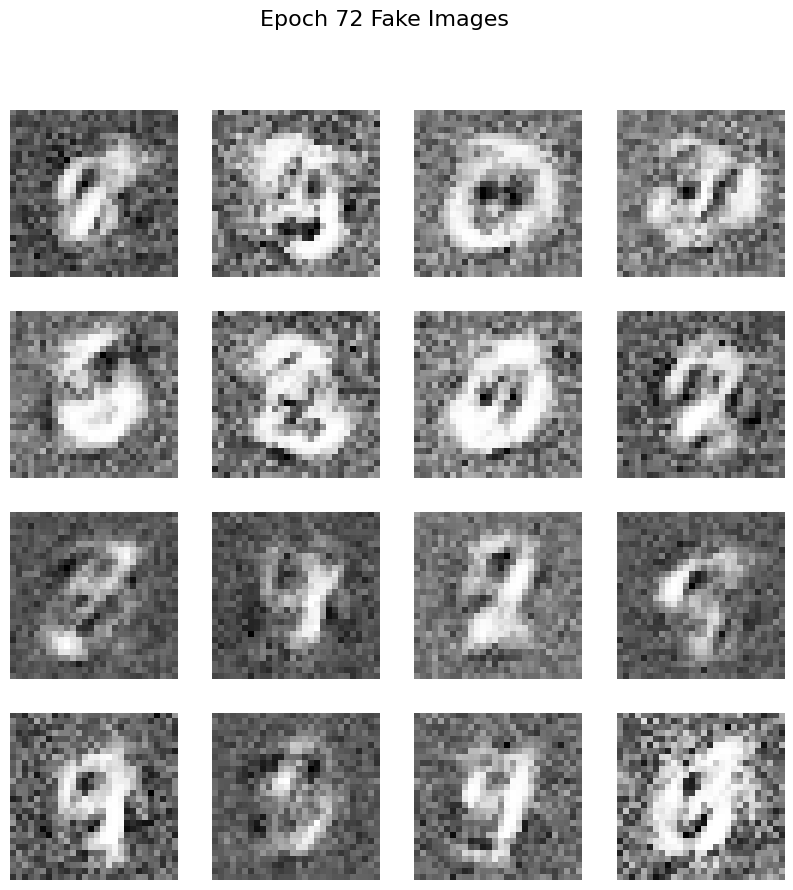

  0%|          | 0/391 [00:00<?, ?it/s]

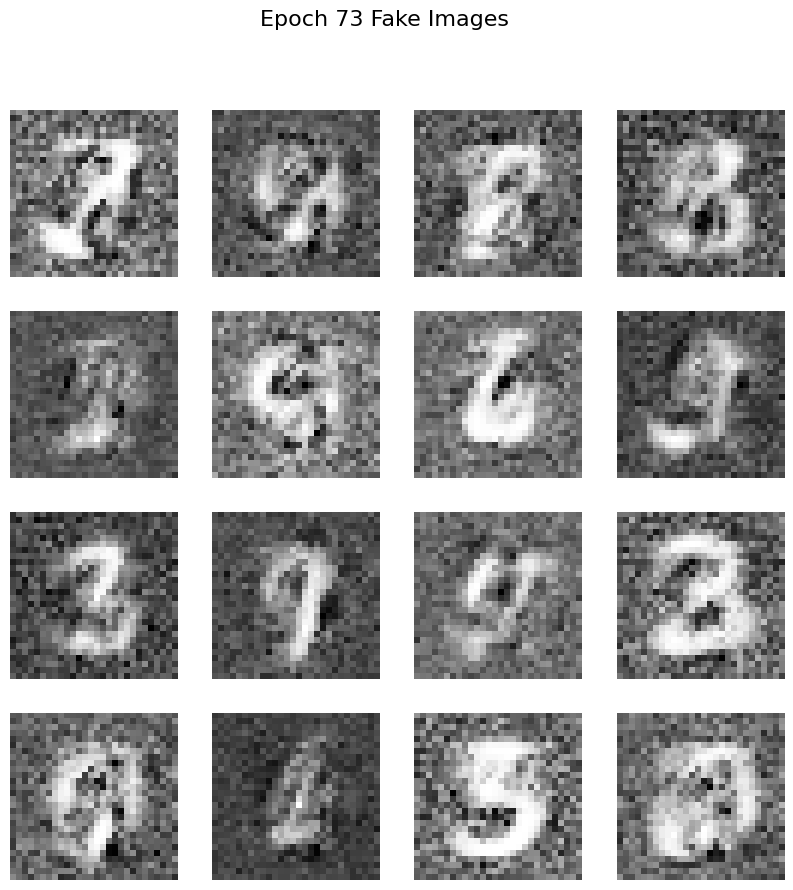

  0%|          | 0/391 [00:00<?, ?it/s]

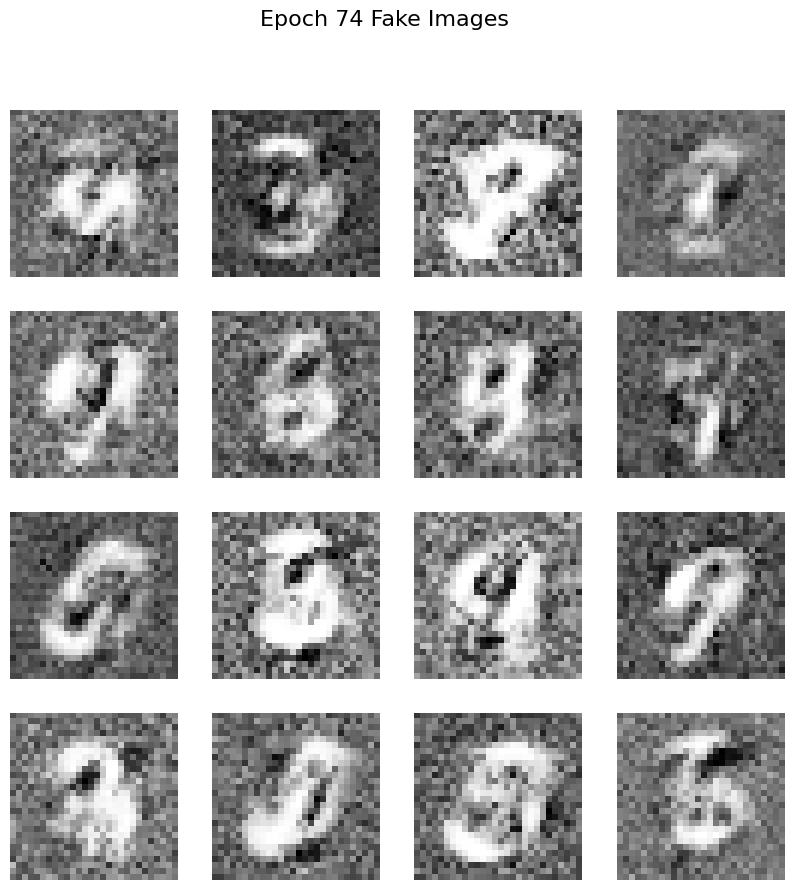

  0%|          | 0/391 [00:00<?, ?it/s]

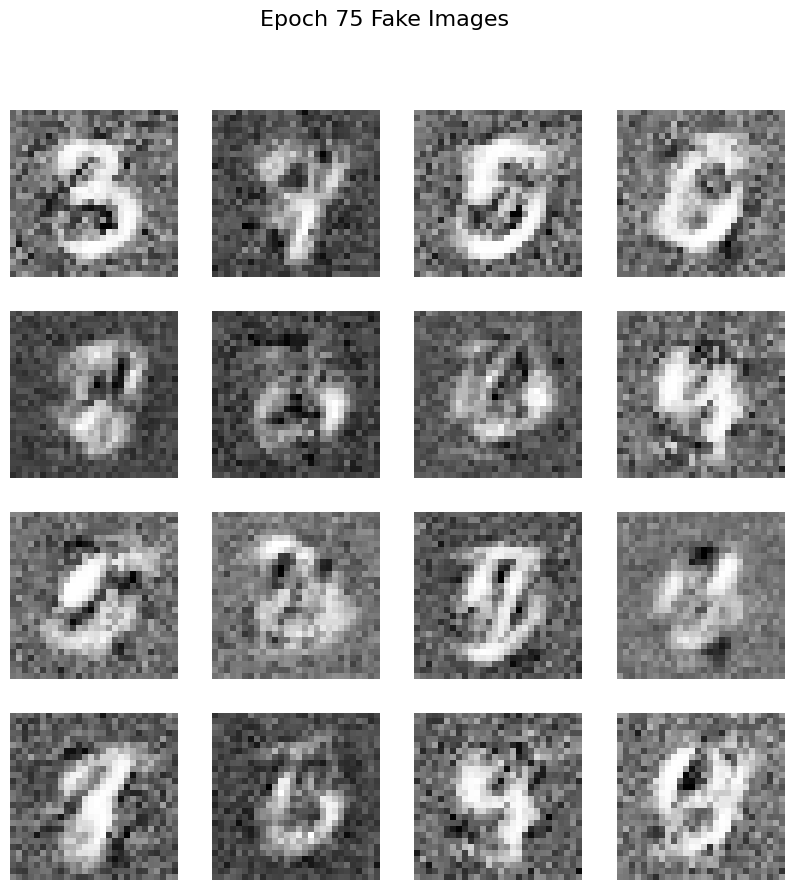

  0%|          | 0/391 [00:00<?, ?it/s]

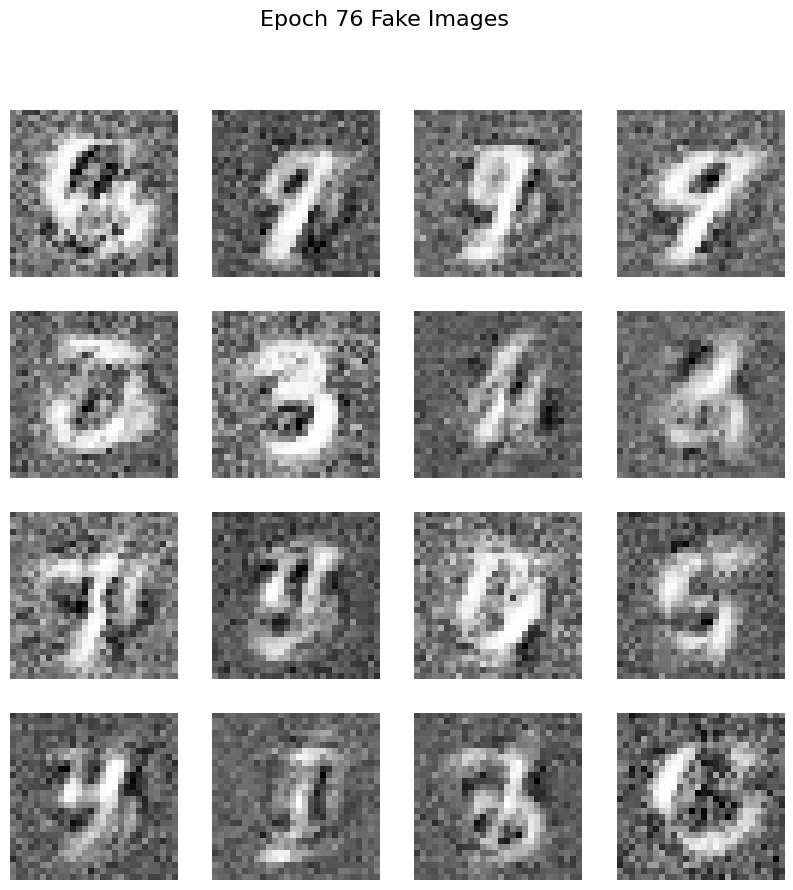

  0%|          | 0/391 [00:00<?, ?it/s]

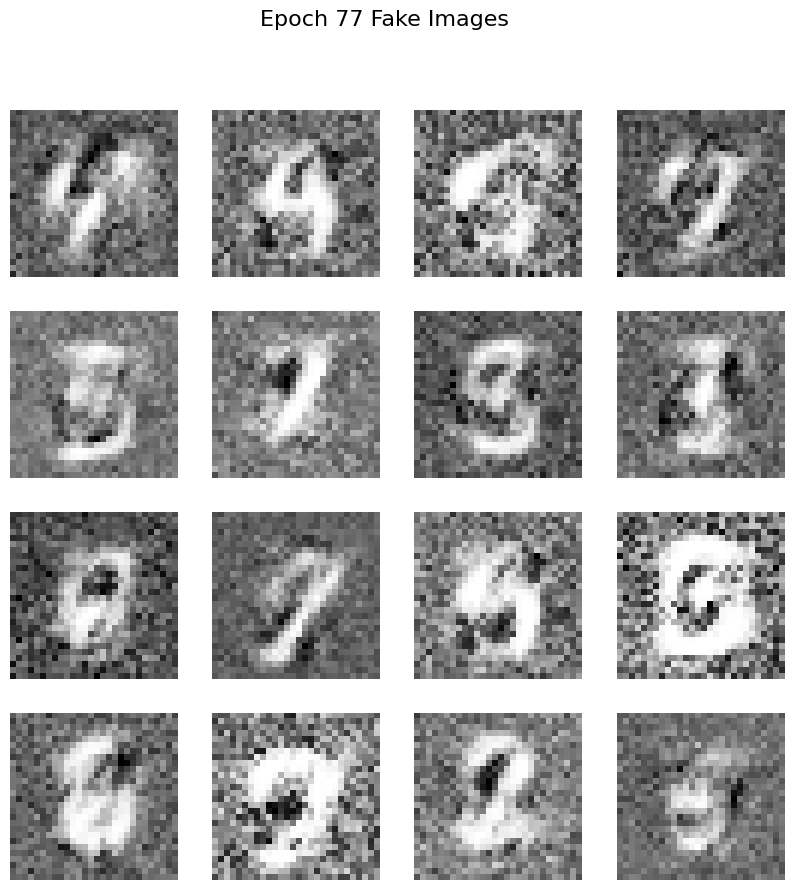

  0%|          | 0/391 [00:00<?, ?it/s]

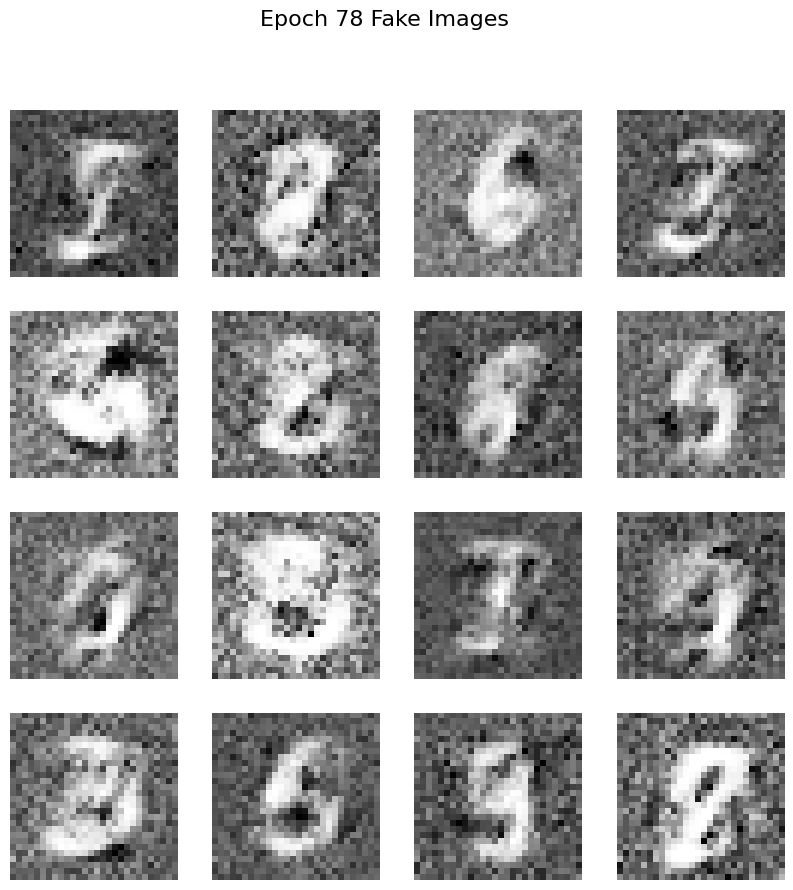

  0%|          | 0/391 [00:00<?, ?it/s]

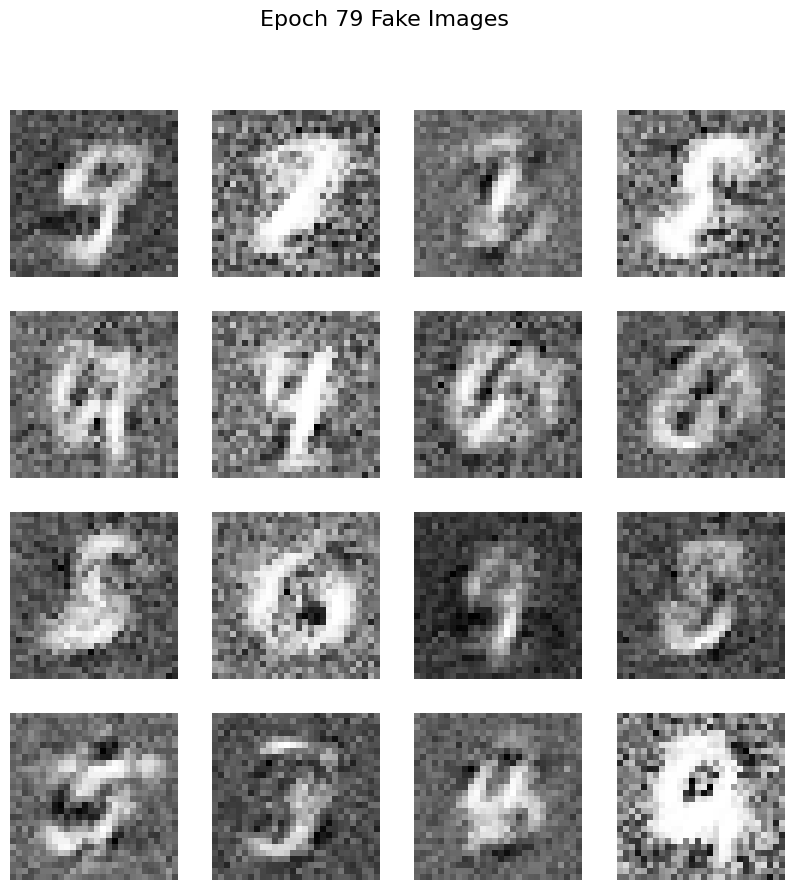

  0%|          | 0/391 [00:00<?, ?it/s]

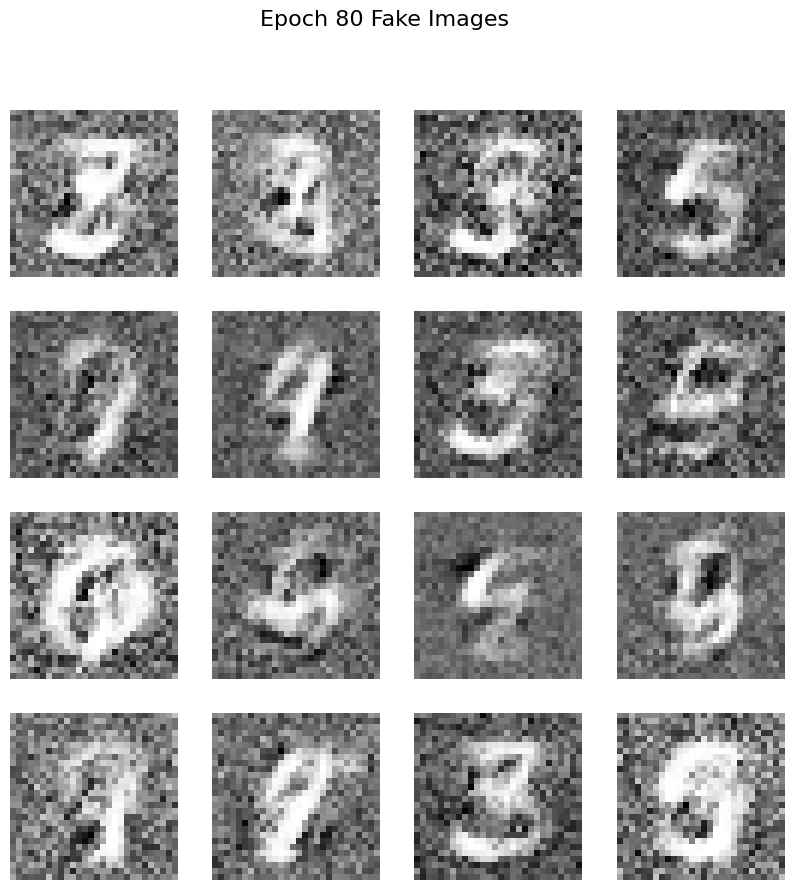

  0%|          | 0/391 [00:00<?, ?it/s]

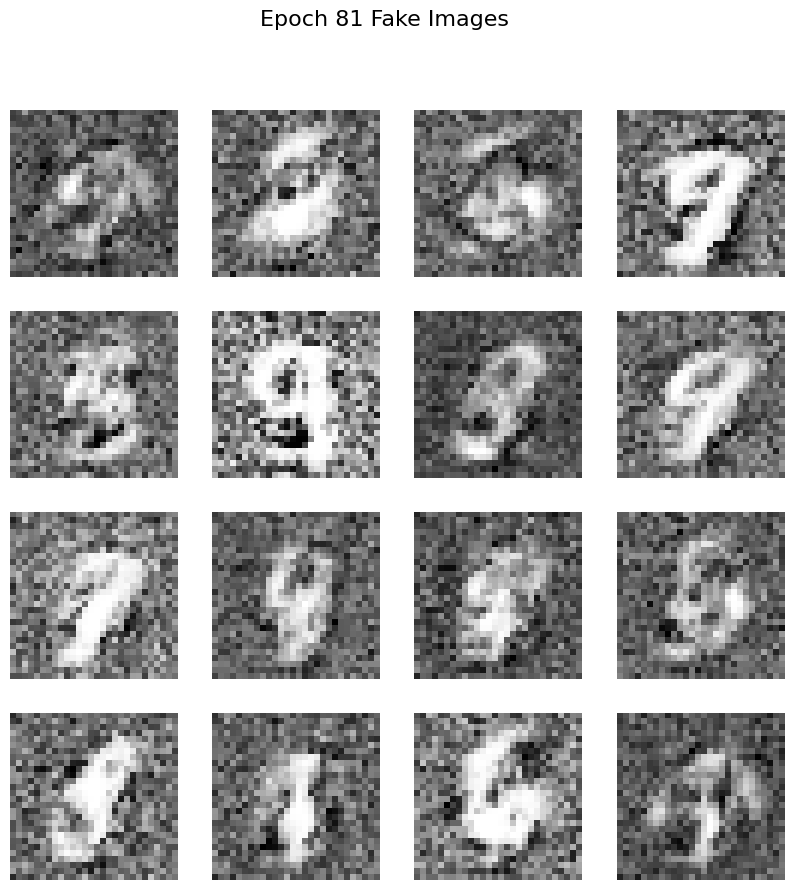

  0%|          | 0/391 [00:00<?, ?it/s]

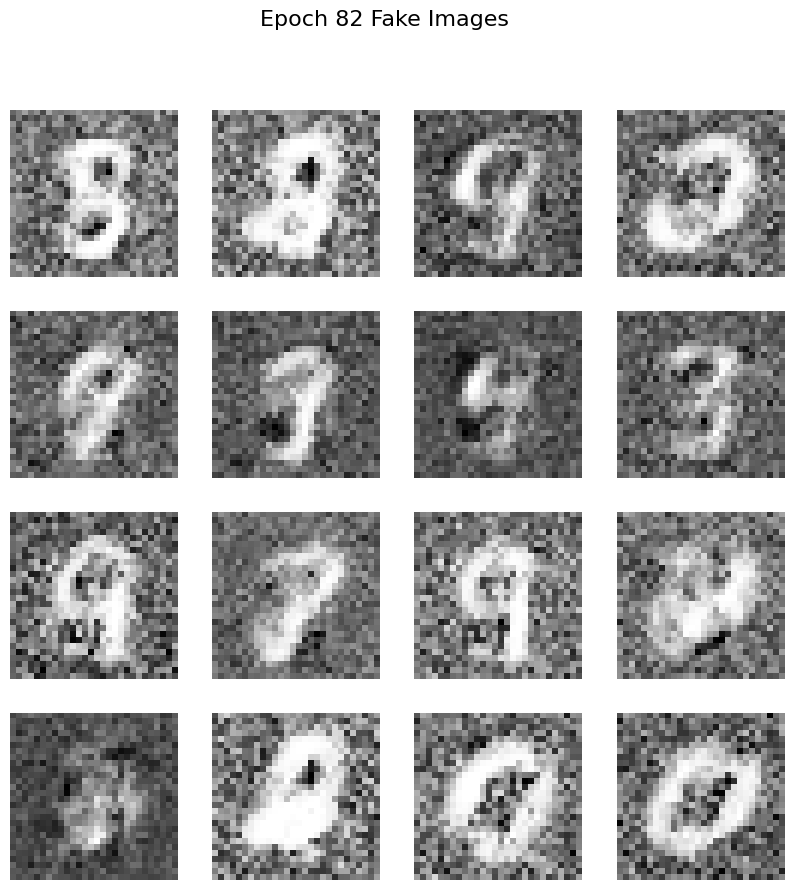

  0%|          | 0/391 [00:00<?, ?it/s]

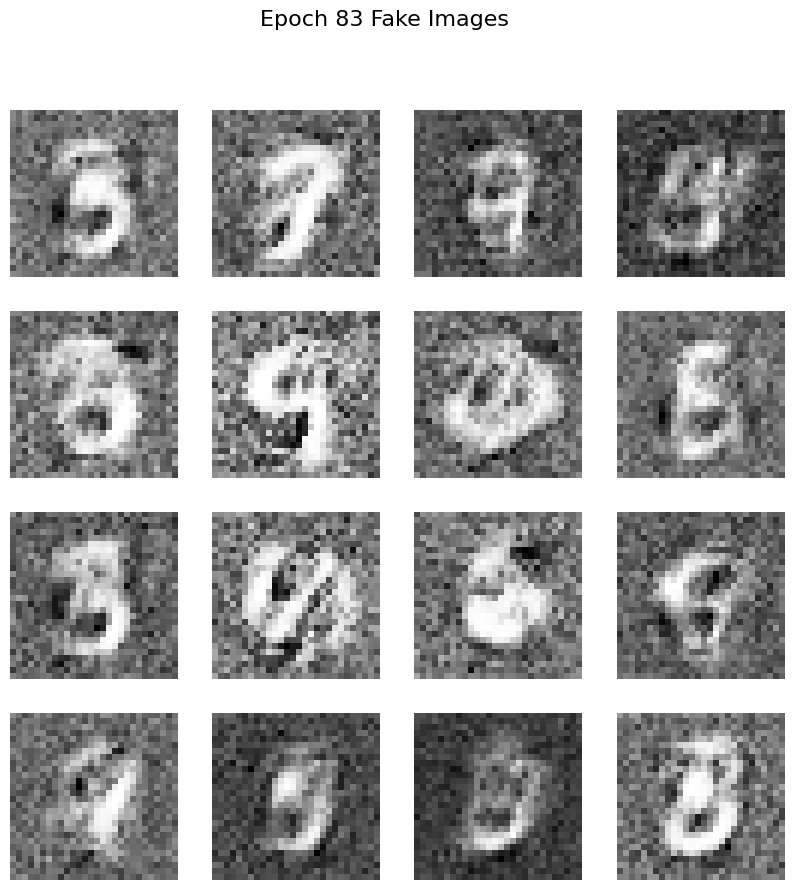

  0%|          | 0/391 [00:00<?, ?it/s]

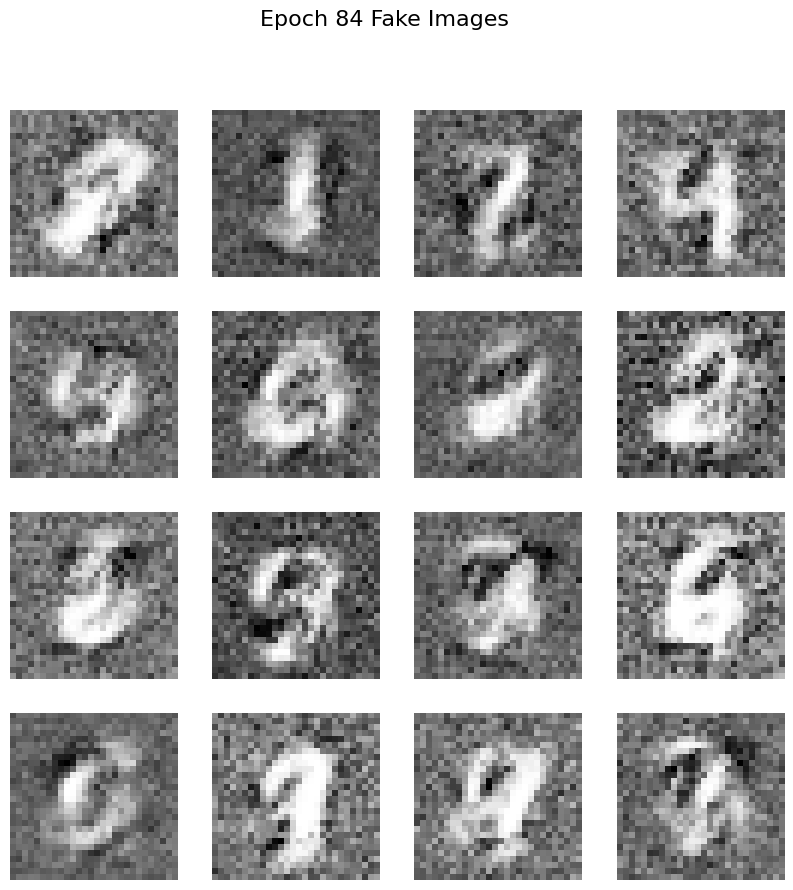

  0%|          | 0/391 [00:00<?, ?it/s]

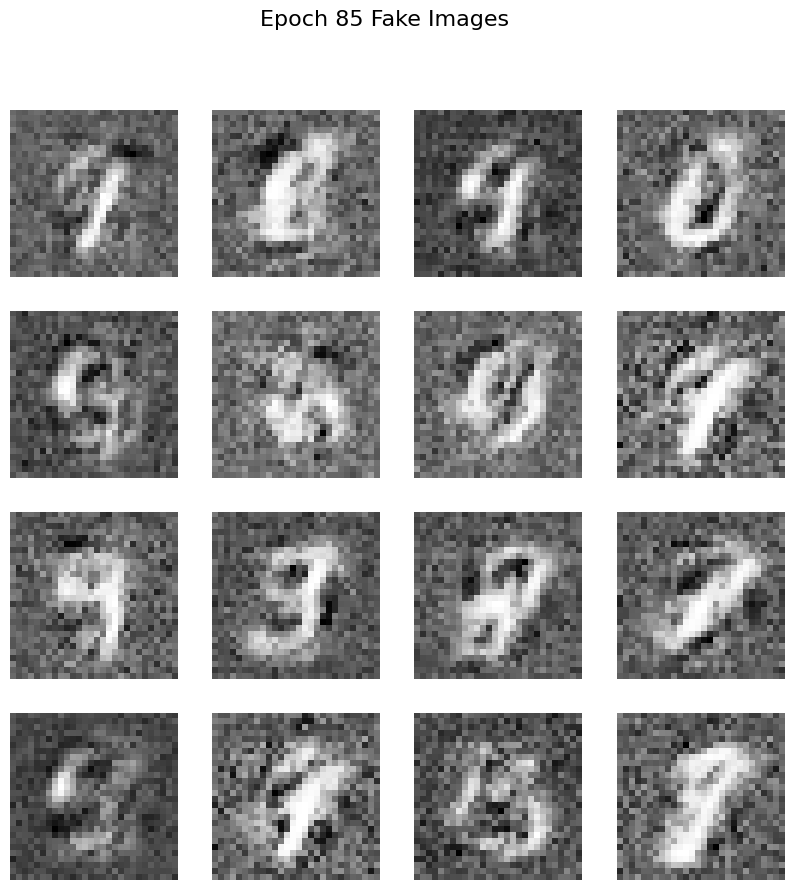

  0%|          | 0/391 [00:00<?, ?it/s]

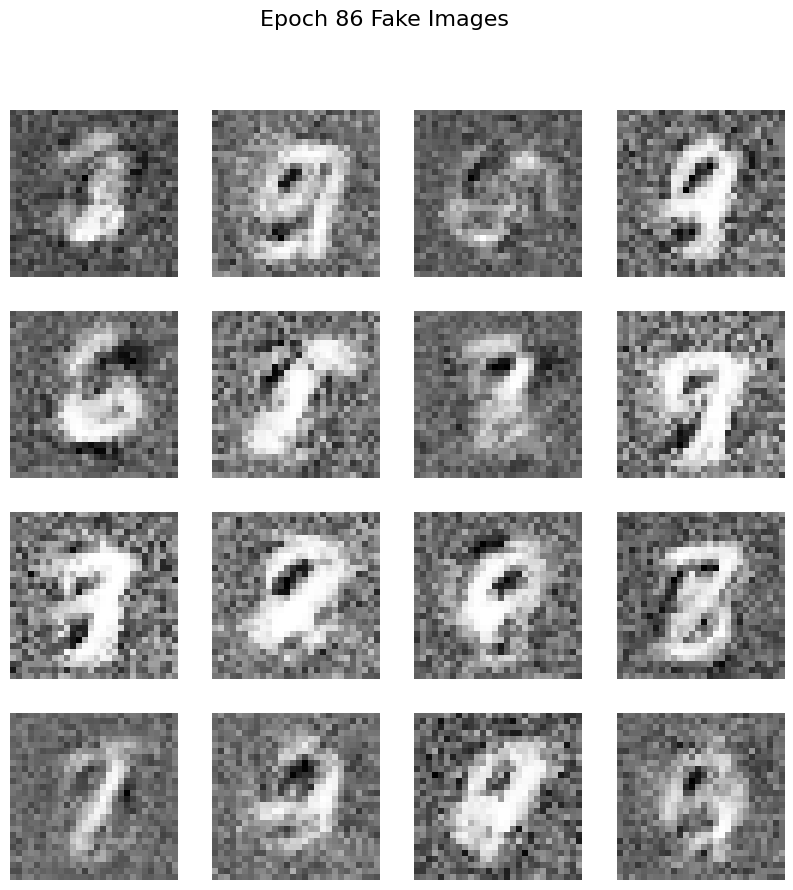

  0%|          | 0/391 [00:00<?, ?it/s]

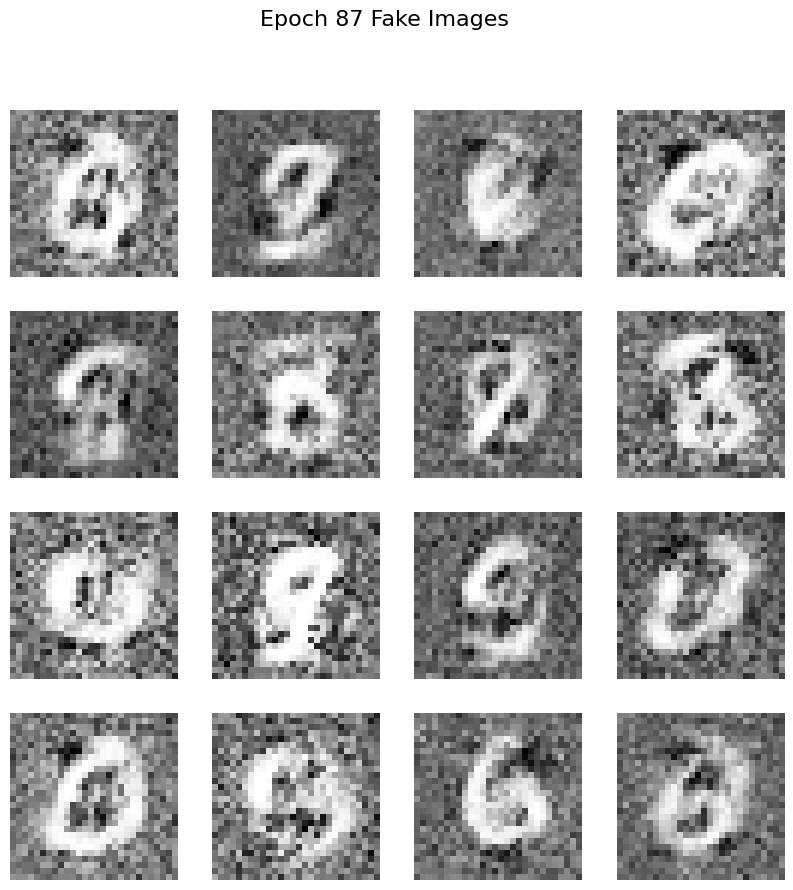

  0%|          | 0/391 [00:00<?, ?it/s]

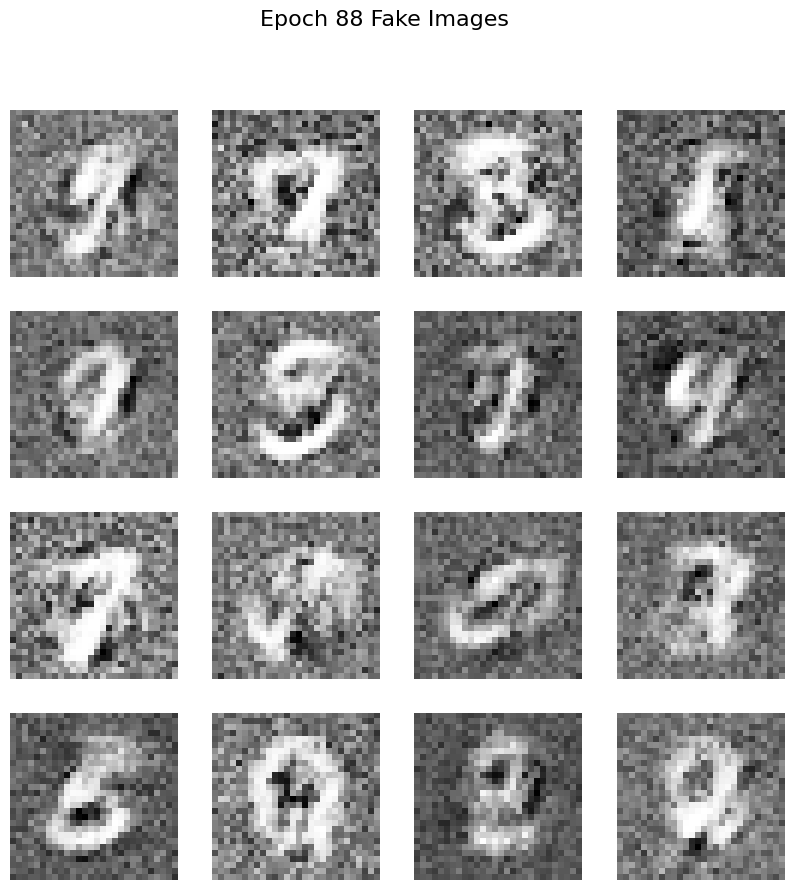

  0%|          | 0/391 [00:00<?, ?it/s]

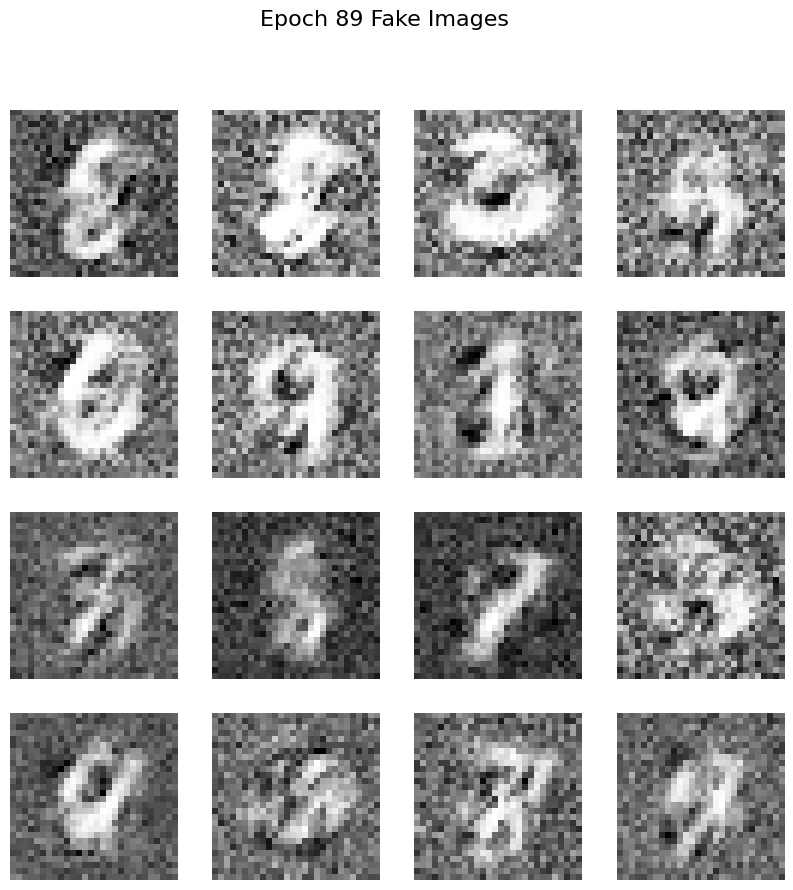

  0%|          | 0/391 [00:00<?, ?it/s]

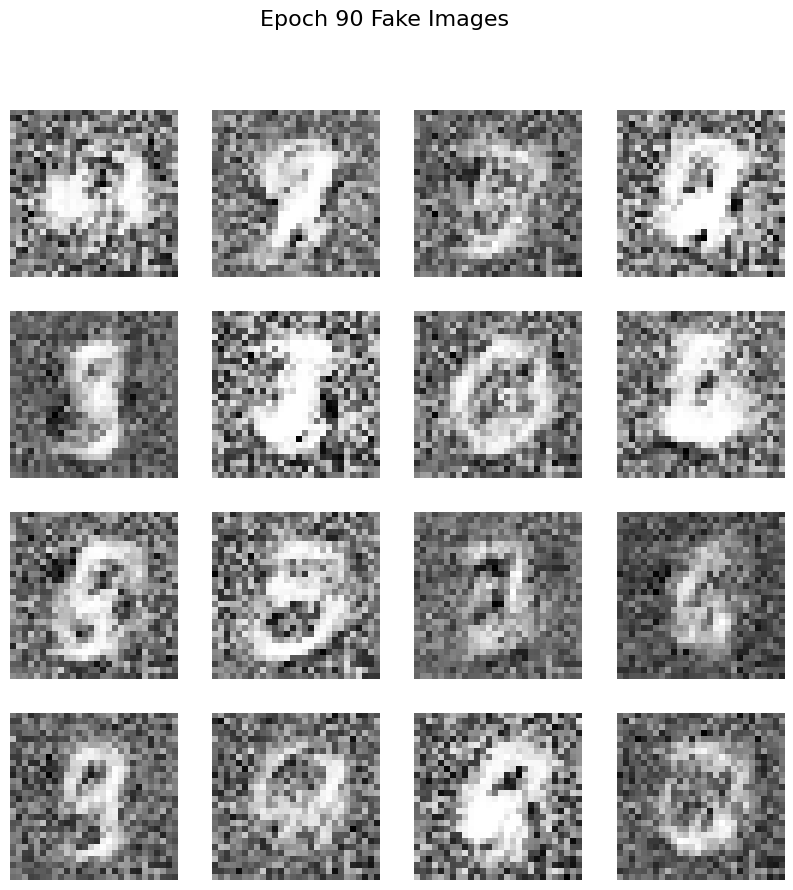

  0%|          | 0/391 [00:00<?, ?it/s]

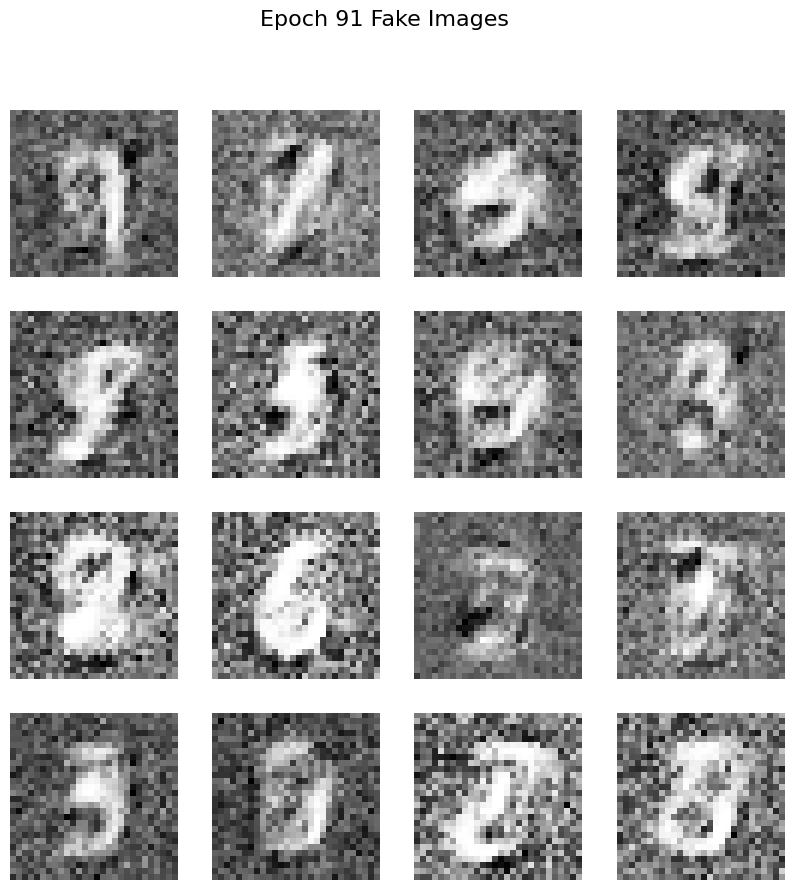

  0%|          | 0/391 [00:00<?, ?it/s]

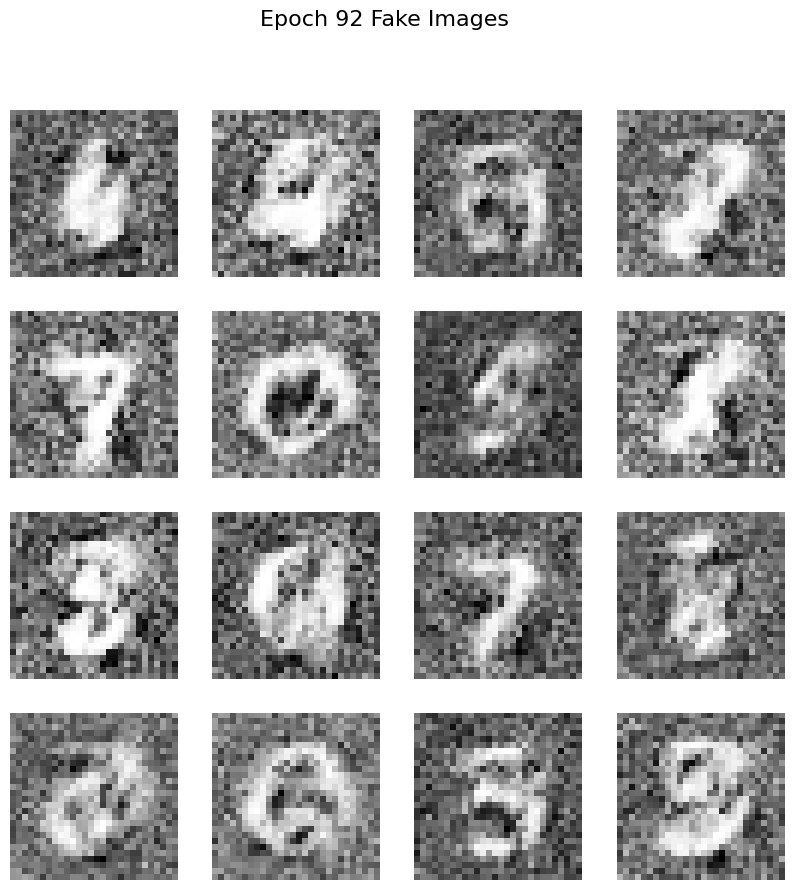

  0%|          | 0/391 [00:00<?, ?it/s]

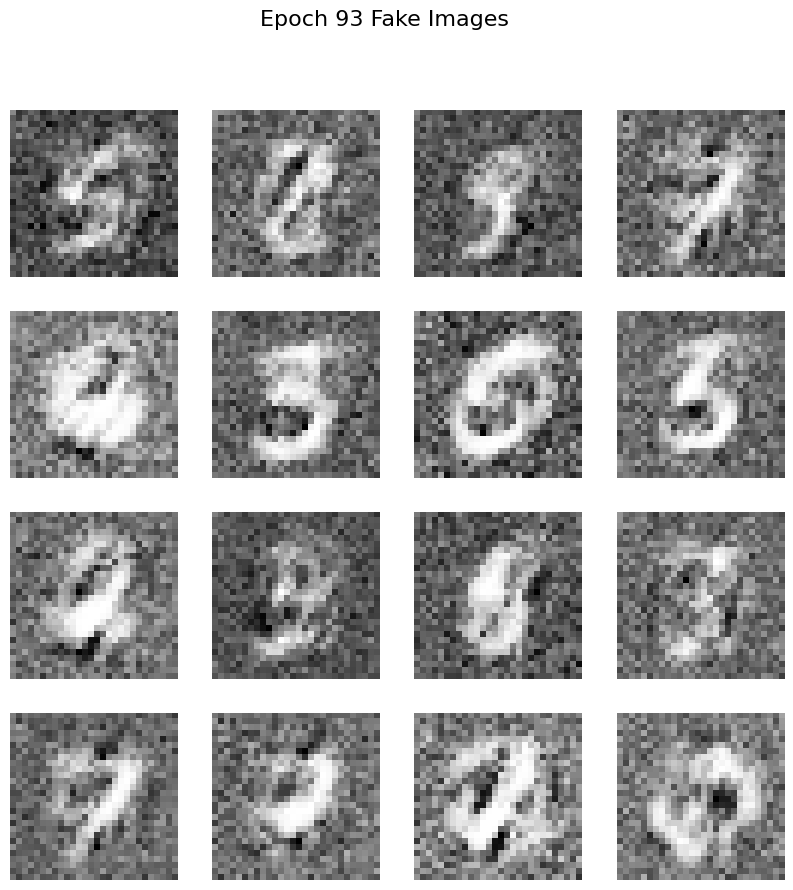

  0%|          | 0/391 [00:00<?, ?it/s]

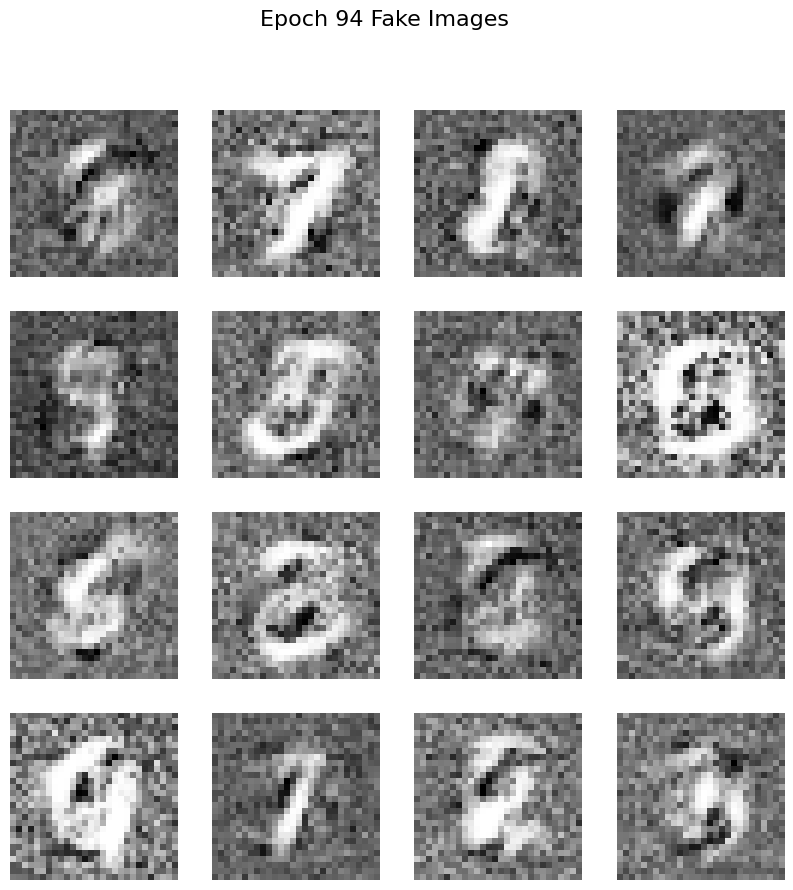

  0%|          | 0/391 [00:00<?, ?it/s]

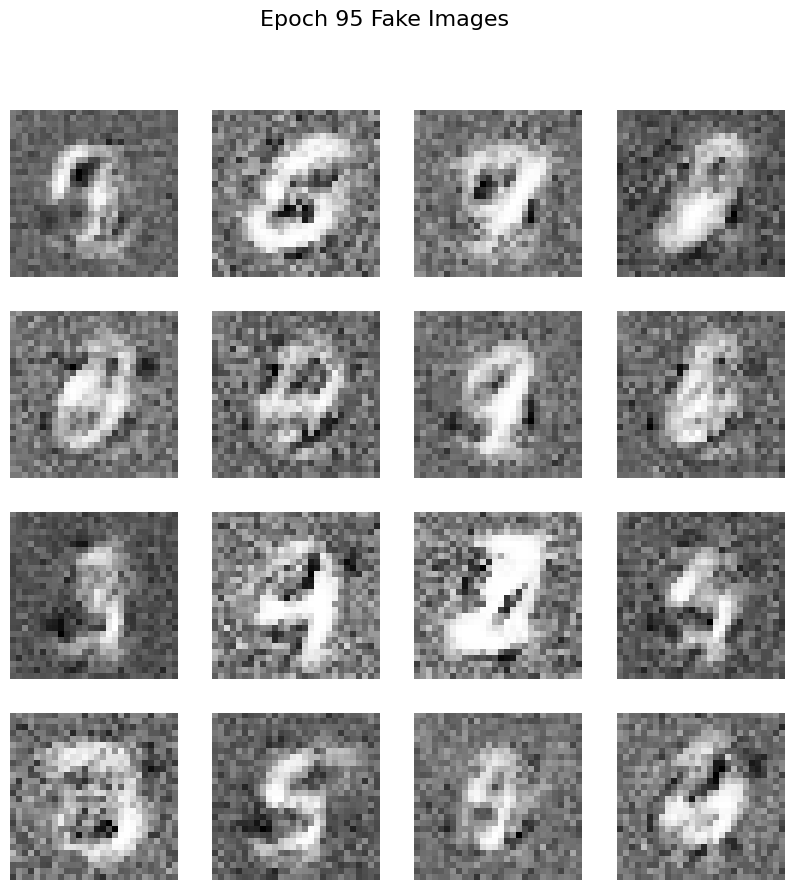

  0%|          | 0/391 [00:00<?, ?it/s]

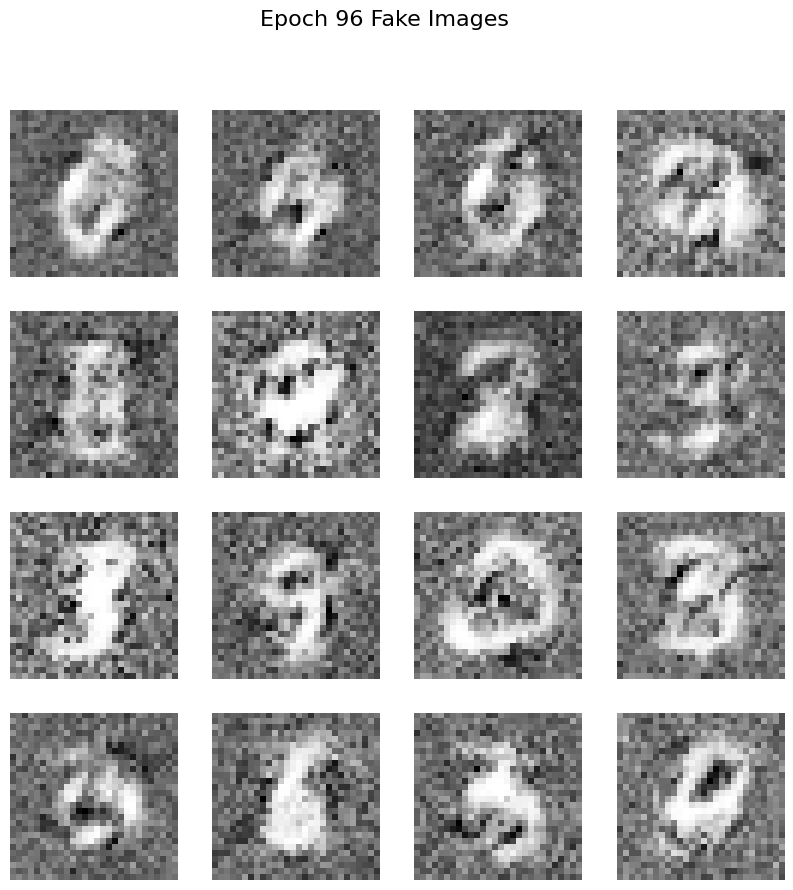

  0%|          | 0/391 [00:00<?, ?it/s]

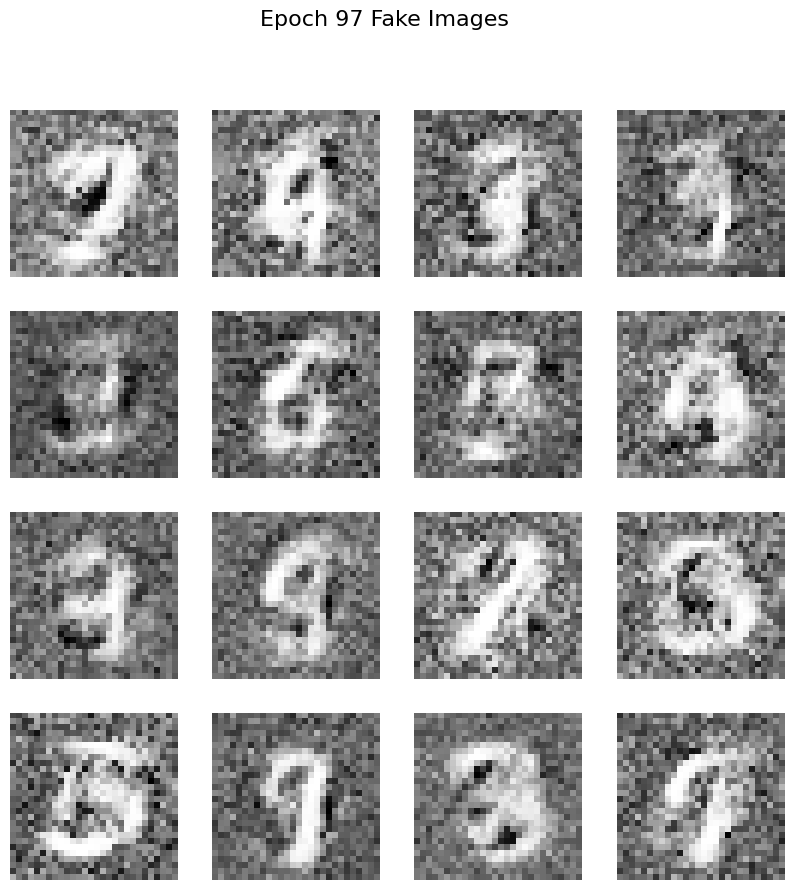

  0%|          | 0/391 [00:00<?, ?it/s]

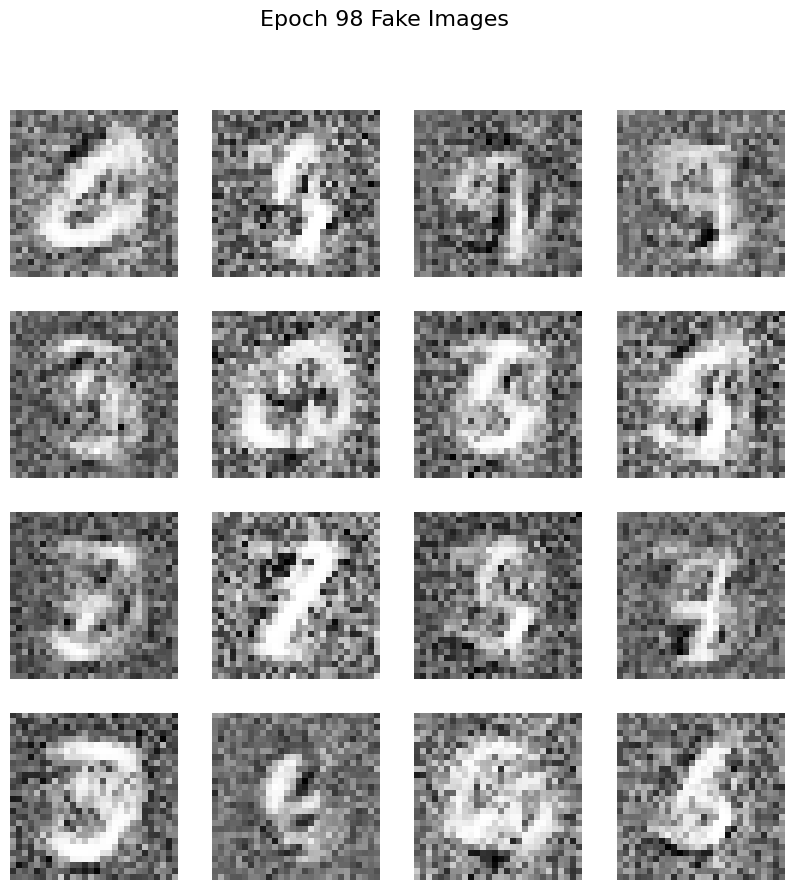

  0%|          | 0/391 [00:00<?, ?it/s]

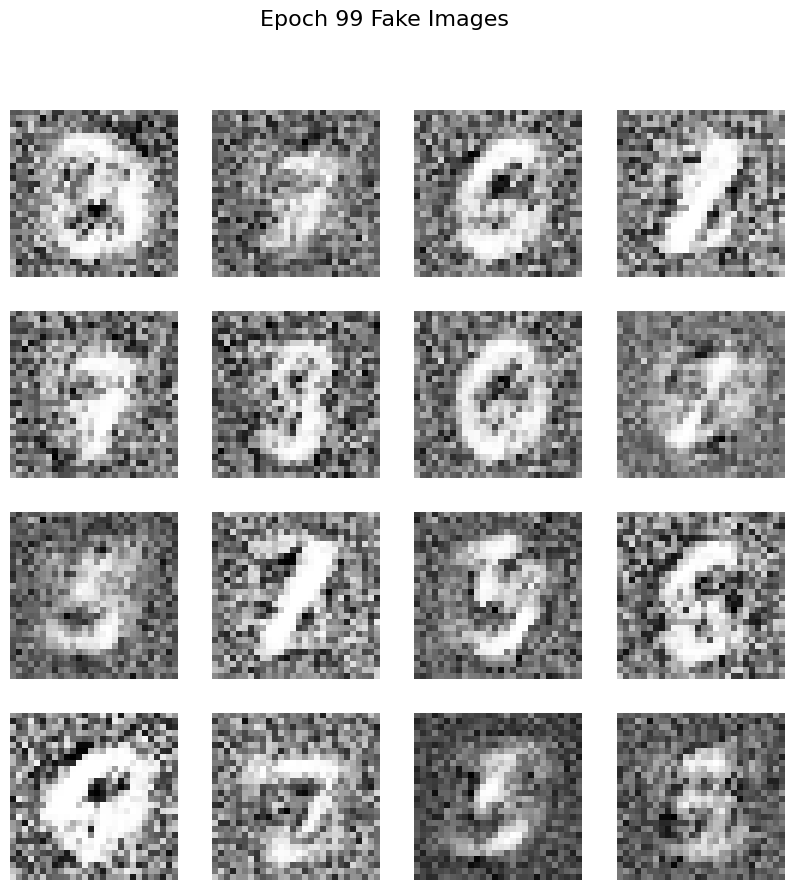

In [12]:
latent_dim = 64
generator, discriminator = train_gan(train_loader, latent_dim)

# Compare

Use validation dataset to plot and compare the results of your trained models.

In [13]:
# # TODO
# # Comparison of the generated images
# import math

# # assert len(validation_losses_vae) == len(validation_losses_gan)
# xx = list(range(50))

# plt.plot(xx, [math.log(elem) for elem in validation_losses_vae[-50:]], label ='VAE')
# plt.plot(xx, [math.log(elem) for elem in validation_losses_gan[-50:]], label ='GAN')

# plt.xlabel("Epoch")
# plt.ylabel("Validation Loss")
# plt.legend()
# # plt.title('Validation Loss Comparison')
# plt.show()

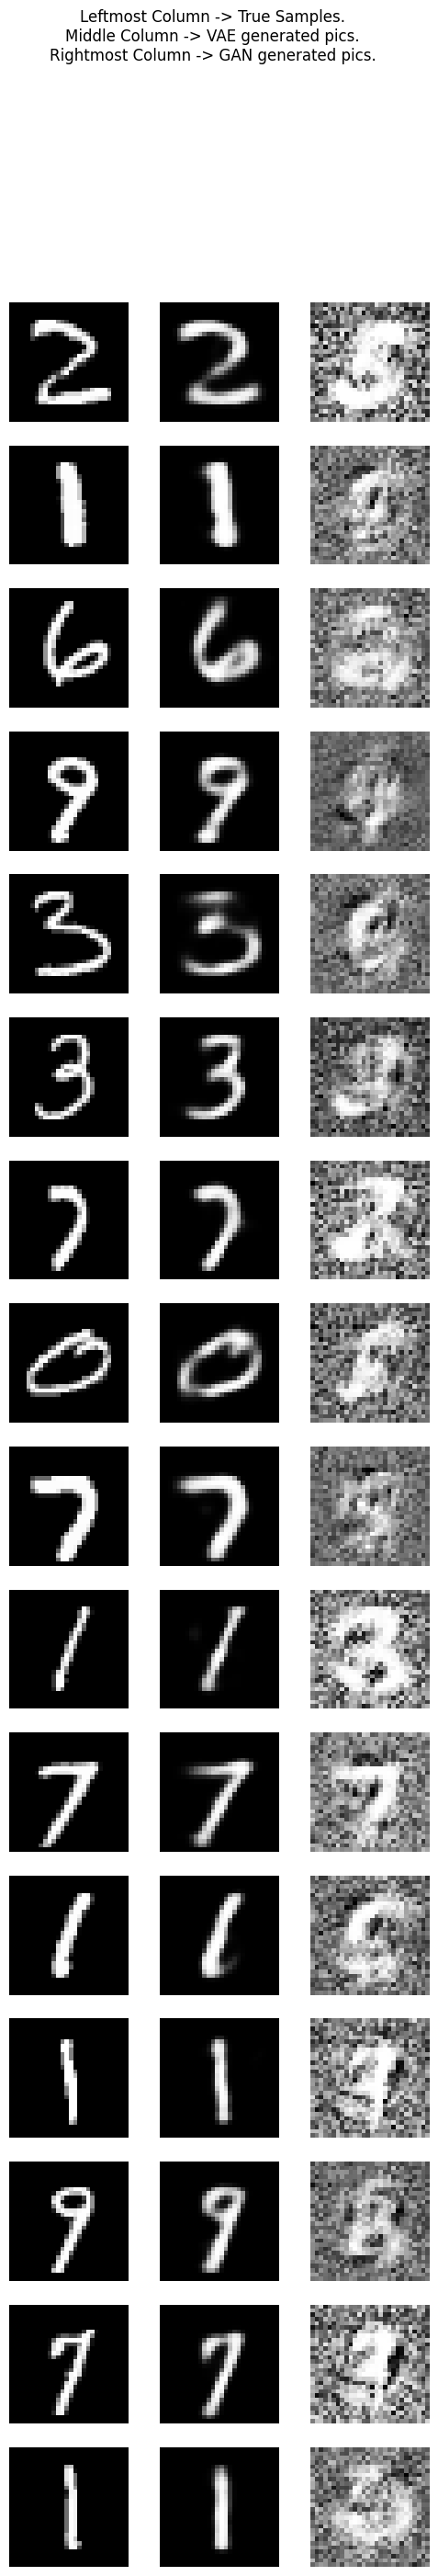

In [14]:
# TODO
# Comparison of the generated images
n = 16
model.eval()
generator.eval()
with torch.no_grad():
    sample_images, _ = next(iter(val_loader))
    vae_outputs = reconstruct_images(model, sample_images.view(-1, 784).to(DEVICE))

    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    gan_outputs = generator(noise)
ground_truth = sample_images[:n]
vae_sample = vae_outputs[:n]

fig, axes = plt.subplots(n, 3, figsize=(6, 2 * n))
fig.suptitle("Leftmost Column -> True Samples.\nMiddle Column -> VAE generated pics.\nRightmost Column -> GAN generated pics.")

for i in range(n):
    axes[i, 0].imshow(ground_truth[i].view(28, 28).cpu(), cmap='gray')
    axes[i, 1].imshow(vae_sample[i].view(28, 28).cpu(), cmap='gray')
    axes[i, 2].imshow(gan_outputs[i].cpu().view(28, 28), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
plt.show()